# Librerías y paquetes necesarios

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import lightgbm as lgb
import graphviz
import optuna
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, GroupKFold, PredefinedSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import statsmodels.api as sm
import xgboost as xgb
import pickle
import joblib
from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from statsmodels.genmod.generalized_estimating_equations import GEE
# Instead of importing Multinomial from discrete_model, use MNLogit
from statsmodels.discrete.discrete_model import MNLogit # Changed import statement
from statsmodels.genmod.cov_struct import Independence
from statsmodels.genmod.generalized_estimating_equations import NominalGEE
from statsmodels.genmod.cov_struct import Independence
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from patsy import dmatrices
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.tools import add_constant
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
import random
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_breuschpagan

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
filepath = '/content/drive/My Drive/PYMES/finalpymes.xlsx'
data = pd.read_excel(filepath)

In [ ]:
print(tabulate(data.head(10), headers = 'keys', tablefmt='pretty'))

+---+---------------------------+-----------+----------------------------------------+---------------------------------------------------+--------------------------------------------+--------------------------------+--------------------------------------------+----------------+-------------------------------------------------------------------------------------------+---------------------------+-----------------------------+--------------------+----------------------------------------+-------------------+----------------------+----------------------+-----------------------+----------------------+------------------------+----------------------+-------------+-------------------+-------------------+--------------------+---------------------+-------------------+-------------------+-------------------+-------------------+
|   |       Estado actual       |    NIT    | Concepto del Revisor fiscal en su orme | La compañía está obligada a tener Revisor fiscal? |              Tipo societario    

In [ ]:
print(f'Número de filas: {data.shape[0]}')
print(f'Número de columnas: {data.shape[1]}')

Número de filas: 141621
Número de columnas: 29


# Modelo propuesto mejorado

Se realizó una inspección de diferentes modelos de machine learning para el modelamiento de los datos de tipo panel y la extracción de variables significativas para cada año respetando la dependencia temporal y por grupo o 'NIT' de cada observación. Inicalmente se consideró realizar un pliegue de validación temporal secuencial teniendo en cuenta la dependencia en tiempo de las observaciones. Se realizó una comparación con otros modelos como regresión logística multinomial con variables de lagg para cada año, modelo de clasificación KNN implementando validación secuencial, modelo clasificatorio de maquinas de soporte vectorial con validación secuencial, modelo de xtreme gradient boosting (XGBoost) con validación secuencial, modelo de penalización clasificatoria L2, L1 con validación secuencial.

Se propone el uso del modelo de clasificación de `Extreme Gradient Boosting (XGBoost)` como base para la predicción de etiquetas de clasificación teneindo en cuenta sus relevantes resultados en la comparación con los demás modelos. Se propone la siguiente metodología de clasificación:

1. `Stacking`: Prueba independiente del modelo XGBoost + Predicción de etiquetas de clasificación sobre los resisudos de clasificación con LigthGBM
2.` Meta-modelo:` Clasificación de las etiquetas de las categorías con XGBoost y refuerzo de las predicciones con el cálculo de las probabilidades de las clases como enrada para LigthGBM.

Se evalúan las dos opciones de clasificación y se presenta un resultado final con la que presente mejor rendimiento de clasificación.

Para el entrenamiento del modelo y la búsqueda de hiperparámetros se consideró el uso de variables microeconómicas o indicadores financieros no reduntantes y con baja multicolinealidad. Del mismo modo, la división en categorías de la variable objetivo `ratio entre flujo disponible y flujo libre de caja`.

In [ ]:
import pandas as pd
import numpy as np

# 1. Definir las columnas que NO necesitas eliminar
columns_to_keep = [
    'NIT', 'Fecha de Corte', 'Cantidad de años de la empresa', 'Razón corriente', 'Rotación cartera',
    'ROA', 'ROE',
    'Generación Efectivo',
    'Estado actual', 'Concepto del Revisor fiscal en su orme',
    'La compañía está obligada a tener Revisor fiscal?', 'Tipo societario',
    'Departamento de la dirección del domicilio',
    'Clasificación Industrial Internacional Uniforme Versión 4 A.C (CIIU)'
]

# 2. Filtrar las columnas que deseas mantener (las que están en 'columns_to_keep')
data_filter = data[columns_to_keep].copy()

bins = [-np.inf, 0, 0.67, 0.80, 1, np.inf]
labels = ['<0', '[0, 0.67)', '[0.67, 0.80)', '[0.80, 1)', '[1, ∞)']
data_filter['FDC_FLC_categoria'] = pd.cut(data['FDC/FLC'], bins=bins, labels=labels, right=False)

#### *Variables a utilizar*

Se destaca la selección y transformación a su respectivo tipo de las variables involucradas en el análisis para un posterior tratamiento y modelamiento óptimo.

Posterior a la prueba de multicolinealidad y de selección manual por parte de los expertos investigadores de las variables a implementar en el modelo dado que responden a la pregunta de investigación, ¿Qué variables influyen en la clasificación en las escalas de las empresas? Se listan a continuación:

- `Cantidad de años de la empresa:` Numéro de años en existencia de la empresa
- `Razón corriente:` Ratio entre Total activos y Total pasivos
- `Rotación de cartera:` Ratio entre tital de ventas o ingresos y cuentas por cobrar del periodo anual.
- `ROA`: Ratio entre beneficio neto de le empresa y promedio de activos de la empresa.
- `ROE`: Ratio entre beneficio neto y patrimonio de la empresa.
- `Generación de efectivo:` Cálculo mediante el flujo de caja operativo
- `Estado actual:` Estado en el que se encontraba una empresa determinada en un periódo de tiempo dado.
- `Concepto de revisro fiscal en su orme:` En qué condicionameinto se debía tener el revisor fiscal para la empresa.
- `Tipo socieetario`: El tipo de sociedad de una empresa en particular
- `Departamento de domicilio:` La ubicación particular en terminos de departamento en colombia de la empresa.
- `CIUU`: Categoría de la empresa.


In [ ]:
numeric_vars = [
    'Cantidad de años de la empresa', 'Razón corriente', 'Rotación cartera', 'ROA', 'ROE',
     'Generación Efectivo'
]

categorical_vars = [
    'Estado actual', 'Concepto del Revisor fiscal en su orme',
    'La compañía está obligada a tener Revisor fiscal?', 'Tipo societario',
    'Departamento de la dirección del domicilio',
    'Clasificación Industrial Internacional Uniforme Versión 4 A.C (CIIU)',
    'FDC_FLC_categoria'
]

# Convertir las columnas numéricas a tipo 'float'
data_filter[numeric_vars] = data_filter[numeric_vars].apply(pd.to_numeric, errors='coerce')

# Convertir las columnas categóricas a tipo 'category'
data_filter[categorical_vars] = data_filter[categorical_vars].apply(lambda x: x.astype('category'))

In [ ]:
# Verificar los tipos de datos después de la conversión
print("Tipos de datos después de la conversión:")
print(data_filter.dtypes)

Tipos de datos después de la conversión:
NIT                                                                        int64
Fecha de Corte                                                             int64
Cantidad de años de la empresa                                           float64
Razón corriente                                                          float64
Rotación cartera                                                         float64
ROA                                                                      float64
ROE                                                                      float64
Nivel de endeudamiento                                                   float64
Generación Efectivo                                                      float64
Estado actual                                                           category
Concepto del Revisor fiscal en su orme                                  category
La compañía está obligada a tener Revisor fiscal?                   

El modelamiemto de los datos se realizó con cerca de 37 mil observaciones a lo largo de los años 2017 hasta 2023 y se contempla el siguiente número de registros por año:

- Hay `4357` observaciones en el año `2017`
- Hay `4078` observaciones en el año `2018`
- Hay `5278` observaciones en el año `2019`
- Hay `5832` observaciones en el año `2020`
- Hay `5895` observaciones en el año `2021`
- Hay `5910` observaciones en el año `2022`
- Hay `5818` observaciones en el año `2023`

In [ ]:
print(f'Hay {len(data_filter)} observaciones en total en el conjunto de datos')
print(f'Hay {len(data_filter.columns)} columnas en total en el conjunto de datos')

# Contar las observaciones por cada año
conteo_por_ano = data_filter['Fecha de Corte'].value_counts().sort_index()
for año, conteo in conteo_por_ano.items():
    print(f'Hay {conteo} observaciones en el año {año}')

Hay 37168 observaciones en total en el conjunto de datos
Hay 17 columnas en total en el conjunto de datos
Hay 4357 observaciones en el año 2017
Hay 4078 observaciones en el año 2018
Hay 5278 observaciones en el año 2019
Hay 5832 observaciones en el año 2020
Hay 5895 observaciones en el año 2021
Hay 5910 observaciones en el año 2022
Hay 5818 observaciones en el año 2023


De los datos a modelar que cumplen con el criterio de tener información u haber reportado servicio de deuda en sus resgistros o datos financieros, se puede contemplar a continuación parte de su información.

In [ ]:
data_filter.head()

NIT  Fecha de Corte  Cantidad de años de la empresa  \
2   800000313            2017                            30.0   
3   800000439            2017                            30.0   
12  800001354            2017                            30.0   
13  800001650            2017                            30.0   
16  800002143            2017                            30.0   

    Razón corriente  Rotación cartera       ROA       ROE  \
2          2.156702         56.296118  0.002475  0.003986   
3          2.614717         65.489035  0.062720  0.120886   
12         3.387169         31.099677  0.077652  0.123869   
13         2.196981        105.182158 -0.126416 -0.333004   
16         0.668726         11.377192  0.046760  0.073899   

    Generación Efectivo Estado actual Concepto del Revisor fiscal en su orme  \
2            -18.713938        ACTIVA                             03. LIMPIO   
3             -1.449247        ACTIVA                             03. LIMPIO   
12            -0.277214        ACTIVA                             03. LIMPIO   
13             0.003630        ACTIVA                             03. LIMPIO   
16            -1.020946        ACTIVA                             03. LIMPIO   

   La compañía está obligada a tener Revisor fiscal?  \
2                                                 SI   
3                                                 SI   
12                                                SI   
13                                                SI   
16                                                SI   

                               Tipo societario  \
2   08. SOCIEDAD POR ACCIONES SIMPLIFICADA SAS   
3                        03. SOCIEDAD LIMITADA   
12                       03. SOCIEDAD LIMITADA   
13                        01. SOCIEDAD ANÓNIMA   
16                        01. SOCIEDAD ANÓNIMA   

   Departamento de la dirección del domicilio  \
2                                 BOGOTA D.C.   
3                                CUNDINAMARCA   
12                                      VALLE   
13                                BOGOTA D.C.   
16                                BOGOTA D.C.   

   Clasificación Industrial Internacional Uniforme Versión 4 A.C (CIIU)  \
2                          Industrias manufactureras.                     
3   Comercio al por mayor y al por menor; reparaci...                     
12  Agricultura, ganadería, caza, silvicultura y p...                     
13                         Industrias manufactureras.                     
16                                         Educación.                     

   FDC_FLC_categoria  
2             [1, ∞)  
3             [1, ∞)  
12            [1, ∞)  
13            [1, ∞)  
16         [0, 0.67)

Para el conjunto de datos con el que se stá trabajando, se debe inspeccionnar la presencia de datos faltantes, el cual se evidencia a continuación:

- Cantidad de años de la empresa     `19`
- Razón corriente                    `57`
- Rotación cartera                  `592`
- Generación Efectivo                `34`

In [ ]:
missing_data = data_filter.isnull().sum()

# Mostrar las columnas que tienen valores faltantes
print("Cantidad de datos faltantes por columna:")
print(missing_data[missing_data > 0])

Cantidad de datos faltantes por columna:
Cantidad de años de la empresa     19
Razón corriente                    57
Rotación cartera                  592
Generación Efectivo                34
dtype: int64


Para las variables con datos faltantes se debe realizar un proceso de imputación y teniendo en cuenta la naturaleza no paramétrica de la distribución de la mayoría de variables involucradas, se implementará el método `IterativeImputer` o `imputación iterativa`.

In [ ]:
# Seleccionar solo las columnas numéricas para imputar
numeric_columns = data_filter.select_dtypes(include=['float64', 'int64']).columns

# Aplicar IterativeImputer solo a las columnas numéricas
imputer = IterativeImputer(random_state=42, max_iter=10, n_nearest_features=5, imputation_order='ascending')
data_filter_imputed = data_filter.copy()
data_filter_imputed[numeric_columns] = imputer.fit_transform(data_filter[numeric_columns])

# Verificar la cantidad de datos faltantes después de la imputación
missing_data_after_imputation = data_filter_imputed.isnull().sum()
print("\nCantidad de datos faltantes después de la imputación:")
print(missing_data_after_imputation[missing_data_after_imputation > 0])

# Calcular cuántos valores fueron imputados (si se imputaron valores)
imputados = missing_data - missing_data_after_imputation
print("\nCantidad de valores imputados por columna:")
print(imputados[imputados > 0])


Cantidad de datos faltantes después de la imputación:
Series([], dtype: int64)

Cantidad de valores imputados por columna:
Cantidad de años de la empresa     19
Razón corriente                    57
Rotación cartera                  592
Generación Efectivo                34
dtype: int64


## Modelo de base XGBoost

Durante la división de los datos se asigna a la variable objetivo `y` la columna a predecir `FDC_FLC_categoria` y se excluye de la variables predictoras las columnas `NIT`, `FDC_FLC_categoria` y `Fecha de Corte`.

In [ ]:
# Separar las características (X) y la etiqueta (y)
X = data_filter_imputed.drop(columns=['FDC_FLC_categoria', 'NIT', 'Fecha de Corte'])
y = data_filter_imputed['FDC_FLC_categoria']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

En el proceso de preprocesamiento de los datos se realiza la estandarización de las variables numéricas con el método `StandardScaler` y la codificación de las variables categóricas con el método `OneHotEncoder`.

In [ ]:
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()  # Columnas numéricas
categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()  # Columnas categóricas

# Estandarización para las variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  # Estandarización
])

# One-Hot Encoding para las variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores faltantes en las variables categóricas
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encoding
])

# Preprocesador con ColumnTransformer que aplica las transformaciones correspondientes a cada tipo de columna
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

La familia a utilizar de los modelos `Extreme Gradient Boosting` o `XGBoost` será de tipo multiclase y en esta caso, multi:softmax es el parámetro que debe recibir la función.

In [ ]:
xgb_model = XGBClassifier(random_state=42, objective='multi:softmax', num_class=len(y.unique()))

In [ ]:
# Crear el pipeline completo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgbclassifier', xgb_model)
])

Se realiza una busqueda para el proceso de hiperparametrización de los mejores parámetros para el modelo. Se establecen los siguientes:

- '`xgbclassifier__n_estimators`': Define cuántos árboles componen el modelo de clasificación.
- '`xgbclassifier__learning_rate`': Controla la magnitud de los ajustes en cada iteración.
- '`xgbclassifier__max_depth`': Limita la profundidad máxima de cada árbol, evitando sobreajuste.
- '`xgbclassifier__subsample`': Porcentaje de datos utilizados para entrenar cada árbol, mejora generalización.
- '`xgbclassifier__colsample_bytree`': Proporción de características seleccionadas aleatoriamente por cada árbol.
- '`xgbclassifier__gamma`': Establece penalización para árboles más complejos, reduciendo sobreajuste.

In [ ]:
param_grid = {
    'xgbclassifier__n_estimators': [100, 200],  # Número de árboles
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],  # Tasa de aprendizaje
    'xgbclassifier__max_depth': [3, 5, 7],  # Profundidad máxima del árbol
    'xgbclassifier__subsample': [0.8, 1.0],  # Submuestreo
    'xgbclassifier__colsample_bytree': [0.8, 1.0],  # Fracción de características por árbol
    'xgbclassifier__gamma': [0, 0.1, 0.2]  # Penalización de complejidad
}

Busqueda en red para mejores parámetros arrojó la siguiente lista a nibel general y no separado por año:
- '`xgbclassifier__n_estimators`': 0.8
- '`xgbclassifier__learning_rate`': 0
- '`xgbclassifier__max_depth`': 0.1
- '`xgbclassifier__subsample`': 5
- '`xgbclassifier__colsample_bytree`': 200
- '`xgbclassifier__gamma`': 0.8

In [ ]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Paso 8: Ajustar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Paso 9: Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejores hiperparámetros encontrados: {'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}


**Se muestra a continuación los mejores hiperparámetros por año para el modelo XGBoost:**

- `2018`: 'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8
- `2019`: 'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 7, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8
- `2020`: 'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 0.2, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8
- `2021`: 'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8
- `2022`: 'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8
- `2023`: 'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 1.0

In [ ]:
# Dividir los datos por año para entrenamiento secuencial
years = sorted(data_filter_imputed['Fecha de Corte'].unique())
label_encoder = LabelEncoder()

for i in range(1, len(years)):
    train_years = years[:i]  # Datos de entrenamiento hasta el año i-1
    test_year = years[i]     # Año para la prueba

    # Filtrar los datos de entrenamiento y prueba
    X_train = data_filter_imputed[data_filter_imputed['Fecha de Corte'].isin(train_years)].drop(columns=['FDC_FLC_categoria', 'Fecha de Corte', 'NIT'])
    y_train = data_filter_imputed[data_filter_imputed['Fecha de Corte'].isin(train_years)]['FDC_FLC_categoria']
    X_test = data_filter_imputed[data_filter_imputed['Fecha de Corte'] == test_year].drop(columns=['FDC_FLC_categoria', 'Fecha de Corte', 'NIT'])
    y_test = data_filter_imputed[data_filter_imputed['Fecha de Corte'] == test_year]['FDC_FLC_categoria']

    # Codificar las etiquetas de la variable objetivo para entrenamiento
    y_train_encoded = label_encoder.fit_transform(y_train)  # Codificar etiquetas de entrenamiento
    y_test_encoded = label_encoder.transform(y_test)  # Codificar etiquetas de prueba

    # Configurar el GridSearchCV
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

    # Ajustar el modelo con los datos de entrenamiento
    grid_search.fit(X_train, y_train_encoded)
    print(f"\nMejores hiperparámetros para el año {test_year}: {grid_search.best_params_}")

    # Evaluar el modelo en los datos de prueba
    best_model = grid_search.best_estimator_  # El mejor modelo encontrado por GridSearchCV
    y_pred = best_model.predict(X_test)  # Predicciones en el conjunto de prueba
    test_accuracy = accuracy_score(y_test_encoded, y_pred)  # Calcular la precisión
    print(f"Precisión en el conjunto de prueba para el año {test_year}: {test_accuracy}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Mejores hiperparámetros para el año 2018.0: {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}
Precisión en el conjunto de prueba para el año 2018.0: 0.4879843060323688
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Mejores hiperparámetros para el año 2019.0: {'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 7, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.8}
Precisión en el conjunto de prueba para el año 2019.0: 0.5077680939749906
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Mejores hiperparámetros para el año 2020.0: {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 0.2, 'xgbclassifier__learning_rate': 0.1, 'x

**Mejores hiperparámetros promedio a utilizar en el modelo XGBoost dado la verificación por año**

- '`xgbclassifier__n_estimators`': 1
- '`xgbclassifier__learning_rate`': 0.1
- '`xgbclassifier__max_depth`': 0.1
- '`xgbclassifier__subsample`': 5
- '`xgbclassifier__colsample_bytree`': 100
- '`xgbclassifier__gamma`': 0.8

In [ ]:
# modelo XGBoost para clasificación multiclase
xgb_model = XGBClassifier(random_state=42, objective='multi:softmax', num_class=len(np.unique(y_encoded)))

# pipeline completo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgbclassifier', xgb_model)
])

In [ ]:
# Ajustar los mejores hiperparámetros
pipeline.set_params(xgbclassifier__n_estimators=100,
                    xgbclassifier__learning_rate=0.1,
                    xgbclassifier__max_depth=5,
                    xgbclassifier__subsample=0.8,
                    xgbclassifier__colsample_bytree=1,
                    xgbclassifier__gamma=0.1)

# Dividir los datos por año para entrenamiento secuencial
years = sorted(data_filter_imputed['Fecha de Corte'].unique())

# Resultados para almacenar las métricas
# Resultados para almacenar las métricas
results = {
    'Year': [],
    'Accuracy': [],
    'ROC AUC': [],
    'F1 Score': [],
    'Precision': [],
    'Recall': [],
    'Confusion Matrix': [],
    'Classification Report': [],
}

#### **Lanzamiento del modelo de clasificación de base XGBoost**



Se obtiene la siguiente información del entrenamiento o validación secuencial del modelo de base XGBoost:
1. `Año 2018: `

Para el año 2018 se tiene que las variabes que más influyen en la clasificación de las clases son:
- `num__Generación Efectivo:` 0.0317
- `num__ROA`: 0.0302
- `cat__Departamento` de la dirección del domicilio: 0.0287
- `num__ROE`: 0.0212
- `cat__Departamento` de la dirección del domicilio: 0.0207

**Matriz de confusión para 2018**
- Total de Predicciones Correctas: 326
- Total de Predicciones Incorrectas: 269
- Número Total de Predicciones: 763
- Número de Verdaderos Positivos: 428 (categoría [0, 0.67))
- Número de Falsos Positivos: 256
- Número de Falsos Negativos: 32
- Número de Verdaderos Negativos: 441 (categoría [1, ∞))

2. `Año 2019:`

Para el año 2019, las variables que más influyen en la clasificación de las clases son:

- `num__ROA`: 0.0357
- `num__Generación Efectivo:` 0.0328
- `cat__Estado actual_ACUERDO DE REESTRUCTURACIÓN:` 0.0208
- `cat__Departamento de la dirección del domicilio`: 0.0208
- `cat__Clasificación Industrial Internacional Un:` 0.0195



Matriz de Confusión para 2019:

- Total de Predicciones Correctas: 532
- Total de Predicciones Incorrectas: 295
- Número Total de Predicciones: 832
- Número de Verdaderos Positivos: 191 (categoría [0, 0.67))
- Número de Falsos Positivos: 554
- Número de Falsos Negativos: 112
- Número de Verdaderos Negativos: 294 (categoría [1, ∞))

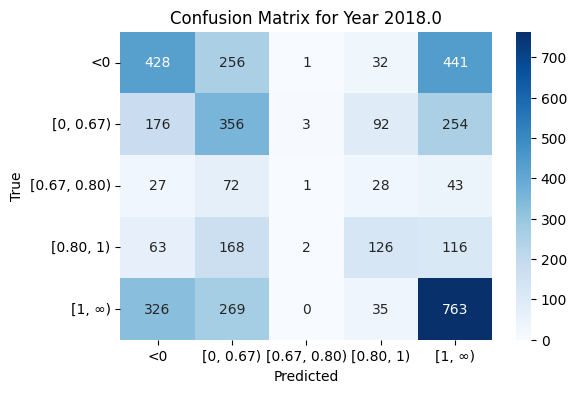

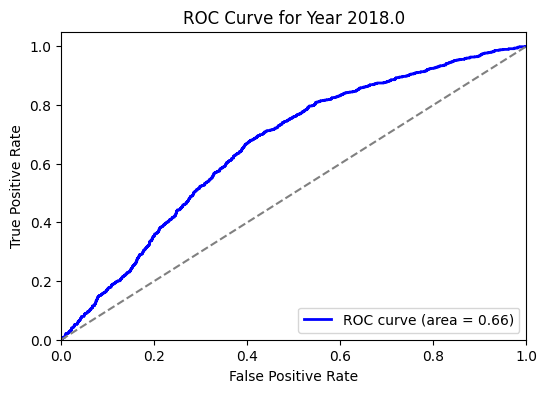


Variables más significativas para el año 2018.0:
                                              Feature  Importance
5                            num__Generación Efectivo    0.031658
3                                            num__ROA    0.030222
44  cat__Departamento de la dirección del domicili...    0.028746
4                                            num__ROE    0.021155
26  cat__Departamento de la dirección del domicili...    0.020669
50  cat__Clasificación Industrial Internacional Un...    0.020080
24  cat__Tipo societario_08. SOCIEDAD POR ACCIONES...    0.019799
7      cat__Estado actual_ACUERDO DE REESTRUCTURACIÓN    0.019469
2                               num__Rotación cartera    0.019309
28  cat__Departamento de la dirección del domicili...    0.018955




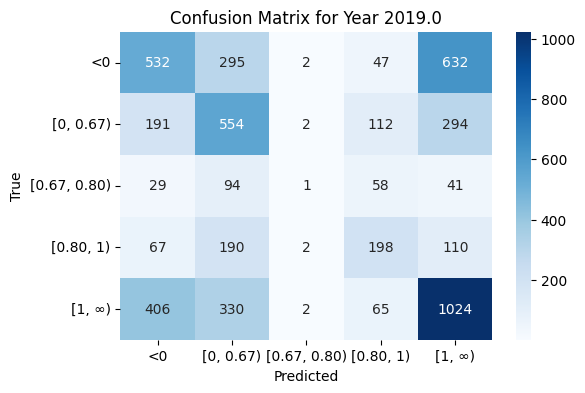

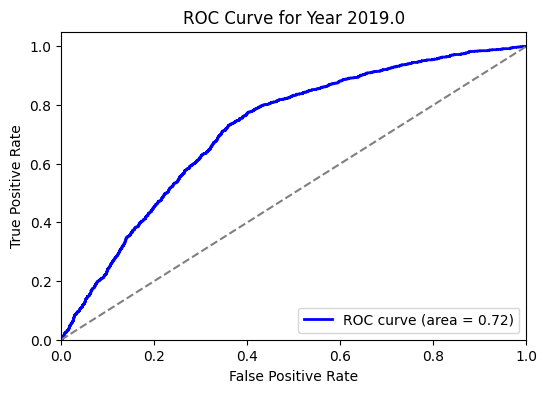


Variables más significativas para el año 2019.0:
                                              Feature  Importance
3                                            num__ROA    0.035737
5                            num__Generación Efectivo    0.032806
7      cat__Estado actual_ACUERDO DE REESTRUCTURACIÓN    0.020807
31  cat__Departamento de la dirección del domicili...    0.020778
45  cat__Departamento de la dirección del domicili...    0.020769
61  cat__Clasificación Industrial Internacional Un...    0.019503
38  cat__Departamento de la dirección del domicili...    0.019145
4                                            num__ROE    0.018530
29  cat__Departamento de la dirección del domicili...    0.018518
2                               num__Rotación cartera    0.018455




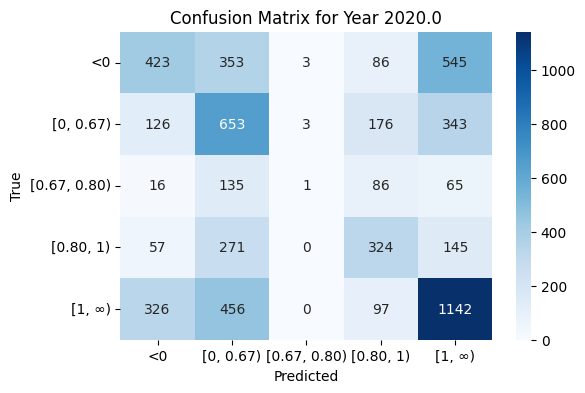

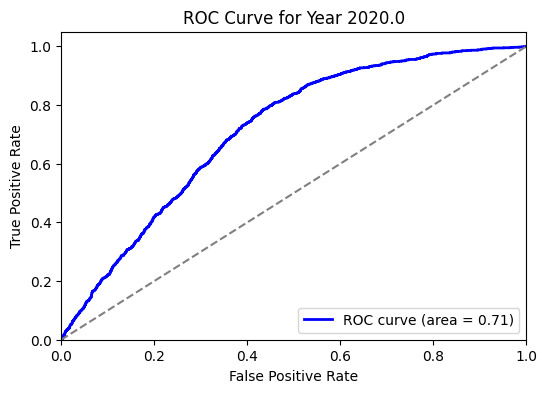


Variables más significativas para el año 2020.0:
                                              Feature  Importance
3                                            num__ROA    0.042599
5                            num__Generación Efectivo    0.039586
58  cat__Clasificación Industrial Internacional Un...    0.022183
21       cat__Tipo societario_02. SUCURSAL EXTRANJERA    0.019245
59  cat__Clasificación Industrial Internacional Un...    0.017970
1                                num__Razón corriente    0.017614
60  cat__Clasificación Industrial Internacional Un...    0.017424
57  cat__Clasificación Industrial Internacional Un...    0.017337
4                                            num__ROE    0.017284
33  cat__Departamento de la dirección del domicili...    0.017283




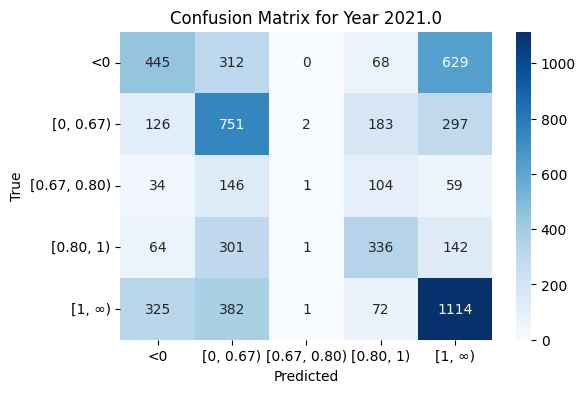

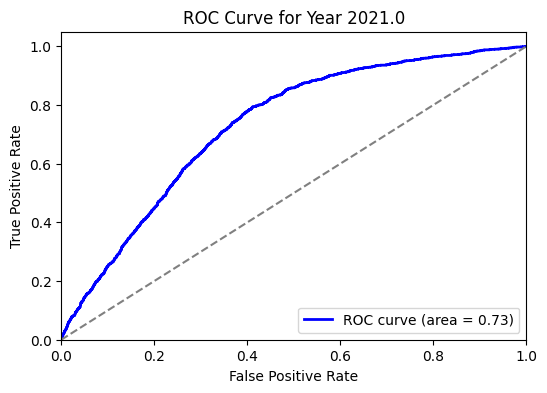


Variables más significativas para el año 2021.0:
                                              Feature  Importance
3                                            num__ROA    0.049371
5                            num__Generación Efectivo    0.045996
21       cat__Tipo societario_02. SUCURSAL EXTRANJERA    0.022456
58  cat__Clasificación Industrial Internacional Un...    0.020356
59  cat__Clasificación Industrial Internacional Un...    0.017725
1                                num__Razón corriente    0.017721
62  cat__Clasificación Industrial Internacional Un...    0.017433
4                                            num__ROE    0.017010
40  cat__Departamento de la dirección del domicili...    0.016884
23     cat__Tipo societario_04. SOCIEDAD EN COMANDITA    0.016851




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

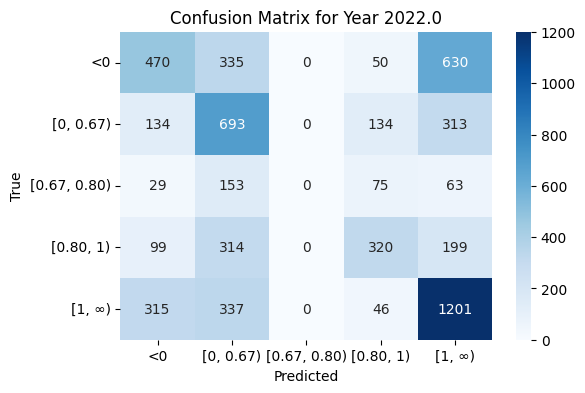

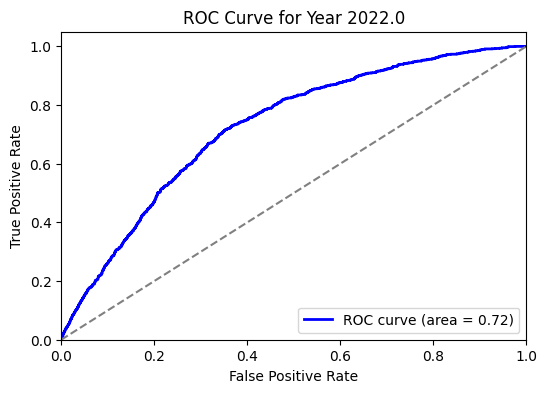


Variables más significativas para el año 2022.0:
                                              Feature  Importance
3                                            num__ROA    0.056461
5                            num__Generación Efectivo    0.055757
21       cat__Tipo societario_02. SUCURSAL EXTRANJERA    0.022677
58  cat__Clasificación Industrial Internacional Un...    0.021206
59  cat__Clasificación Industrial Internacional Un...    0.018234
1                                num__Razón corriente    0.017467
23     cat__Tipo societario_04. SOCIEDAD EN COMANDITA    0.017084
57  cat__Clasificación Industrial Internacional Un...    0.016877
6                           cat__Estado actual_ACTIVA    0.016688
2                               num__Rotación cartera    0.016435




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

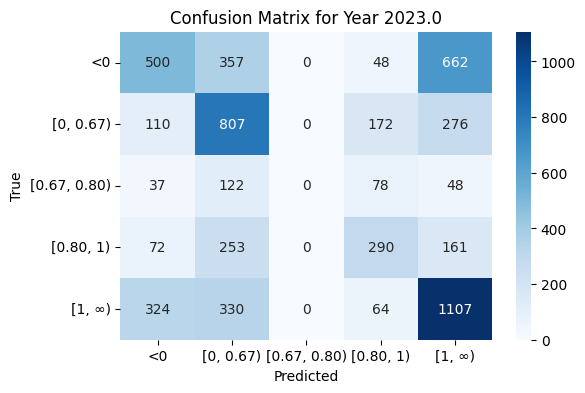

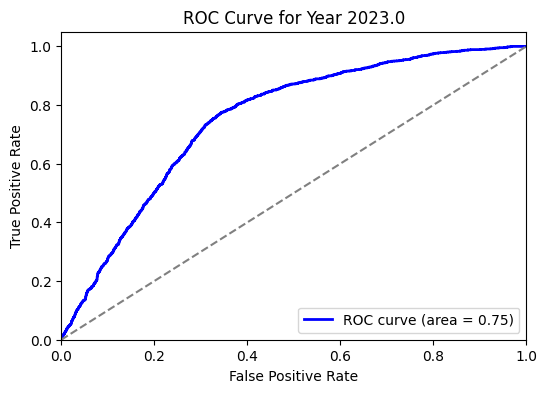


Variables más significativas para el año 2023.0:
                                              Feature  Importance
5                            num__Generación Efectivo    0.061721
3                                            num__ROA    0.060123
21       cat__Tipo societario_02. SUCURSAL EXTRANJERA    0.018980
58  cat__Clasificación Industrial Internacional Un...    0.018400
59  cat__Clasificación Industrial Internacional Un...    0.017878
6                           cat__Estado actual_ACTIVA    0.017624
14  cat__Concepto del Revisor fiscal en su orme_03...    0.016538
57  cat__Clasificación Industrial Internacional Un...    0.016499
1                                num__Razón corriente    0.016434
27  cat__Tipo societario_08. SOCIEDAD POR ACCIONES...    0.016397




In [ ]:
for i in range(1, len(years)):
    train_years = years[:i]  # Datos de entrenamiento hasta el año i-1
    test_year = years[i]     # Año para la prueba

    # Filtrar los datos de entrenamiento y prueba
    X_train = data_filter_imputed[data_filter_imputed['Fecha de Corte'].isin(train_years)].drop(columns=['FDC_FLC_categoria', 'Fecha de Corte', 'NIT'])
    y_train = data_filter_imputed[data_filter_imputed['Fecha de Corte'].isin(train_years)]['FDC_FLC_categoria']
    X_test = data_filter_imputed[data_filter_imputed['Fecha de Corte'] == test_year].drop(columns=['FDC_FLC_categoria', 'Fecha de Corte', 'NIT'])
    y_test = data_filter_imputed[data_filter_imputed['Fecha de Corte'] == test_year]['FDC_FLC_categoria']

    # Codificar las etiquetas de la variable objetivo para entrenamiento
    y_train_encoded = label_encoder.fit_transform(y_train)  # Codificar etiquetas de entrenamiento
    y_test_encoded = label_encoder.transform(y_test)  # Codificar etiquetas de prueba

    # Ajustar el modelo con los datos de entrenamiento y los mejores hiperparámetros
    pipeline.fit(X_train, y_train_encoded)

    # Realizar predicciones
    y_pred = pipeline.predict(X_test)

    # Calcular las métricas
    accuracy = accuracy_score(y_test_encoded, y_pred)
    roc_auc = roc_auc_score(y_test_encoded, pipeline.predict_proba(X_test), multi_class='ovr')
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')
    precision = precision_score(y_test_encoded, y_pred, average='weighted')
    recall = recall_score(y_test_encoded, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test_encoded, y_pred)
    class_report = classification_report(y_test_encoded, y_pred)

    # Almacenar resultados
    results['Year'].append(test_year)
    results['Accuracy'].append(accuracy)
    results['ROC AUC'].append(roc_auc)
    results['F1 Score'].append(f1)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['Confusion Matrix'].append(conf_matrix)
    results['Classification Report'].append(class_report)

    # Graficar la matriz de confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix for Year {test_year}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Graficar la curva ROC
    fpr, tpr, _ = roc_curve(y_test_encoded, pipeline.predict_proba(X_test)[:, 1], pos_label=1)  # Usamos la clase 1 como ejemplo
    roc_auc_val = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve for Year {test_year}")
    plt.legend(loc='lower right')
    plt.show()

    # Mostrar las variables más importantes para el año actual
    feature_importances = pipeline.named_steps['xgbclassifier'].feature_importances_

    # Obtener los nombres de las características del preprocesador
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=X_train.columns)

    # Crear un DataFrame con las importancias de características
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Ordenar por la importancia (de mayor a menor)
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Mostrar las 10 características más importantes
    print(f"\nVariables más significativas para el año {test_year}:")
    print(importance_df.head(10))
    print("\n")



**Métricas del modelo base XGBoost**

Si bien el modelo tiende a presentar un incremento considerable en la métrica de clasificación AUC-ROC no es adecuada u óptima con referencia a precision, recall, f1-score, por lo que requiere un ajuste en el clasificador.

`Año 2018:`
- Accuracy: 41.05%
- ROC AUC: 0.6768
- F1 Score: 0.3993
- Precision: 0.4018
- Recall: 0.4105

`Año 2019:`
- Accuracy: 43.75%
- ROC AUC: 0.7126
- F1 Score: 0.4252
- Precision: 0.4245
- Recall: 0.4375

`Año 2020:`
- Accuracy: 43.60%
- ROC AUC: 0.7171
- F1 Score: 0.4213
- Precision: 0.4275
- Recall: 0.4360

`Año 2021:`
- Accuracy: 44.90%
- ROC AUC: 0.7291
- F1 Score: 0.4295
- Precision: 0.4364
- Recall: 0.4490

`Año 2022:`
- Accuracy: 45.41%
- ROC AUC: 0.7234
- F1 Score: 0.4336
- Precision: 0.4355
- Recall: 0.4541

`Año 2023:`
- Accuracy: 46.48%
- ROC AUC: 0.7418
- F1 Score: 0.4447
- Precision: 0.4438
- Recall: 0.4648

In [ ]:
results_df = pd.DataFrame(results)
results_df.head(8)

Year  Accuracy   ROC AUC  F1 Score  Precision    Recall  \
0  2018.0  0.410495  0.676761  0.399334   0.401823  0.410495   
1  2019.0  0.437476  0.712623  0.425234   0.424524  0.437476   
2  2020.0  0.436043  0.717062  0.421313   0.427533  0.436043   
3  2021.0  0.449025  0.729090  0.429502   0.436361  0.449025   
4  2022.0  0.454146  0.723446  0.433580   0.435473  0.454146   
5  2023.0  0.464765  0.741806  0.444719   0.443802  0.464765   

                                    Confusion Matrix  \
0  [[428, 256, 1, 32, 441], [176, 356, 3, 92, 254...   
1  [[532, 295, 2, 47, 632], [191, 554, 2, 112, 29...   
2  [[423, 353, 3, 86, 545], [126, 653, 3, 176, 34...   
3  [[445, 312, 0, 68, 629], [126, 751, 2, 183, 29...   
4  [[470, 335, 0, 50, 630], [134, 693, 0, 134, 31...   
5  [[500, 357, 0, 48, 662], [110, 807, 0, 172, 27...   

                               Classification Report  
0                precision    recall  f1-score   ...  
1                precision    recall  f1-score   ...  
2                precision    recall  f1-score   ...  
3                precision    recall  f1-score   ...  
4                precision    recall  f1-score   ...  
5                precision    recall  f1-score   ...

In [ ]:
# Guardar el modelo y las métricas en un archivo pickle
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# Guardar el dataframe de resultados
results_df.to_pickle('model_results.pkl')

Graficamente se puede observar la estructura creada del primer árbol de clasificación que se realizó para mostrar de qué manera funciona XGBoost

<Figure size 2000x1000 with 0 Axes>

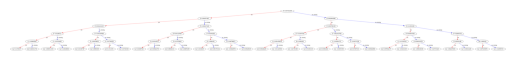

In [ ]:
# Extraer el modelo XGBoost ajustado del pipeline
xgb_model = pipeline.named_steps['xgbclassifier']

plt.figure(figsize=(20, 10))  # Tamaño de la figura
xgb.plot_tree(xgb_model, num_trees=0)  # num_trees=0 selecciona el primer árbol
plt.show()

<Figure size 2000x1000 with 0 Axes>

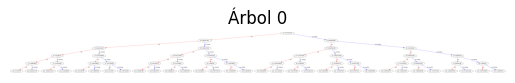

<Figure size 2000x1000 with 0 Axes>

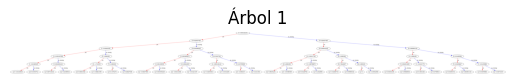

<Figure size 2000x1000 with 0 Axes>

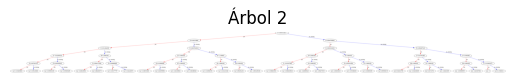

<Figure size 2000x1000 with 0 Axes>

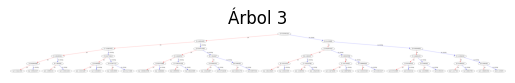

<Figure size 2000x1000 with 0 Axes>

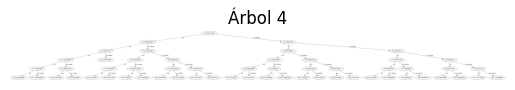

In [ ]:
for i in range(5):  # Ajusta el número de árboles que deseas visualizar
    plt.figure(figsize=(20, 10))
    xgb.plot_tree(xgb_model, num_trees=i)
    plt.title(f'Árbol {i}')
    plt.show()

In [ ]:
import xgboost as xgb
import graphviz

# Extraer el modelo XGBoost ajustado del pipeline
xgb_model = pipeline.named_steps['xgbclassifier']

# Generar la visualización del primer árbol del modelo
dot = xgb.to_graphviz(xgb_model, num_trees=0)  # num_trees=0 selecciona el primer árbol

# Renderizar el árbol con Graphviz
dot.render('tree', format='png', cleanup=True)  # Guardar la imagen como archivo PNG
dot.view('tree')  # Abrir la imagen generada


'tree.pdf'

#### Importancia de las variables

Se realiza el entrenamiento y verificación de las variables que más aportan a la clasificación de las categorías en los perioddo 2017 a 2023. Se observa que Las barras horizontales representan el peso relativo de cada variable en el modelo en diferentes períodos, destacando:
1.	Cantidad de años de la empresa: Es consistentemente la variable más importante, con una alta influencia en todos los años analizados.
2.	Razón corriente y Rotación cartera: También tienen un impacto relevante, aunque con menor peso en comparación con la anterior.
3.	ROA (Rentabilidad sobre activos) y ROE (Rentabilidad sobre capital): Mantienen un peso intermedio pero constante en los años

In [ ]:
importance_df = pd.DataFrame()
all_categories = data_filter_imputed['FDC_FLC_categoria'].unique()
label_encoder = LabelEncoder().fit(all_categories)

# Validación secuencial
for i in range(1, len(years)):
    train_years = years[:i]
    test_year = years[i]

    X_train = data_filter_imputed[data_filter_imputed['Fecha de Corte'].isin(train_years)].drop(columns=['FDC_FLC_categoria', 'Fecha de Corte', 'NIT'])
    y_train = data_filter_imputed[data_filter_imputed['Fecha de Corte'].isin(train_years)]['FDC_FLC_categoria']

    y_train_encoded = label_encoder.transform(y_train)

    pipeline.fit(X_train, y_train_encoded)

    xgb_model = pipeline.named_steps['xgbclassifier']
    feature_importance = xgb_model.feature_importances_

    importance = pd.DataFrame({
        'Variable': X_train.columns,
        'Importancia': feature_importance[:len(X_train.columns)]
    })

    importance['Año'] = test_year
    importance_df = pd.concat([importance_df, importance])

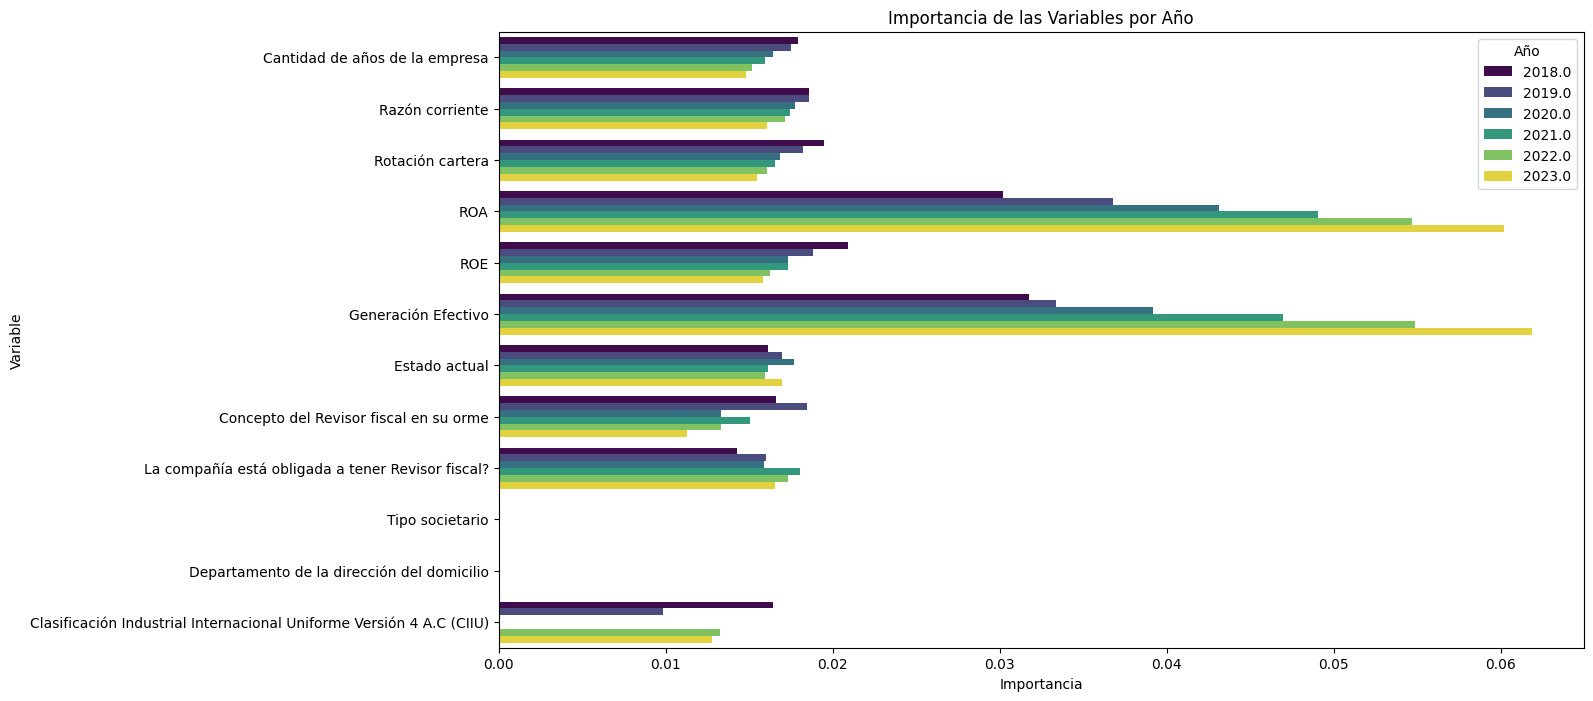

In [ ]:
# Graficar la importancia de las variables para cada año
plt.figure(figsize=(14, 8))
sns.barplot(data=importance_df, x='Importancia', y='Variable', hue='Año', orient='h', palette="viridis")
plt.title('Importancia de las Variables por Año')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.legend(title='Año')
plt.show()

La gráfica muestra la tendencia de la importancia promedio de las variables en el modelo durante el periodo 2018-2023. Algunas observaciones clave son:
1.	Variables con aumento constante:
	-	Cantidad de años de la empresa y Estado actual muestran una tendencia creciente, consolidándose como las variables más importantes en los últimos años.
2.	Estabilidad relativa:
	-	Razón corriente, Rotación cartera, ROA y ROE mantienen una importancia consistente a lo largo del tiempo, sin cambios significativos.
3.	Impacto mínimo o decreciente:
	-	Variables como Tipo societario y Clasificación industrial internacional uniforme (CIIU) presentan importancia nula o mínima, lo que indica que su relevancia para el modelo es marginal o inexistente.
4.	Fluctuaciones menores:
	-	Algunas variables, como Generación de efectivo y Concepto del Revisor fiscal en su informe, muestran ligeros cambios de importancia entre años, pero su influencia global sigue siendo moderada.


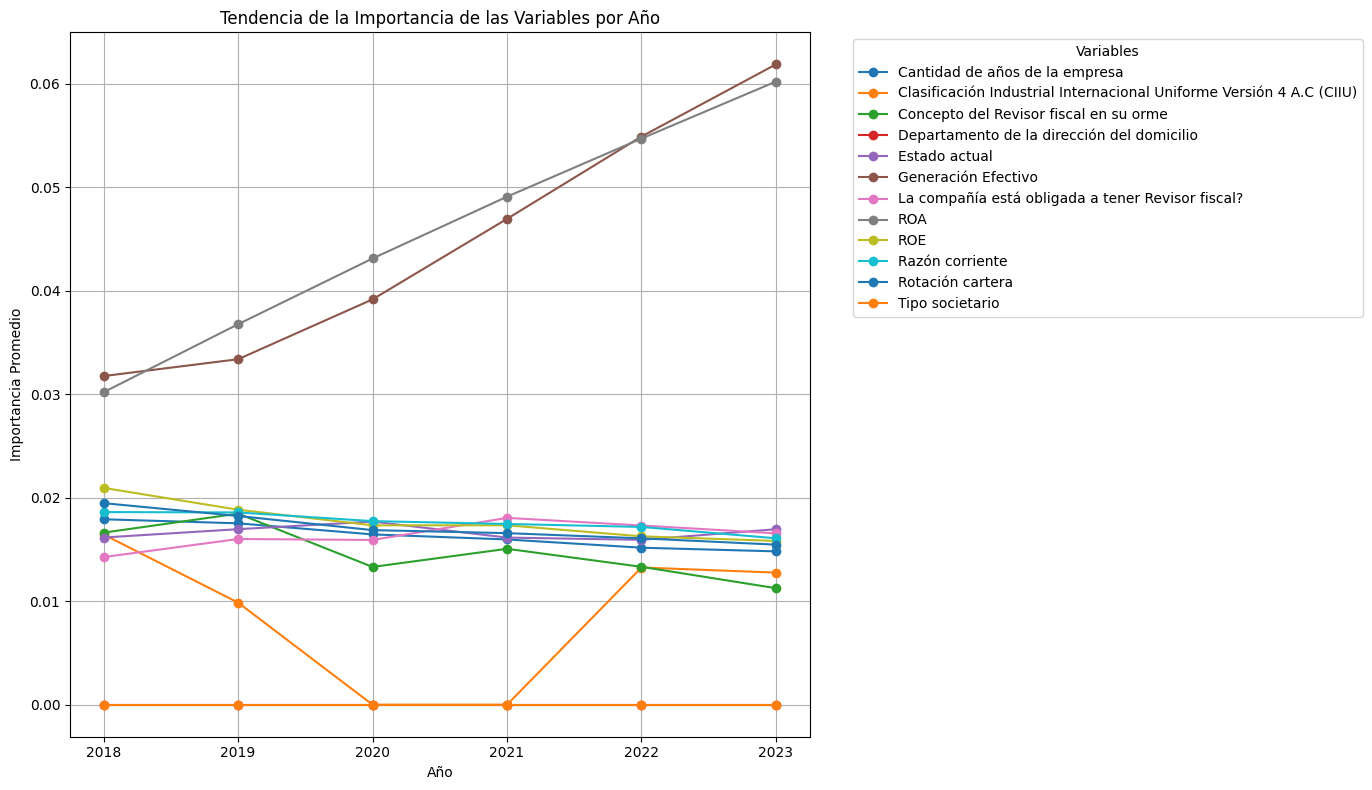

In [ ]:
# Crear un DataFrame para almacenar la importancia promedio por variable a lo largo de los años
importance_trend_df = importance_df.groupby(['Año', 'Variable'], as_index=False)['Importancia'].mean()

# Graficar la tendencia de la importancia de las variables
plt.figure(figsize=(14, 8))

# Graficar múltiples líneas para cada variable
for variable in importance_trend_df['Variable'].unique():
    variable_data = importance_trend_df[importance_trend_df['Variable'] == variable]
    plt.plot(variable_data['Año'], variable_data['Importancia'], label=variable, marker='o')

# Personalización de la gráfica
plt.title('Tendencia de la Importancia de las Variables por Año')
plt.xlabel('Año')
plt.ylabel('Importancia Promedio')
plt.legend(title='Variables', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Selección de empresas por categoría

Se elige al azar una empresa de cada categoría para analizar que variables infuyeron en su clasificación.

In [ ]:
categorias = data_filter_imputed['FDC_FLC_categoria'].unique()

# Seleccionar una empresa aleatoria por cada categoría
empresas_aleatorias = {}
for categoria in categorias:
    empresas_categoria = data_filter_imputed[data_filter_imputed['FDC_FLC_categoria'] == categoria]
    empresa_aleatoria = random.choice(empresas_categoria['NIT'].unique())  # Asumo que 'NIT' es el identificador de la empresa
    empresas_aleatorias[categoria] = empresa_aleatoria

Las variable spara cada categoría que tienden a reprtirse entre la smismas son similares a las variables generales.

- Generación de efectivo y ROA son de tendencia creciente constante y se ctalogan como las más importantes en todos lso grupos dado su tendencia alza y alta densidad de aporte en todas las categorías.

<ipython-input-178-64e73a87833f>:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




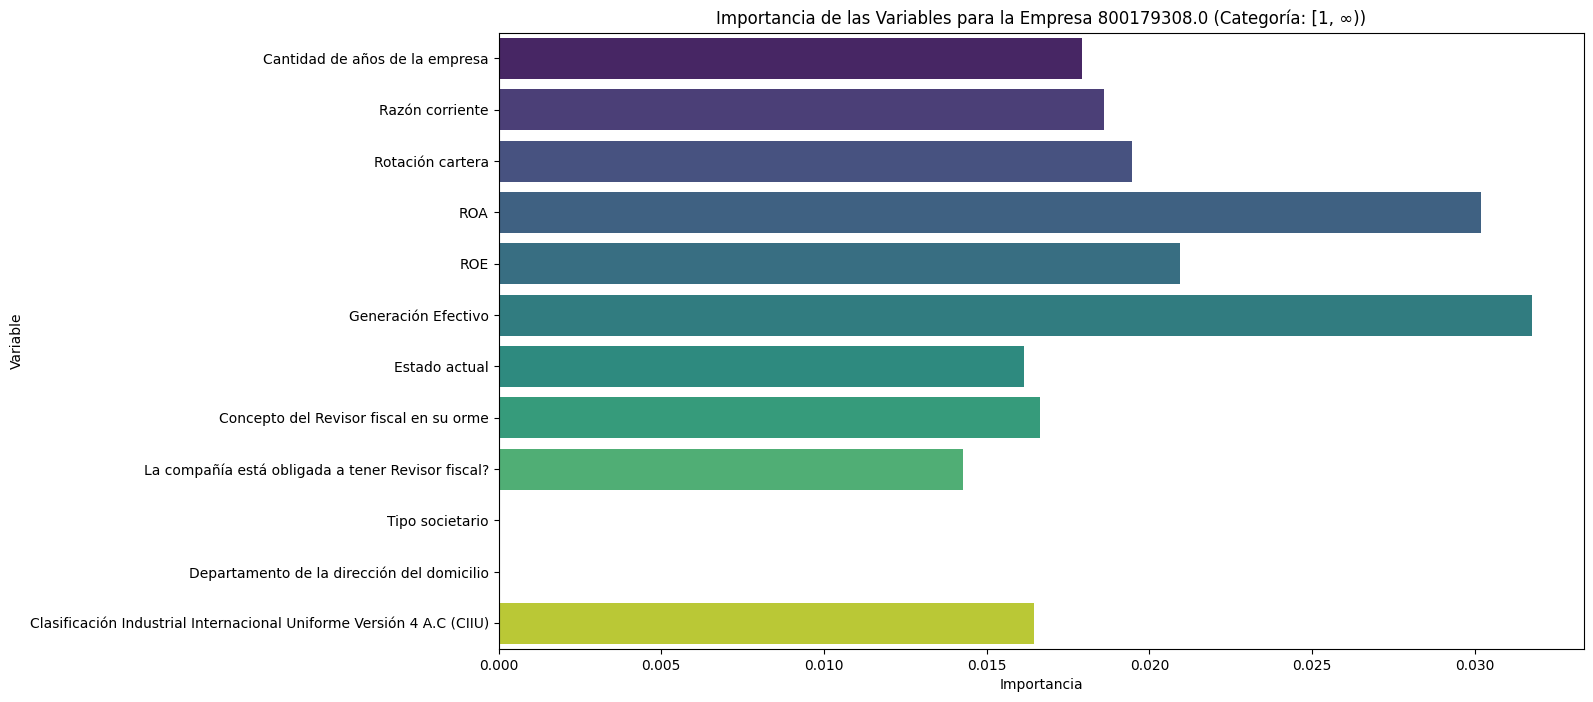

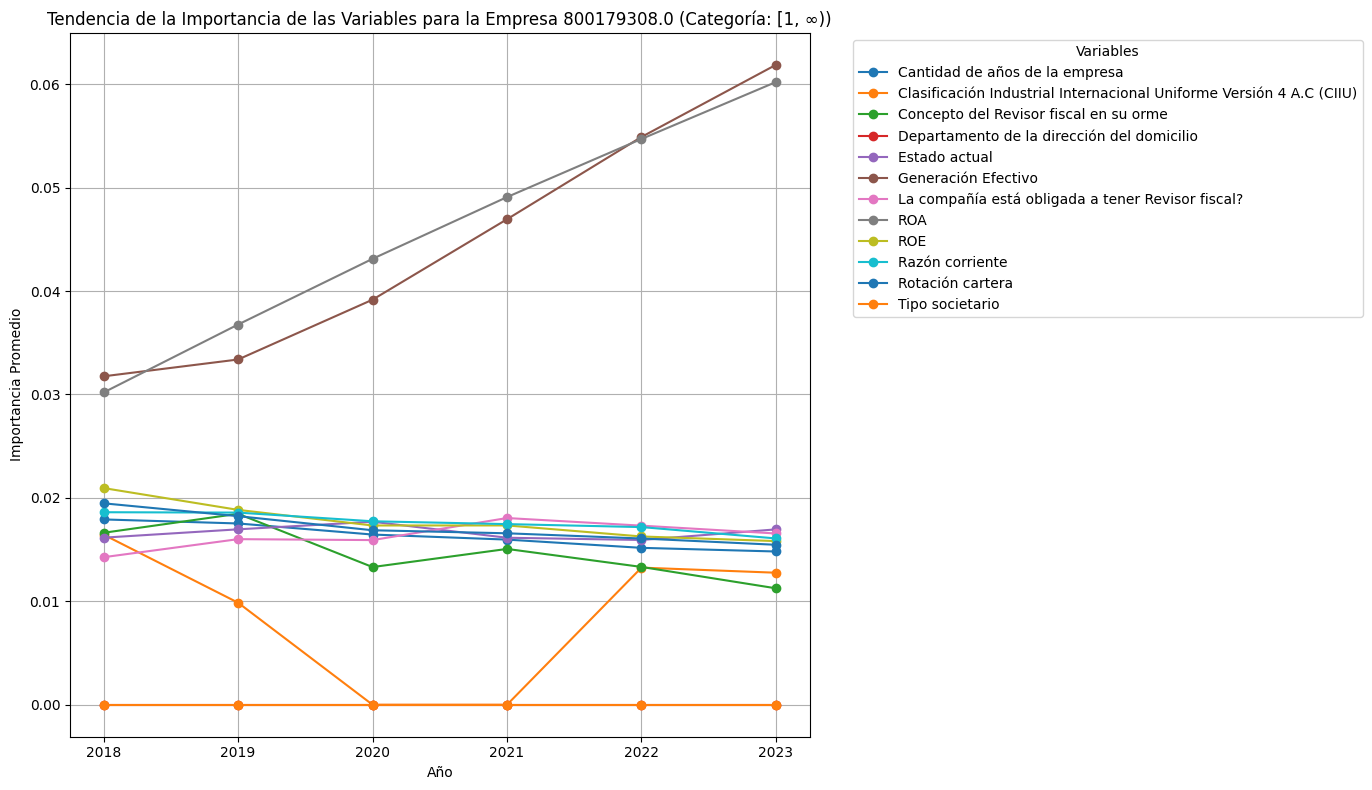

<ipython-input-178-64e73a87833f>:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




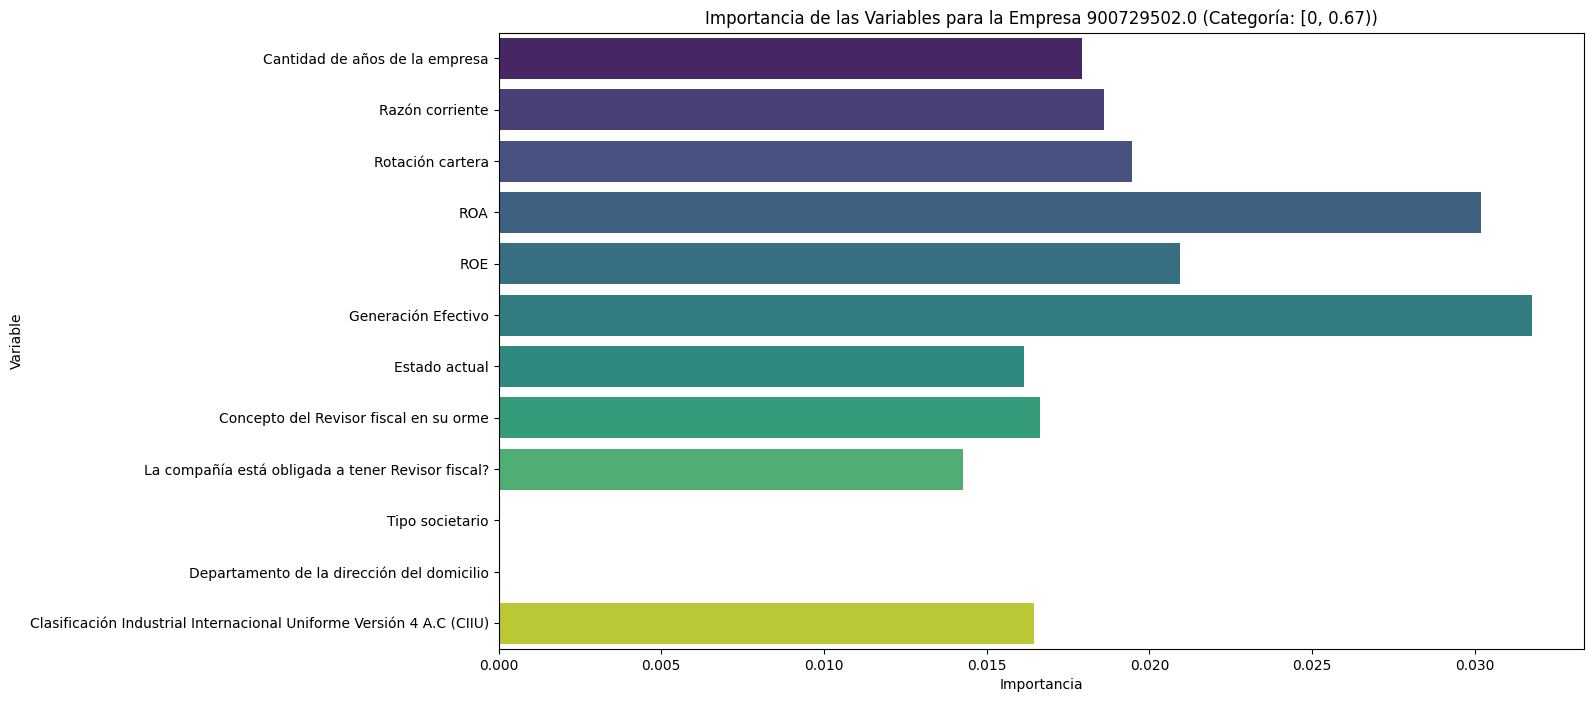

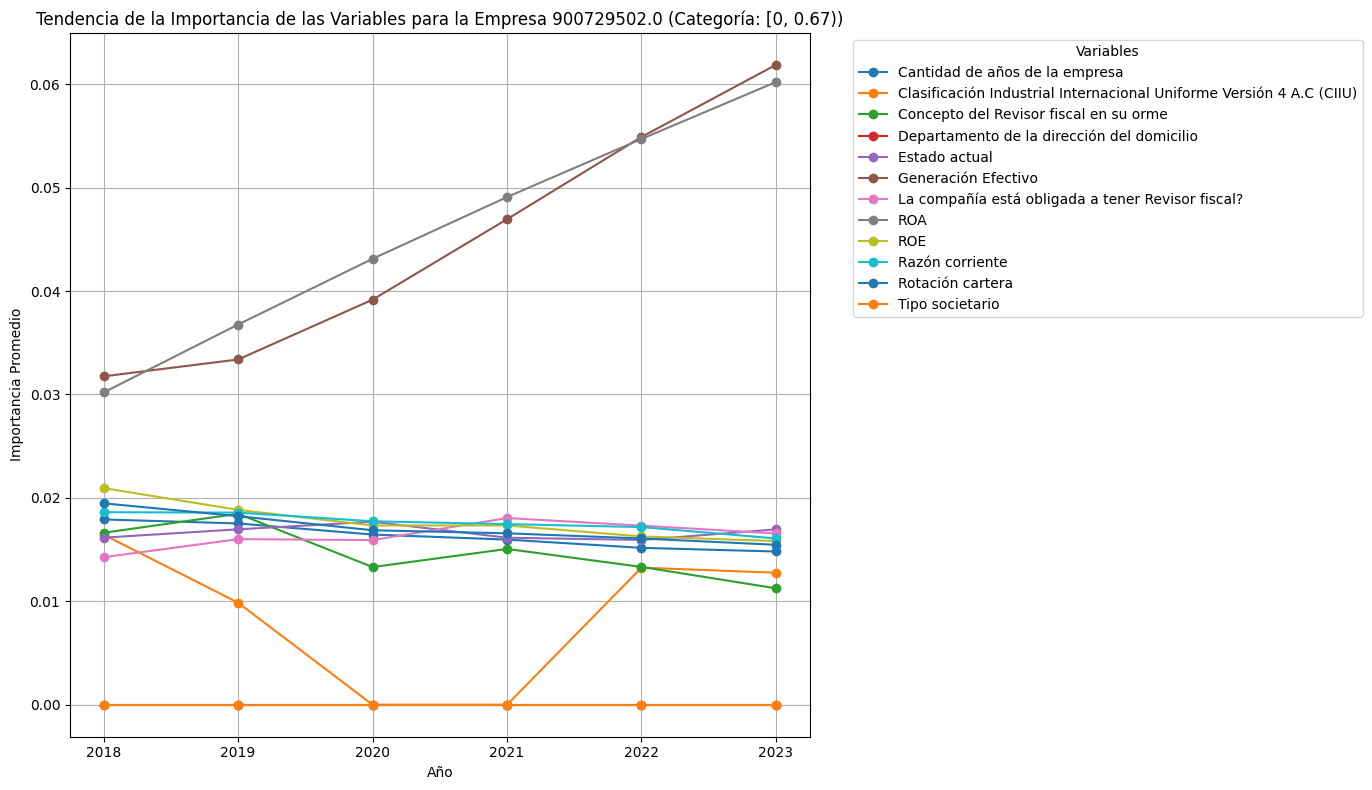

<ipython-input-178-64e73a87833f>:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




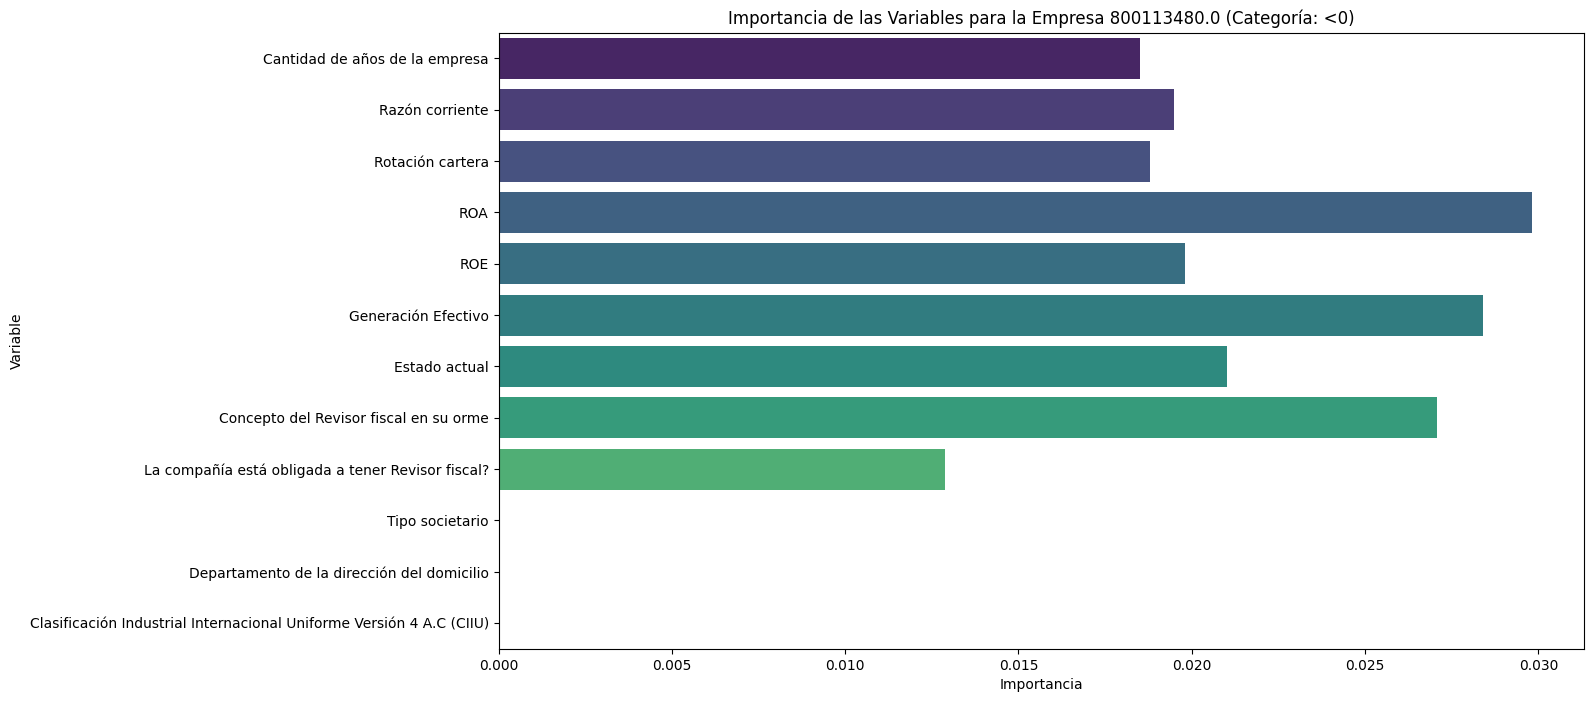

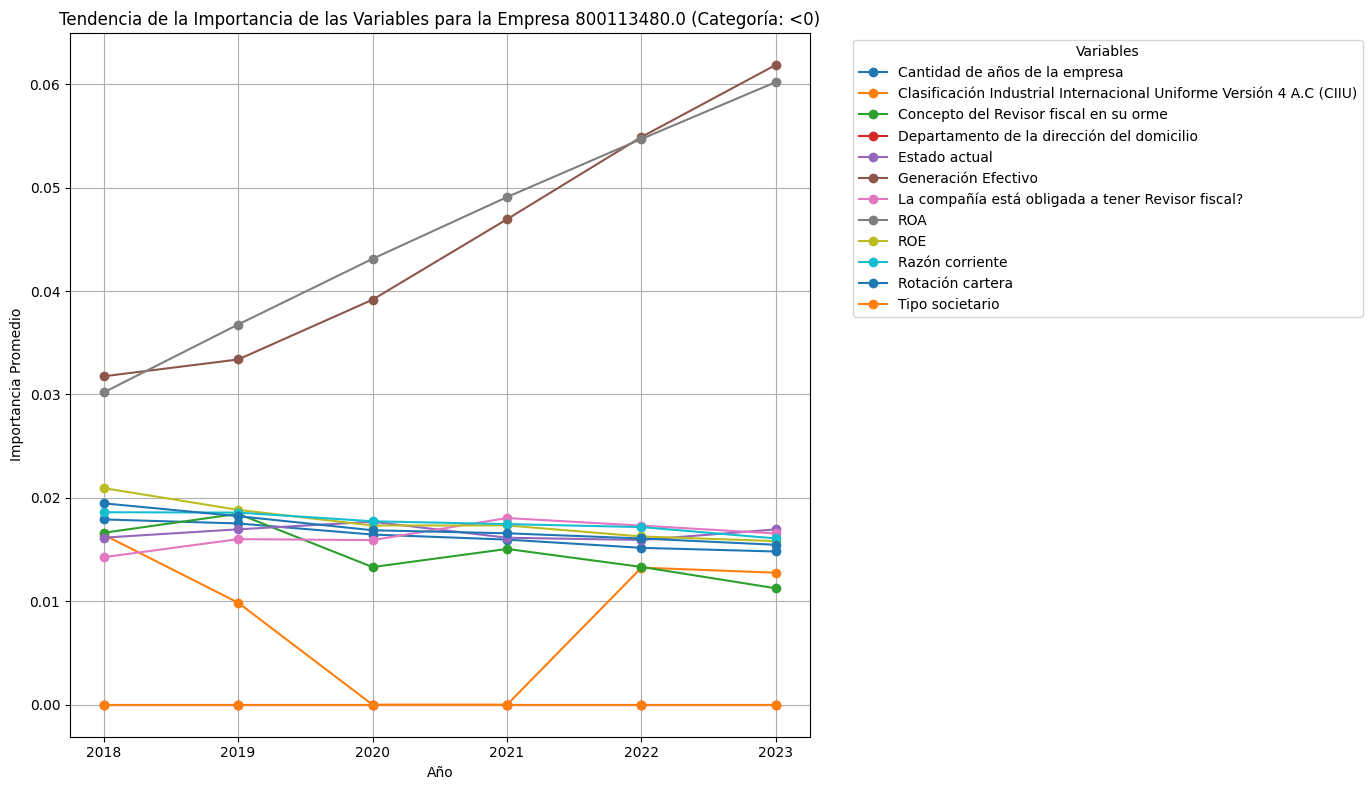

<ipython-input-178-64e73a87833f>:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




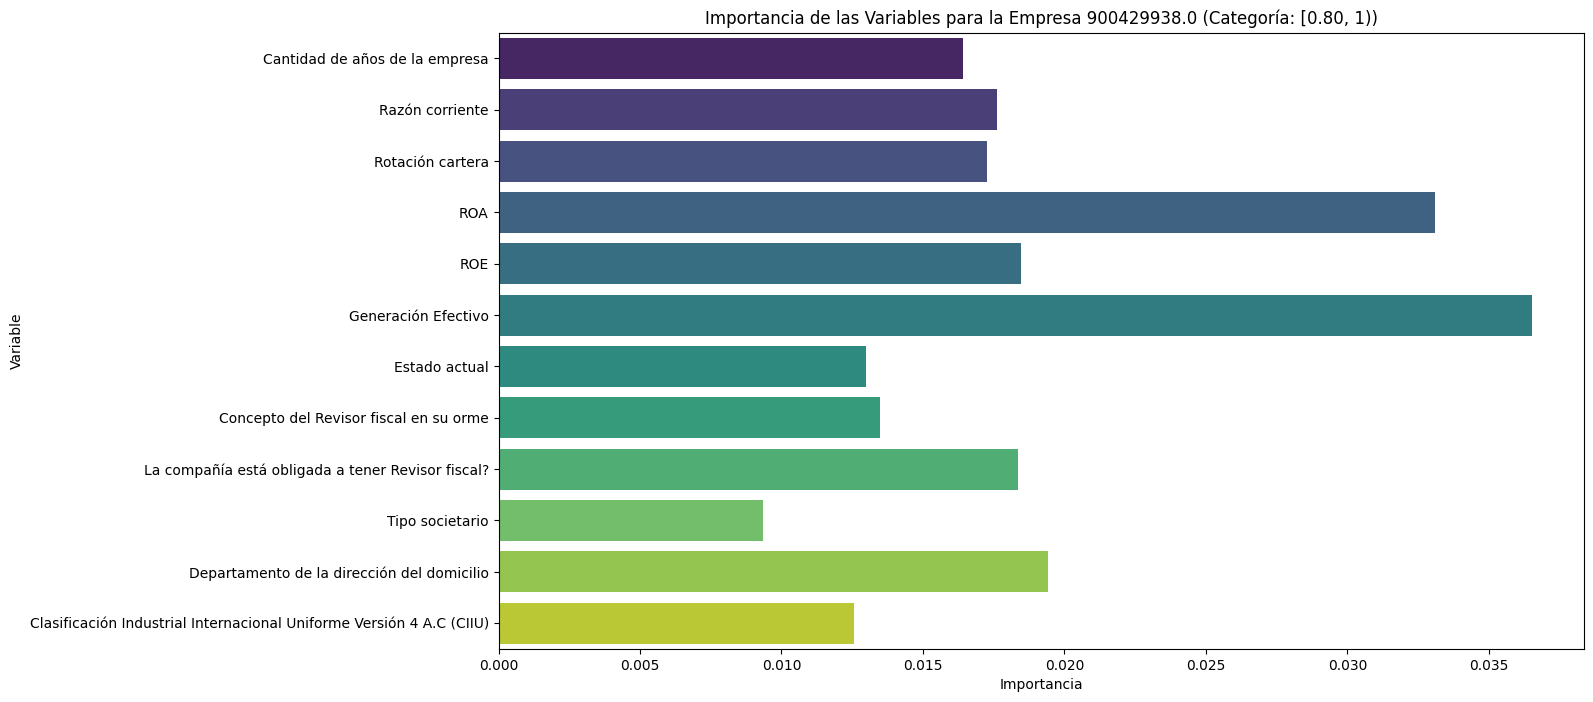

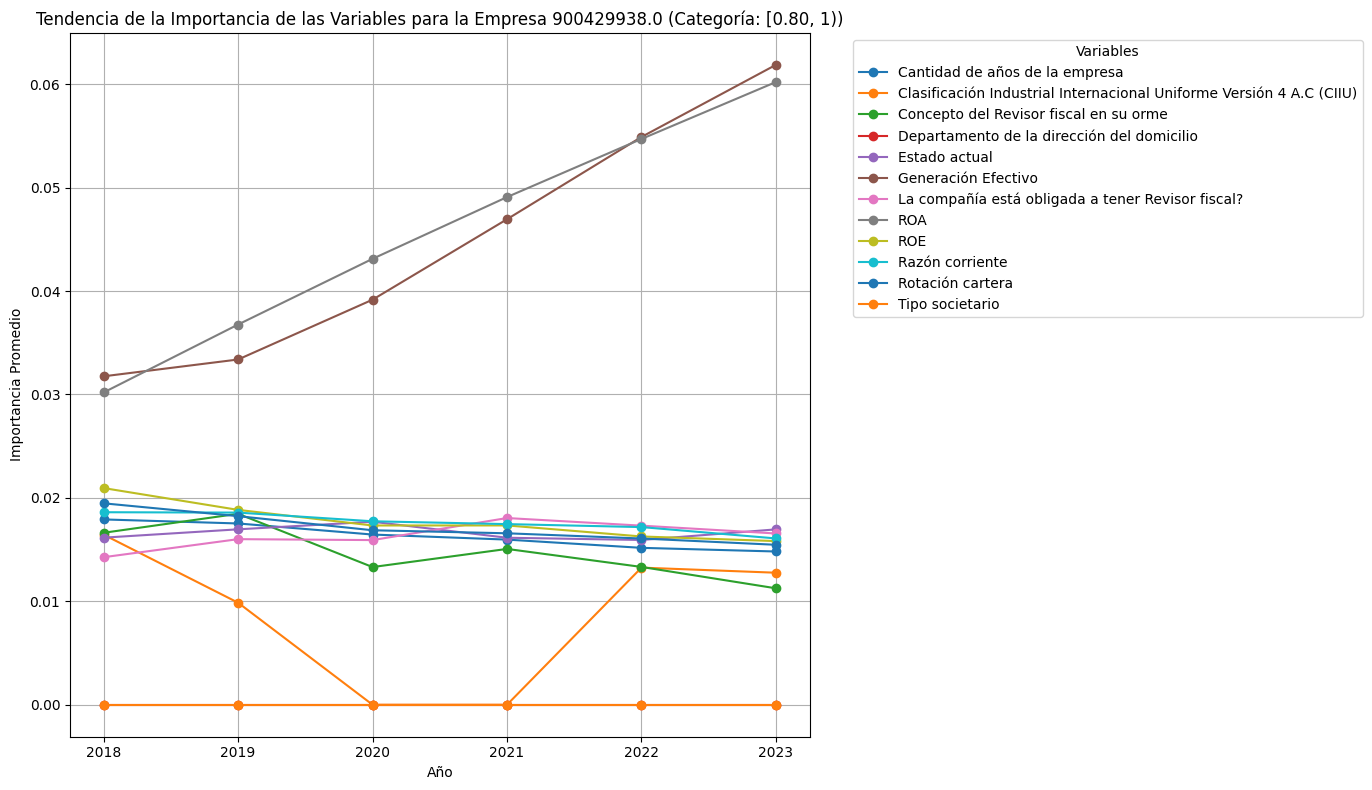

<ipython-input-178-64e73a87833f>:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




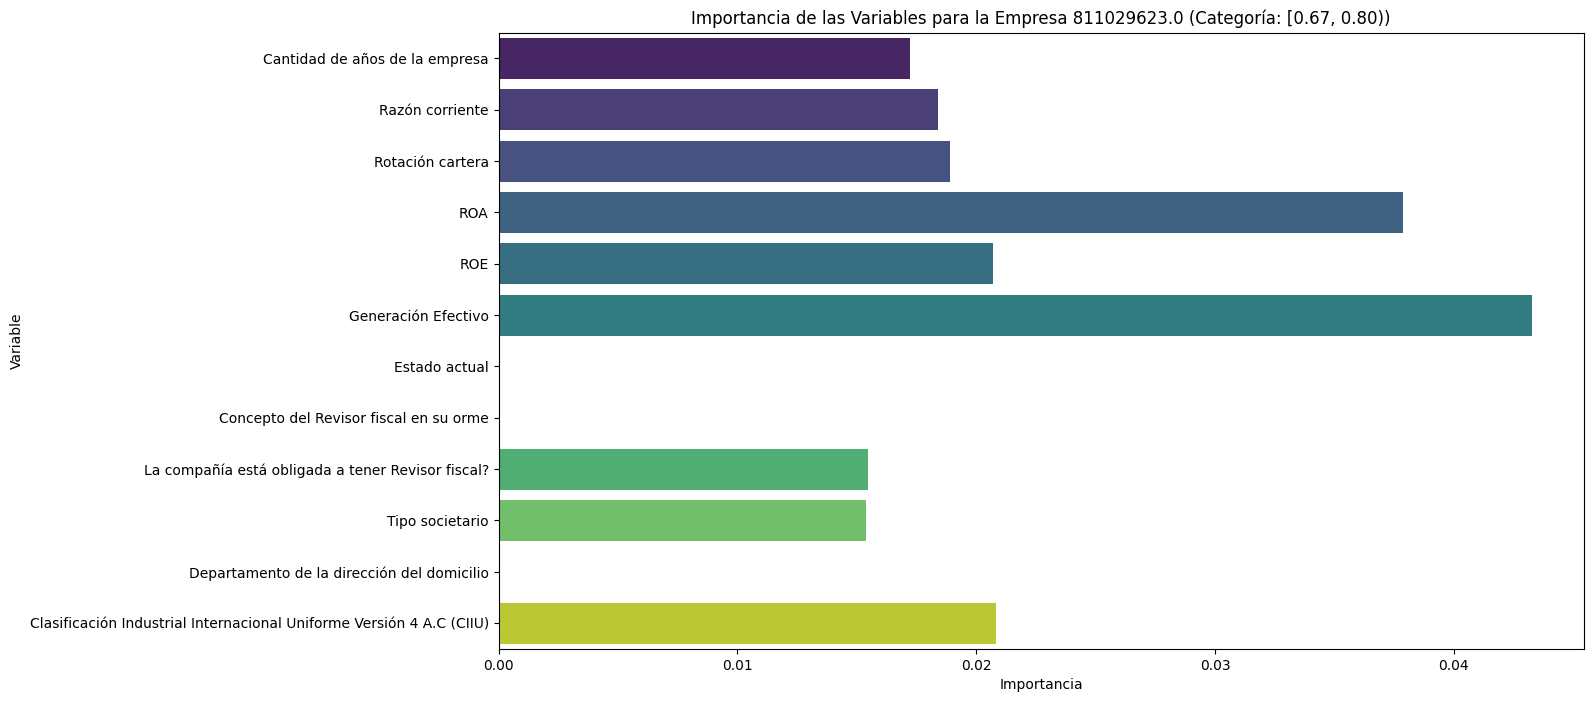

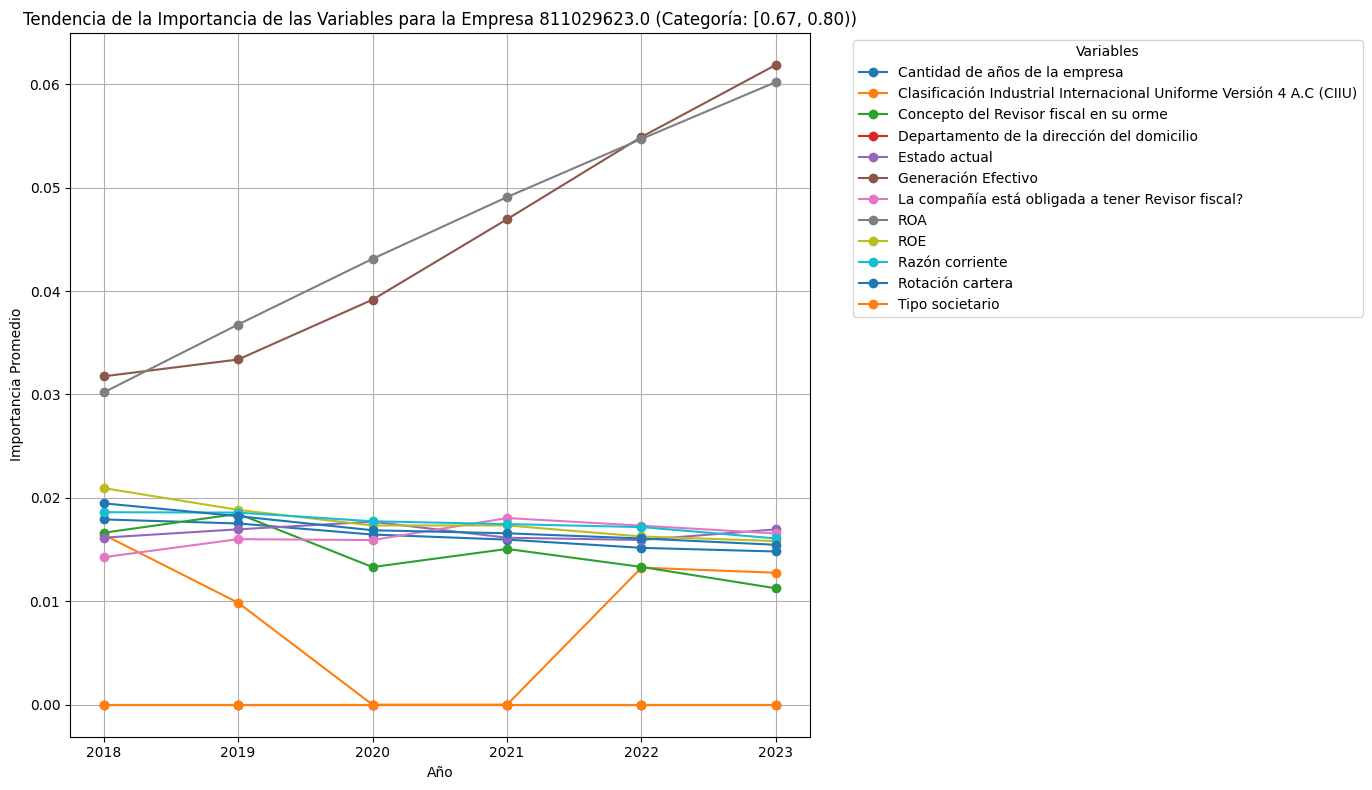

In [ ]:
for categoria, empresa in empresas_aleatorias.items():
    empresa_data = data_filter_imputed[data_filter_imputed['NIT'] == empresa]
    empresa_year = empresa_data['Fecha de Corte'].iloc[0]

    X_train = data_filter_imputed[data_filter_imputed['Fecha de Corte'] == empresa_year].drop(columns=['FDC_FLC_categoria', 'Fecha de Corte', 'NIT'])
    y_train = data_filter_imputed[data_filter_imputed['Fecha de Corte'] == empresa_year]['FDC_FLC_categoria']

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)


    # Ajustar el modelo con los mejores hiperparámetros de XGBoost
    pipeline.fit(X_train, y_train_encoded)

    # Extract variable importances from the fitted model
    xgb_model = pipeline.named_steps['xgbclassifier']
    feature_importance = xgb_model.feature_importances_


    importance = pd.DataFrame({
        'Variable': X_train.columns,
        'Importancia': feature_importance[:len(X_train.columns)]
    })

    # Graficar la importancia de las variables (Feature Importance)
    plt.figure(figsize=(14, 8))
    sns.barplot(data=importance, x='Importancia', y='Variable', orient='h', palette="viridis")
    plt.title(f"Importancia de las Variables para la Empresa {empresa} (Categoría: {categoria})")
    plt.xlabel('Importancia')
    plt.ylabel('Variable')
    plt.show()

    # Graficar la tendencia de la importancia de las variables por año
    importance_trend_df = importance_df.groupby(['Año', 'Variable'], as_index=False)['Importancia'].mean()

    # Filtrar solo las importancias para esa empresa
    plt.figure(figsize=(14, 8))

    # Graficar múltiples líneas para cada variable
    for variable in importance_trend_df['Variable'].unique():
        variable_data = importance_trend_df[importance_trend_df['Variable'] == variable]
        plt.plot(variable_data['Año'], variable_data['Importancia'], label=variable, marker='o')

    plt.title(f"Tendencia de la Importancia de las Variables para la Empresa {empresa} (Categoría: {categoria})")
    plt.xlabel('Año')
    plt.ylabel('Importancia Promedio')
    plt.legend(title='Variables', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Supuestos del modelo

Inicialmente se obtienen las probabilidades de clasificación de las clases mal clasificadas y a esto se le denomina residuos del modleo, ya que no es un problema de regresión.

In [ ]:
# Realizamos predicciones utilizando el modelo LightGBM
y_pred_proba = pipeline.predict_proba(X_train)  # Probabilidades para todas las clases

# Obtener las clases predichas (la clase con mayor probabilidad)
y_pred_final = np.argmax(y_pred_proba, axis=1)

# Residuos en clasificación: calculamos la diferencia entre la probabilidad de la clase correcta y 1
residuals = []
for i in range(len(y_test_encoded)):
    # Access element using integer indexing for NumPy arrays
    true_class = y_test_encoded[i]
    predicted_prob = y_pred_proba[i, true_class]
    residuals.append(1 - predicted_prob)  # Residuo como diferencia entre 1 y la probabilidad de la clase correcta

residuals = np.array(residuals)

#### Independencia de las observaciones
Se realiza un gráfico de autocorrelación para verificar que no existe dependencia entre las observaciones de un grupo determinado en el pliege de validación (2017-2018, 2017+2018-2019, 2017+2018+2019-2020,..., 2023).

Se concluye que no existe correlación entre las mismas dado el estadístico de prueba durbin-watson cercano a 3 (1.9574).

In [ ]:
# Verificación de autocorrelación con Durbin-Watson
dw_stat = durbin_watson(residuals)
print(f"Estadístico de Durbin-Watson: {dw_stat}")

# Interpretación:
# Un valor cercano a 2 sugiere que no hay autocorrelación.
# Un valor cercano a 0 o 4 sugiere autocorrelación positiva o negativa respectivamente.

Estadístico de Durbin-Watson: 1.9574365674207523


**Gráfica autocorrelación**

<Figure size 1200x600 with 0 Axes>

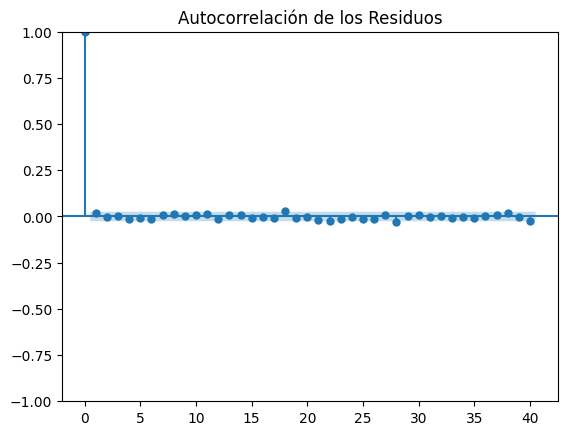

In [ ]:
plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=40)
plt.title("Autocorrelación de los Residuos")
plt.show()

#### **Estacionariedad de las series temporales**



Se verifica que los datos, al haber sido separados por pliegues de validación secuencial anual cumplen con el supuesto de estacionariedad. En este caso las probabilidades de la clasificación cumplen con el supuesto de estacionariedad temporal en el plazo de la serie temporal (2017 - 2023) para cada variable de la muestra.

- **Cantidad de años de la empresa**:
  - Estadístico ADF: -2.37
  - Valor p: 0.149
  - **Conclusión**: La serie **NO es estacionaria**.

- **Razón corriente**:
  - Estadístico ADF: -76.36
  - Valor p: 0.00
  - **Conclusión**: La serie **es estacionaria**.

- **Rotación cartera**:
  - Estadístico ADF: -32.75
  - Valor p: 0.00
  - **Conclusión**: La serie **es estacionaria**.

- **ROA**:
  - Estadístico ADF: -75.99
  - Valor p: 0.00
  - **Conclusión**: La serie **es estacionaria**.

- **ROE**:
  - Estadístico ADF: -76.27
  - Valor p: 0.00
  - **Conclusión**: La serie **es estacionaria**.

- **Generación Efectivo**:
  - Estadístico ADF: -76.26
  - Valor p: 0.00
  - **Conclusión**: La serie **es estacionaria**.

- **Estado actual**:
  - La columna no es numérica, se omite el test ADF.

- **Concepto del Revisor fiscal en su orme**:
  - La columna no es numérica, se omite el test ADF.

- **La compañía está obligada a tener Revisor fiscal?**:
  - La columna no es numérica, se omite el test ADF.

- **Tipo societario**:
  - La columna no es numérica, se omite el test ADF.

- **Departamento de la dirección del domicilio**:
  - La columna no es numérica, se omite el test ADF.

- **Clasificación Industrial Internacional Uniforme Versión 4 A.C (CIIU)**:
  - La columna no es numérica, se omite el test ADF.

  Se concluye que la muestra y el modelo si cumplen con el supuesto de estacionariedad en los pliegues de validación implementados.

In [ ]:
# Realizar el test ADF para verificar la estacionariedad
def test_stationarity(data):
    # Check if the data is numeric
    if pd.api.types.is_numeric_dtype(data):
        adf_result = adfuller(data)
        print(f"Estadístico ADF: {adf_result[0]}")
        print(f"Valor p: {adf_result[1]}")
        if adf_result[1] < 0.05:
            print("La serie es estacionaria")
        else:
            print("La serie NO es estacionaria")
    else:
        print("La columna no es numérica, se omite el test ADF.")

# Test de estacionariedad para cada variable
for col in X_train.columns:
    print(f"\nTest de estacionariedad para {col}:")
    test_stationarity(X_train[col])


Test de estacionariedad para Cantidad de años de la empresa:
Estadístico ADF: -2.3745309725169457
Valor p: 0.14905424766713893
La serie NO es estacionaria

Test de estacionariedad para Razón corriente:
Estadístico ADF: -76.35597974491998
Valor p: 0.0
La serie es estacionaria

Test de estacionariedad para Rotación cartera:
Estadístico ADF: -32.748816390000094
Valor p: 0.0
La serie es estacionaria

Test de estacionariedad para ROA:
Estadístico ADF: -75.98509967178781
Valor p: 0.0
La serie es estacionaria

Test de estacionariedad para ROE:
Estadístico ADF: -76.27014026793795
Valor p: 0.0
La serie es estacionaria

Test de estacionariedad para Generación Efectivo:
Estadístico ADF: -76.26289139137445
Valor p: 0.0
La serie es estacionaria

Test de estacionariedad para Estado actual:
La columna no es numérica, se omite el test ADF.

Test de estacionariedad para Concepto del Revisor fiscal en su orme:
La columna no es numérica, se omite el test ADF.

Test de estacionariedad para La compañía es

#### Verificar poca o nula multicolinealidad

Se verifica mediante el calculo del factor de inflación de la varianza si existe alguna correlación entre las variables numéricas del conjunto de datos. Si el VIF > 10 se considera existencia de multicolinealidad.

Dado que no existe correlación numerica significativa ni directa ni inversa y que el VIF < 10 para todas las variables numéricas implementadas en el modelo se concluye que no hay multicolinealidad, por tanto se cumple el supuesto.

In [ ]:
# Calcular VIF para las variables en X_train
X_train_vif = sm.add_constant(X_train)  # Agregar constante para el cálculo de VIF

# Convertir todas las columnas a numéricas si es posible, o manejar las no numéricas
for col in X_train_vif.columns:
    if not pd.api.types.is_numeric_dtype(X_train_vif[col]):
        try:
            # Intentar convertir la columna a numérica
            X_train_vif[col] = pd.to_numeric(X_train_vif[col], errors='raise')
        except ValueError:
            # Manejar columnas que no se pueden convertir, por ejemplo, eliminándolas o usando codificación one-hot
            print(f"Columna '{col}' no es numérica y no se puede convertir. Se eliminará para el cálculo del VIF.")
            X_train_vif = X_train_vif.drop(columns=[col])
            # Si la columna es categórica, podrías usar pd.get_dummies() para codificación one-hot

vif_data = pd.DataFrame()
vif_data["Variable"] = X_train_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]

# Mostrar VIF
print(vif_data)

Columna 'Estado actual' no es numérica y no se puede convertir. Se eliminará para el cálculo del VIF.
Columna 'Concepto del Revisor fiscal en su orme' no es numérica y no se puede convertir. Se eliminará para el cálculo del VIF.
Columna 'La compañía está obligada a tener Revisor fiscal?' no es numérica y no se puede convertir. Se eliminará para el cálculo del VIF.
Columna 'Tipo societario' no es numérica y no se puede convertir. Se eliminará para el cálculo del VIF.
Columna 'Departamento de la dirección del domicilio' no es numérica y no se puede convertir. Se eliminará para el cálculo del VIF.
Columna 'Clasificación Industrial Internacional Uniforme Versión 4 A.C (CIIU)' no es numérica y no se puede convertir. Se eliminará para el cálculo del VIF.
                         Variable       VIF
0                           const  3.821990
1  Cantidad de años de la empresa  1.002266
2                 Razón corriente  1.010389
3                Rotación cartera  1.015201
4                    

#### Homocedasticidad de las probabilidades extraídas de los residuos

Se verifica que la distribución o el comportamiento de las probabilidaes de los residuos de clasificación tienen una varianza homogenea o constante. Se selecciona incialmente las variables numéricas dle conjunto de datos .

In [ ]:
# Paso 1: Filtrar las columnas numéricas (excluir las categóricas)
X_train_numeric = X_train.select_dtypes(include=['number'])

# Verificar que X_train_numeric ahora solo contiene variables numéricas
print(X_train_numeric.head())

        Cantidad de años de la empresa  Razón corriente  Rotación cartera  \
118882                            36.0         1.212657         29.189779   
118883                            36.0         5.290916         74.292334   
118884                            36.0         3.300313         37.662737   
118885                            36.0         2.139800        170.064847   
118892                            36.0         1.801147         46.734369   

             ROA       ROE  Generación Efectivo  
118882  0.050954  0.137577             0.136177  
118883  0.003609  0.005455            -0.550855  
118884  0.110797  0.202389            -0.925603  
118885  0.187122  0.340824            -0.108914  
118892  0.010222  0.020959             5.897421  


Haciendo uso del estadístico del test de breush-pagan se concluye que dado `p-valor (0.6817)` mayor a cualquier nivel de significancia (`alfa`) las probabilidades tienen una varianza homocedastica, pr lo tanto cumple con el supuesto.

In [ ]:
# import statsmodels.formula.api as smf
# import statsmodels.stats.api as sms

# Realizar el test de heterocedasticidad de Breusch-Pagan con las variables numéricas
X_train_numeric = sm.add_constant(X_train_numeric)
bp_test = sms.het_breuschpagan(residuals, X_train_numeric)
print(f"Estadístico de Breusch-Pagan: {bp_test[0]}")
print(f"Valor p: {bp_test[1]}")

# Interpretación:
if bp_test[1] < 0.05:
    print("Hay heterocedasticidad")
else:
    print("No hay heterocedasticidad")

Estadístico de Breusch-Pagan: 3.962650850700574
Valor p: 0.6817309262996887
No hay heterocedasticidad


#### Verificación de la no colinealidad temporal

Se verificará que no exista una correlación entre el tiempo y la significancia de las variables, dado que es panel data, se puede filtrar información que dependa del tiempo para cualquwira de la svariables. Para observar si el modleo no viola esta independencia temporal, se agregan variables de lagg para observar su iteracción o correlación con las variables a nivel general.

In [ ]:
# Incluir variables rezagadas (lagged features)
X_train_lagged = X_train.copy()
for col in X_train.columns:
    X_train_lagged[f"{col}_lagged"] = X_train[col].shift(1)  # Crear lag de 1 año


Se consluye que el modelo no presenta correlación temporal entre sus variables, por lo que cumple con el supuesto de no colinealidad temporal.

        Cantidad de años de la empresa  Razón corriente  Rotación cartera  \
118882                            36.0         1.212657         29.189779   
118883                            36.0         5.290916         74.292334   
118884                            36.0         3.300313         37.662737   
118885                            36.0         2.139800        170.064847   
118892                            36.0         1.801147         46.734369   

             ROA       ROE  Generación Efectivo  \
118882  0.050954  0.137577             0.136177   
118883  0.003609  0.005455            -0.550855   
118884  0.110797  0.202389            -0.925603   
118885  0.187122  0.340824            -0.108914   
118892  0.010222  0.020959             5.897421   

        Cantidad de años de la empresa_lagged  Razón corriente_lagged  \
118882                                    NaN                     NaN   
118883                                   36.0                1.212657   
118884     

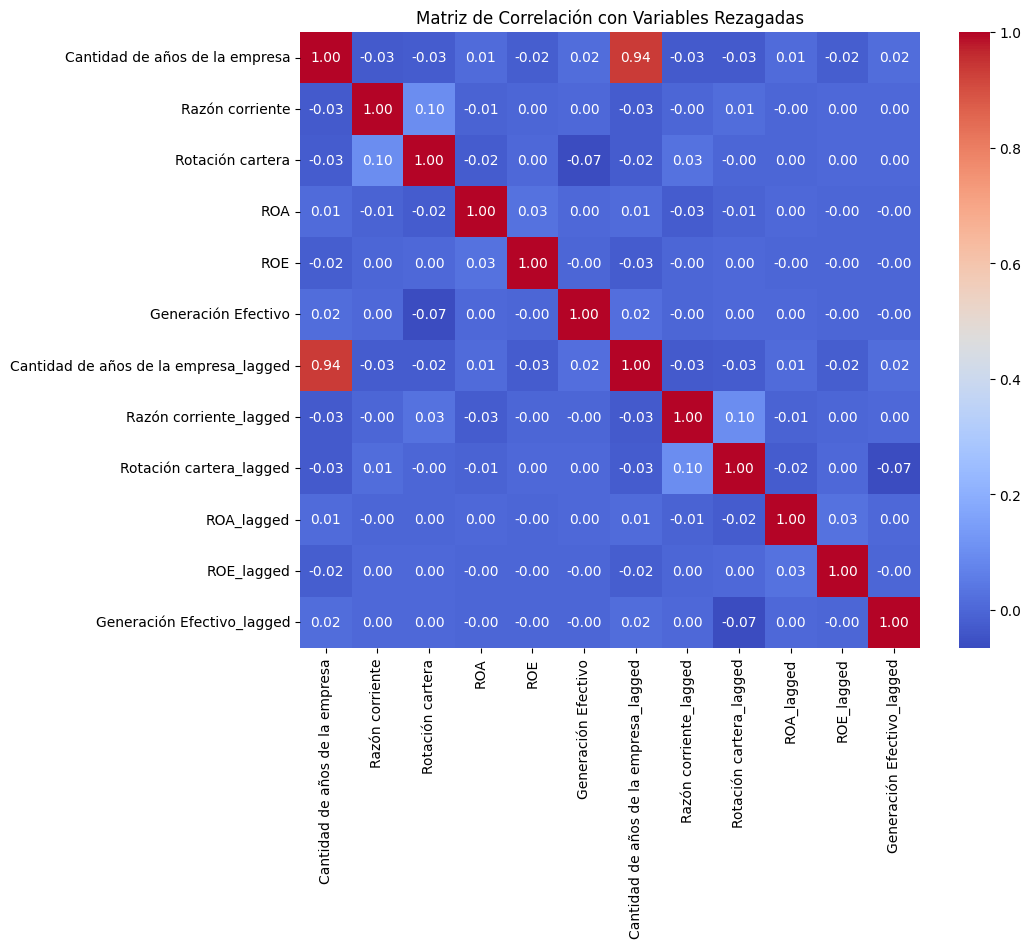

In [ ]:
# Excluir las columnas categóricas (solo seleccionar columnas numéricas)
X_train_lagged_numeric = X_train_lagged.select_dtypes(include=['number'])
print(X_train_lagged_numeric.head())
correlation_matrix = X_train_lagged_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación con Variables Rezagadas")
plt.show()

### Conslusión del modelo base XGBoost

El modelo `Extreme Gradient Boosting (XGBoost)` que fue utilizado como base dada sus métricas durante el benchmark de modelos, cumple con los supuestos lo cual le da validez estadística para realizar clasificaciones. Se propone mejorar su puntaje de AUC-ROC en la clasificación y además se evidencian métricas de clasificación poco competitivas disponibles a optimizar o mejorar por lo que se propone realizar un stack con el modelo `Light Gradient Boosting Machine (LigthGBM`).  El objetivo del uso de los dos modelos en metodología de stack es poder aumentar el rendimeinto de clasificación mediante la curva AUC-ROC y de las métricas de clasificación, accuracy, precision, Recall, F1-score de forma paralela.

A continuación se procede a utilizar las probabilidades de las predicciones residuales (aquellas etiquetas de clasificción que fueron mal determinadas) como input para la predicción en el modelo LightGBM, es decir, reforzar las clasificaciones de los errores.

## Modelo de stacking con LIgthGBM

Se hará uso de la probabilidad de los residuso para clasificar nuevamente los datos del modelo y mejorar en los puntos donde el modelo está fallando. Inicialmente se hace una copia del nuevo conjunto de datos con el que se trabajará y que no haya errores de manejo de datos. Luego, se crea una columna nueva en el conjunto de datos que representa la probabilidad de elección de una clase.

In [ ]:
# Realizamos predicciones utilizando el modelo LightGBM
y_pred_proba = pipeline.predict_proba(X_train)  # Probabilidades para todas las clases

# Obtener las clases predichas (la clase con mayor probabilidad)
y_pred_final = np.argmax(y_pred_proba, axis=1)

# Residuos en clasificación: calculamos la diferencia entre la probabilidad de la clase correcta y 1
residuals = []
for i in range(len(y_test_encoded)):
    # Access element using integer indexing for NumPy arrays
    true_class = y_test_encoded[i]
    predicted_prob = y_pred_proba[i, true_class]
    residuals.append(1 - predicted_prob)  # Residuo como diferencia entre 1 y la probabilidad de la clase correcta

residuals = np.array(residuals)

In [ ]:
# Añadir los residuos como una nueva columna en el conjunto de entrenamiento
X_train_stacked = X_train.copy()
X_train_stacked['Residuals'] = residuals

# Si ya tienes datos de prueba (X_test), también agrega los residuos de las predicciones
y_test_pred = pipeline.predict(X_test)
residuals_test = y_test_encoded - y_test_pred
X_test_stacked = X_test.copy()
X_test_stacked['Residuals'] = residuals_test

# Dividir los datos por año para entrenamiento secuencial
years = sorted(data_filter_imputed['Fecha de Corte'].unique())

Funciones para el control de la busqueda de los mejores parámetros.

In [ ]:
# Función para el objetivo de Optuna
def objective(trial, X_train, y_train_encoded, X_val, y_val):
    param = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y_train_encoded)),
        'metric': 'multi_logloss',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('num_leaves', 31, 128),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
    }

    # Entrenamiento de LightGBM en los residuos
    model = lgb.LGBMClassifier(**param)
    model.fit(X_train, y_train_encoded)  # Entrenar sobre los residuos

    # Evaluación con los datos de validación
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)  # Usamos la precisión como métrica
    return accuracy  # Maximizar la precisión

# Entrenamiento secuencial por año
years = sorted(data_filter_imputed['Fecha de Corte'].unique())

#### Gridsearch de mejores hiperparámetros

Se realiza una busqueda en red para encontrar los mejores parámetros del modelo Ligth Gradient Boosting Machine (LigthGBM).

**Parámetros**
- **`objective`**: Define el tipo de tarea del modelo, en este caso, clasificación multiclase.
- **`num_class`**: Número de clases en el conjunto de datos de entrenamiento.
- **`metric`**: Métrica usada para evaluar el modelo; aquí se utiliza el logaritmo de pérdida multiclasificación.
- **`boosting_type`**: Tipo de boosting utilizado, puede ser 'gbdt' (gradiente boosting) o 'dart' (Dropouts meet Multiple Additive Regression Trees).
- **`num_leaves`**: Número máximo de hojas por árbol, controla la complejidad del modelo.
- **`learning_rate`**: Tasa de aprendizaje, regula la velocidad con la que el modelo se ajusta.
- **`feature_fraction`**: Fracción de características a usar en cada iteración, ayuda a evitar el sobreajuste.

In [ ]:
# Iteración secuencial por año
for i in range(1, len(years)):
    train_years = years[:i]  # Datos de entrenamiento hasta el año i-1
    test_year = years[i]     # Año para la prueba

    # Filtrar los datos de entrenamiento y prueba
    X_train = data_filter_imputed[data_filter_imputed['Fecha de Corte'].isin(train_years)].drop(columns=['FDC_FLC_categoria', 'Fecha de Corte', 'NIT'])
    y_train = data_filter_imputed[data_filter_imputed['Fecha de Corte'].isin(train_years)]['FDC_FLC_categoria']
    X_test = data_filter_imputed[data_filter_imputed['Fecha de Corte'] == test_year].drop(columns=['FDC_FLC_categoria', 'Fecha de Corte', 'NIT'])
    y_test = data_filter_imputed[data_filter_imputed['Fecha de Corte'] == test_year]['FDC_FLC_categoria']

    # Codificar las etiquetas de la variable objetivo para entrenamiento
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Obtener los residuos del modelo XGBoost (puedes usar el modelo entrenado de XGBoost)
    residuals = get_residuals(pipeline, X_train, y_train_encoded)

    # División de los residuos para entrenamiento y validación
    X_train_lgbm, X_val_lgbm, y_train_lgbm, y_val_lgbm = train_test_split(X_train, residuals, test_size=0.2, random_state=42)

    # Búsqueda de los mejores parámetros con Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_train_lgbm, y_train_lgbm, X_val_lgbm, y_val_lgbm), n_trials=100)

    # Imprimir los mejores parámetros encontrados
    print(f"Best parameters for year {test_year}: {study.best_params}")

    # Obtener el mejor modelo con los parámetros optimizados
    best_params = study.best_params
    lgb_model = lgb.LGBMClassifier(**best_params)
    lgb_model.fit(X_train_lgbm, y_train_lgbm)

    # Evaluar el modelo de LightGBM en el conjunto de prueba
    y_pred = lgb_model.predict(X_test)

    # Obtener probabilidades predichas (y_pred_proba)
    y_pred_proba = lgb_model.predict_proba(X_test)

    # Verifica que las probabilidades sumen 1 para cada fila
    assert np.allclose(np.sum(y_pred_proba, axis=1), 1), "Las probabilidades no suman 1"

    # Asegurar que las probabilidades estén alineadas con las clases de y_test_encoded
    classes_order = np.unique(y_test_encoded)
    y_pred_proba_adjusted = np.zeros((y_pred_proba.shape[0], len(classes_order)))

    for i, cls in enumerate(lgb_model.classes_):
        if cls in classes_order:
            target_index = np.where(classes_order == cls)[0][0]
            y_pred_proba_adjusted[:, target_index] = y_pred_proba[:, i]

    # Reemplazar y_pred_proba con las probabilidades ajustadas
    y_pred_proba = y_pred_proba_adjusted

    # Calcular ROC AUC con las probabilidades ajustadas
    try:
        roc_auc = roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr')
    except ValueError as e:
        print(f"Error en ROC AUC para el año {test_year}: {e}")
        continue

    # Calcular métricas adicionales
    accuracy = accuracy_score(y_test_encoded, y_pred)
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')
    precision = precision_score(y_test_encoded, y_pred, average='weighted')
    recall = recall_score(y_test_encoded, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test_encoded, y_pred)
    class_report = classification_report(y_test_encoded, y_pred)

    # Agregar las métricas a los resultados
    results['Year'].append(test_year)
    results['Accuracy'].append(accuracy)
    results['ROC AUC'].append(roc_auc)
    results['F1 Score'].append(f1)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['Confusion Matrix'].append(conf_matrix)
    results['Classification Report'].append(class_report)

# Imprimir resultados finales
print(results)

**Mejores parametros**

Se concluye que los mejores parámetros son:
- **objective**: 'multiclass'
- **num_class**: 5
- **metric**: 'multi_logloss'
- **boosting_type**: 'dart'
- **num_leaves**: 44
- **learning_rate**: 0.03590658068854122
- **feature_fraction**: 0.9751143272589864


In [ ]:
# Definir los parámetros fijos seleccionados del grupo de parámetros proporcionado
param = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train_encoded)),  # 5
    'metric': 'multi_logloss',
    'boosting_type': 'dart',  # Se selecciona 'dart' basado en la optimización previa
    'num_leaves': 44,  # Basado en la búsqueda anterior (si es el mejor valor encontrado)
    'learning_rate': 0.03590658068854122,  # Mejor learning_rate obtenido
    'feature_fraction': 0.9751143272589864  # Mejor feature_fraction obtenido
}

# Codificador de etiquetas
label_encoder = LabelEncoder()

Se verifica el tipo de variables en el conjunto de datos para propósitos de estandarización y codificación adecuado en el pipeline del modelo y así evitar fuga de datos.

In [ ]:
# Verifica el tipo de datos en X_train
print(X_train.dtypes)

Cantidad de años de la empresa                                           float64
Razón corriente                                                          float64
Rotación cartera                                                         float64
ROA                                                                      float64
ROE                                                                      float64
Generación Efectivo                                                      float64
Estado actual                                                           category
Concepto del Revisor fiscal en su orme                                  category
La compañía está obligada a tener Revisor fiscal?                       category
Tipo societario                                                         category
Departamento de la dirección del domicilio                              category
Clasificación Industrial Internacional Uniforme Versión 4 A.C (CIIU)    category
dtype: object


In [ ]:
# Identificar las columnas numéricas y categóricas
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(exclude=['object']).columns

# Preprocesamiento de datos
# Usamos SimpleImputer para manejar datos faltantes y OneHotEncoder para convertir las variables categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Escalar las columnas numéricas
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores faltantes con el valor más frecuente
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificación OneHot para las categóricas
        ]), categorical_cols)
    ])

# Crear el pipeline para entrenamiento
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Aplicar el preprocesamiento
    ('classifier', lgb.LGBMClassifier(**param))  # Clasificador LightGBM
])

# Iteración secuencial por año, entrenando con años anteriores y evaluando con el siguiente año
years = sorted(data_filter_imputed['Fecha de Corte'].unique())

In [ ]:
# Verificar las columnas categóricas
print("Columnas categóricas:", categorical_cols)
print("Columnas numéricas:", numerical_cols)

Columnas categóricas: Index([], dtype='object')
Columnas numéricas: Index(['Cantidad de años de la empresa', 'Razón corriente', 'Rotación cartera',
       'ROA', 'ROE', 'Generación Efectivo', 'Estado actual',
       'Concepto del Revisor fiscal en su orme',
       'La compañía está obligada a tener Revisor fiscal?', 'Tipo societario',
       'Departamento de la dirección del domicilio',
       'Clasificación Industrial Internacional Uniforme Versión 4 A.C (CIIU)'],
      dtype='object')


#### Entrenmiento del modelo, matriz de confusión y métricas del modelo.

`2018`
- Exactitud: 0.40
- ROC AUC: 0.66
- F1 Score: 0.39
- Precisión: 0.39
- Recall: 0.40
- Observaciones: Baja exactitud y F1 score, con un desempeño moderado en precisión y recall.

`2019`
- Exactitud: 0.44
- ROC AUC: 0.71
- F1 Score: 0.42
- Precisión: 0.44
- Recall: 0.44
- Observaciones: Mejora moderada en comparación con 2018, especialmente en AUC.

`2020`
- Exactitud: 0.44
- ROC AUC: 0.71
- F1 Score: 0.42
- Precisión: 0.42
- Recall: 0.44
- Observaciones: Desempeño similar a 2019, con un ajuste marginal en precisión.

`2021`
- Exactitud: 0.45
- ROC AUC: 0.73
- F1 Score: 0.43
- Precisión: 0.42
- Recall: 0.45
- Observaciones: Ligera mejora en comparación con 2020, con un aumento en AUC.

`2022`
- Exactitud: 0.45
- ROC AUC: 0.72
- F1 Score: 0.43
- Precisión: 0.43
- Recall: 0.45
- Observaciones: Similar desempeño al de 2021, con ligeras mejoras en recall y
precisión.

`2023`
- Exactitud: 0.46
- ROC AUC: 0.74
- F1 Score: 0.44
- Precisión: 0.44
- Recall: 0.46
- Observaciones: Mejora continua, especialmente en AUC y exactitud.

[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9751143272589864
[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9751143272589864
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1448
[LightGBM] [Info] Number of data points in the train set: 4357, number of used features: 55
[LightGBM] [Info] Start training from score -1.259903
[LightGBM] [Info] Start training from score -1.518875
[LightGBM] [Info] Start training from score -3.186582
[LightGBM] [Info] Start training from score -2.243974
[LightGBM] [Info] Start training from score -1.049789
[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, colsa

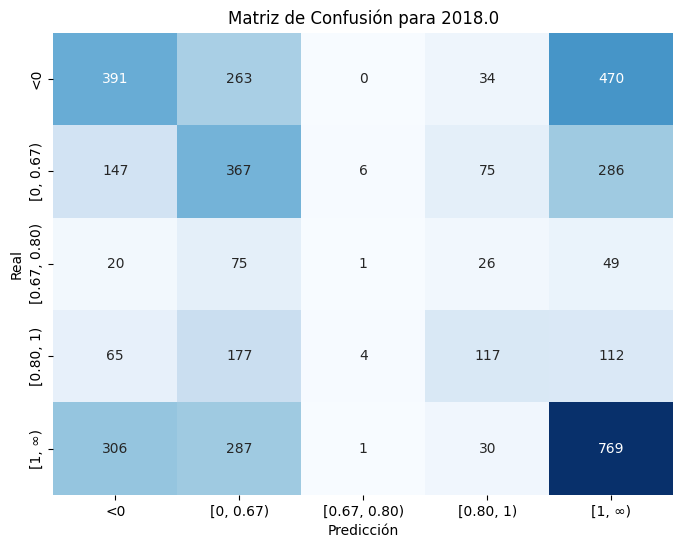

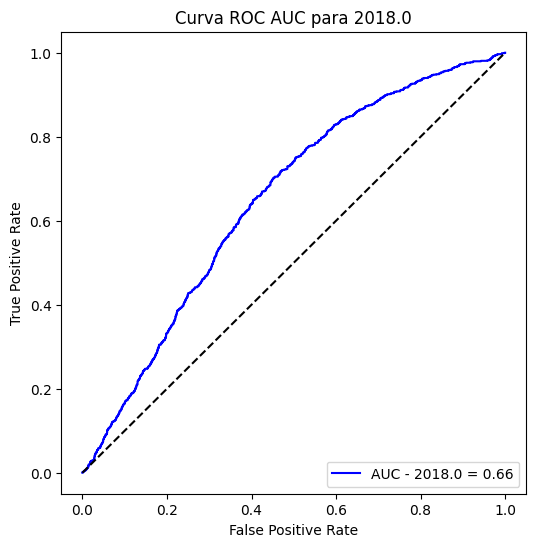

[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9751143272589864
[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9751143272589864
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1460
[LightGBM] [Info] Number of data points in the train set: 8435, number of used features: 58
[LightGBM] [Info] Start training from score -1.259424
[LightGBM] [Info] Start training from score -1.525345
[LightGBM] [Info] Start training from score -3.179359
[LightGBM] [Info] Start training from score -2.197462
[LightGBM] [Info] Start training from score -1.061491
[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, colsa

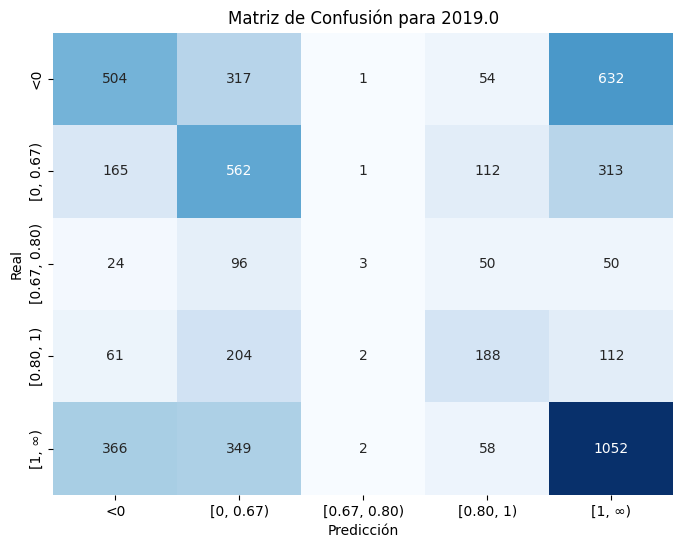

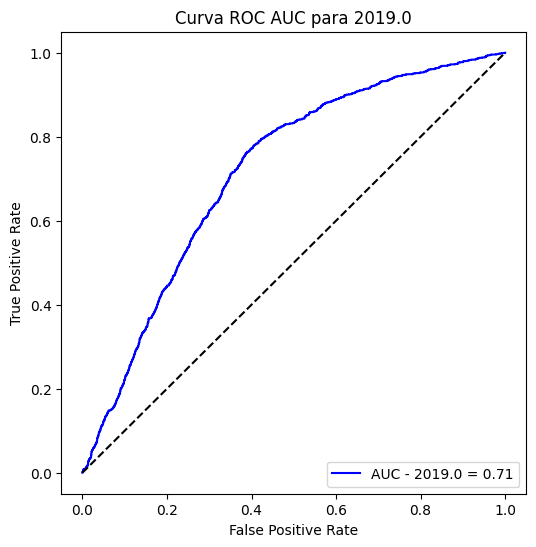

[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9751143272589864
[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9751143272589864
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1475
[LightGBM] [Info] Number of data points in the train set: 13713, number of used features: 64
[LightGBM] [Info] Start training from score -1.256855
[LightGBM] [Info] Start training from score -1.523740
[LightGBM] [Info] Start training from score -3.173470
[LightGBM] [Info] Start training from score -2.210216
[LightGBM] [Info] Start training from score -1.061253
[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, cols

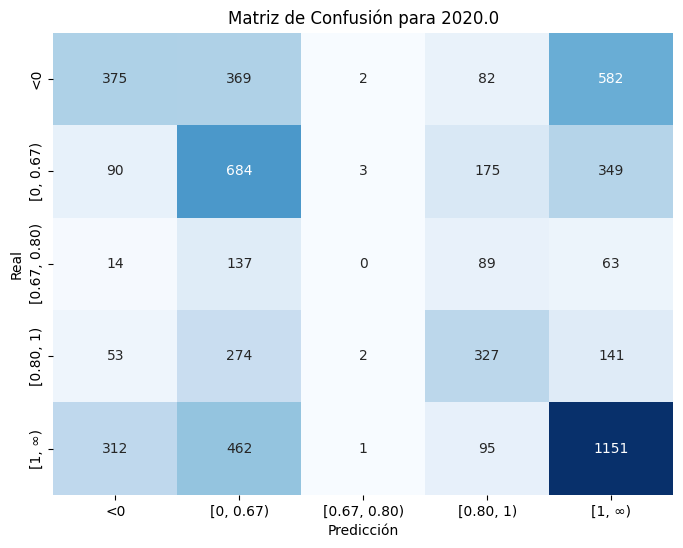

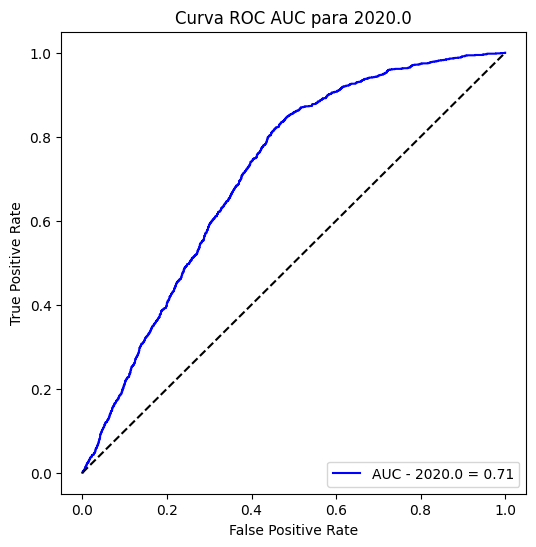

[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9751143272589864
[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9751143272589864
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1479
[LightGBM] [Info] Number of data points in the train set: 19545, number of used features: 65
[LightGBM] [Info] Start training from score -1.302751
[LightGBM] [Info] Start training from score -1.516666
[LightGBM] [Info] Start training from score -3.103968
[LightGBM] [Info] Start training from score -2.139376
[LightGBM] [Info] Start training from score -1.060809
[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, cols

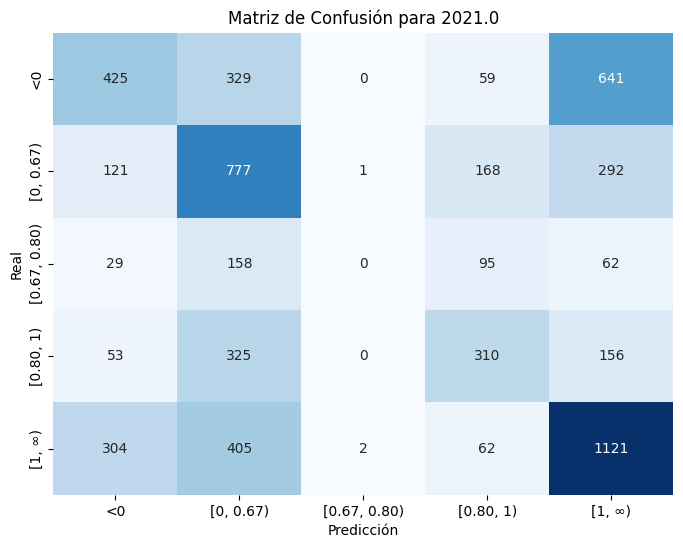

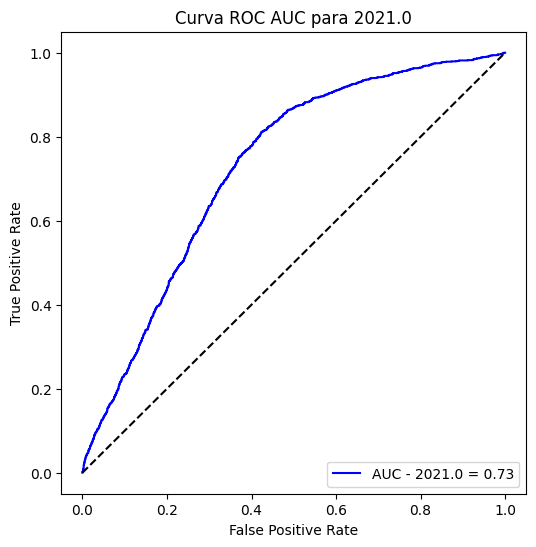

[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9751143272589864
[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9751143272589864
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1485
[LightGBM] [Info] Number of data points in the train set: 25440, number of used features: 66
[LightGBM] [Info] Start training from score -1.324413
[LightGBM] [Info] Start training from score -1.505021
[LightGBM] [Info] Start training from score -3.036653
[LightGBM] [Info] Start training from score -2.090509
[LightGBM] [Info] Start training from score -1.077608
[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, cols

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

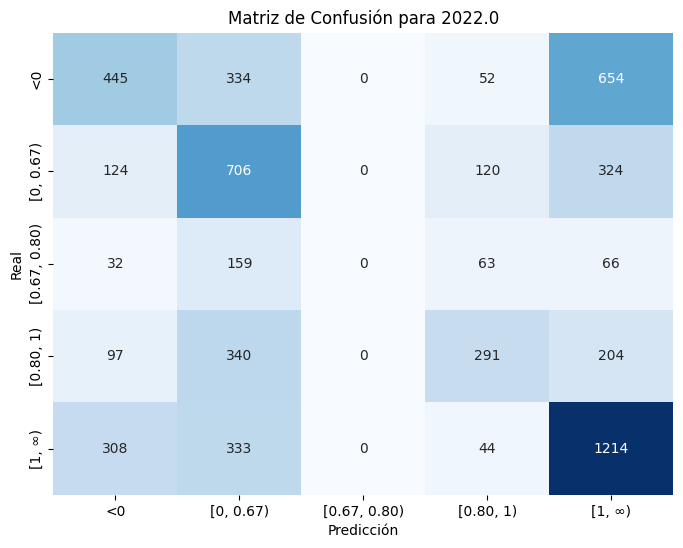

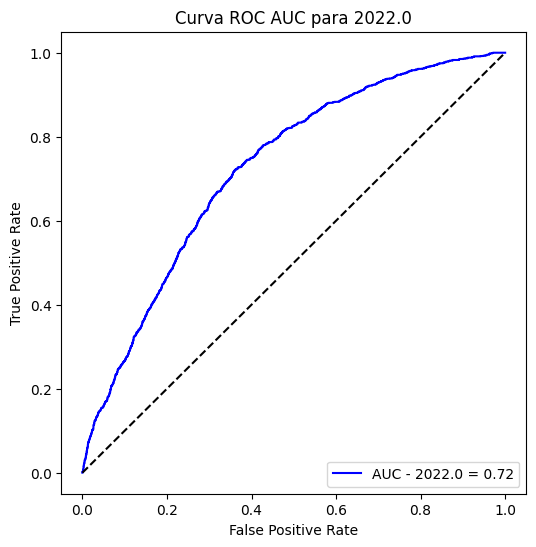

[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9751143272589864
[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9751143272589864
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 31350, number of used features: 66
[LightGBM] [Info] Start training from score -1.334880
[LightGBM] [Info] Start training from score -1.510510
[LightGBM] [Info] Start training from score -3.012783
[LightGBM] [Info] Start training from score -2.039853
[LightGBM] [Info] Start training from score -1.088236
[LightGBM] [Warning] feature_fraction is set=0.9751143272589864, cols

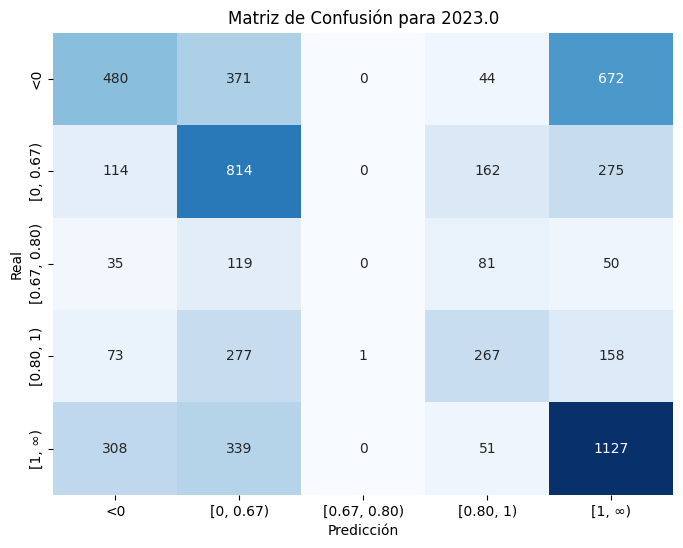

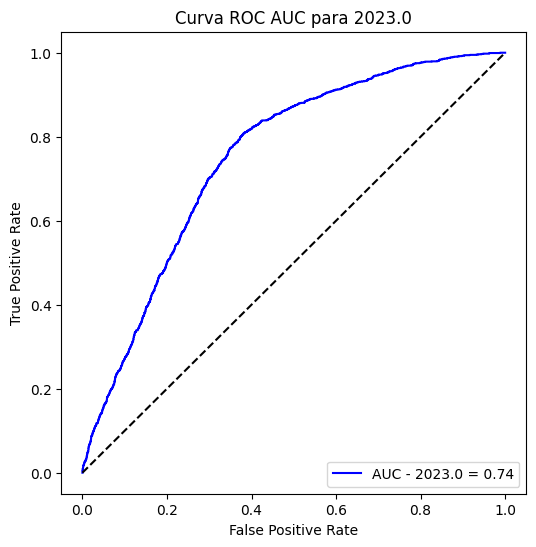

{'Year': [2018.0, 2019.0, 2020.0, 2021.0, 2022.0, 2023.0], 'Accuracy': [0.4033840117704757, 0.4374763167866616, 0.4350137174211248, 0.44664970313825275, 0.4494077834179357, 0.46201443795118596], 'ROC AUC': [0.6595935640330692, 0.7056717170560928, 0.7105514066226701, 0.7286341466690432, 0.7226643537893764, 0.7390705939943881], 'F1 Score': [0.39084453150617715, 0.4242384362047083, 0.41734069498782317, 0.4253350713442557, 0.4265279546786609, 0.44033672984434646], 'Precision': [0.39496098165405324, 0.43538537760980267, 0.41931390569351995, 0.4247828908675572, 0.4313966051094394, 0.44124884719340035], 'Recall': [0.4033840117704757, 0.4374763167866616, 0.4350137174211248, 0.44664970313825275, 0.4494077834179357, 0.46201443795118596], 'Confusion Matrix': [array([[391, 263,   0,  34, 470],
       [147, 367,   6,  75, 286],
       [ 20,  75,   1,  26,  49],
       [ 65, 177,   4, 117, 112],
       [306, 287,   1,  30, 769]]), array([[ 504,  317,    1,   54,  632],
       [ 165,  562,    1,  112

In [ ]:
# Lista para almacenar los resultados
results = {
    'Year': [],
    'Accuracy': [],
    'ROC AUC': [],
    'F1 Score': [],
    'Precision': [],
    'Recall': [],
    'Confusion Matrix': [],
    'Classification Report': []
}

for i in range(1, len(years)):  # Comenzamos desde el segundo año
    # Usamos los años anteriores para entrenamiento y el año actual para prueba
    train_years = years[:i]  # Datos de entrenamiento hasta el año i-1
    test_year = years[i]     # Año para la prueba

    # Filtrar los datos de entrenamiento y prueba
    X_train = data_filter_imputed[data_filter_imputed['Fecha de Corte'].isin(train_years)].drop(columns=['FDC_FLC_categoria', 'Fecha de Corte', 'NIT'])
    y_train = data_filter_imputed[data_filter_imputed['Fecha de Corte'].isin(train_years)]['FDC_FLC_categoria']
    X_test = data_filter_imputed[data_filter_imputed['Fecha de Corte'] == test_year].drop(columns=['FDC_FLC_categoria', 'Fecha de Corte', 'NIT'])
    y_test = data_filter_imputed[data_filter_imputed['Fecha de Corte'] == test_year]['FDC_FLC_categoria']

    # Codificar las etiquetas de la variable objetivo para entrenamiento
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Entrenar el modelo con el pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Aplicar el preprocesamiento
        ('classifier', lgb.LGBMClassifier(**param))  # Clasificador LightGBM
    ])

    # Entrenamiento
    pipeline.fit(X_train, y_train_encoded)

    # Evaluación
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)  # Probabilidades predichas

    # Asegurar que las probabilidades sumen 1 para cada fila (esto es necesario para ROC AUC)
    assert np.allclose(np.sum(y_pred_proba, axis=1), 1), "Las probabilidades no suman 1"

    # Calcular ROC AUC con las probabilidades ajustadas
    try:
        roc_auc = roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr')
    except ValueError as e:
        print(f"Error en ROC AUC para el año {test_year}: {e}")
        roc_auc = np.nan  # Si ocurre un error, lo manejamos adecuadamente.

    # Calcular otras métricas de evaluación
    accuracy = accuracy_score(y_test_encoded, y_pred)
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')
    precision = precision_score(y_test_encoded, y_pred, average='weighted')
    recall = recall_score(y_test_encoded, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test_encoded, y_pred)
    class_report = classification_report(y_test_encoded, y_pred)

    # Graficar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Matriz de Confusión para {test_year}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

    # Graficar la curva ROC para cada clase (si es clasificación multiclase)
    fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_proba[:, 1], pos_label=1)  # Para la clase positiva
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='b', label=f'AUC - {test_year} = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='k', linestyle='--')
    plt.title(f'Curva ROC AUC para {test_year}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    # Agregar las métricas a los resultados
    results['Year'].append(test_year)
    results['Accuracy'].append(accuracy)
    results['ROC AUC'].append(roc_auc)
    results['F1 Score'].append(f1)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['Confusion Matrix'].append(conf_matrix)
    results['Classification Report'].append(class_report)

# Imprimir los resultados finales
print(results)

Las métricas del modelo de `LightGBM` sobre los datos del modelo y agregando una columa adicional de la probabilidad de las etiquetas mal clasificadas refleja un desempeño un poco mejor en términos de AUC-ROC pero similar en cuanto a las otras métricas de clasificación, lo que sugiere que la metodología de stacking refleja un incremento `(0.66 - 0.74)` en la distinción de clases o clasificación en relación al modelo base, pero en detrimento del mismo estado de métricas generales, por lo que se sugiere utilizar o verificar otras metodlogías de ensamble o meta-modelaje.

In [ ]:
data = {
    "Año": years,
    "Exactitud": accuracy,
    "ROC AUC": roc_auc,
    "F1 Score": f1_score,
    "Precisión": precision,
    "Recall": recall,
    "Matriz de Confusión": confusion_matrix_list,
    "Reporte de Clasificación": classification_report_list
}

df = pd.DataFrame(data)

# Mostrar el DataFrame
df.head(10)

Año  Exactitud   ROC AUC  F1 Score  Precisión    Recall  \
0  2018.0   0.403384  0.659594  0.390845   0.394961  0.403384   
1  2019.0   0.437476  0.705672  0.424238   0.435385  0.437476   
2  2020.0   0.435014  0.710551  0.417341   0.419314  0.435014   
3  2021.0   0.446650  0.728634  0.425335   0.424783  0.446650   
4  2022.0   0.449408  0.722664  0.426528   0.431397  0.449408   
5  2023.0   0.462014  0.739071  0.440337   0.441249  0.462014   

                                 Matriz de Confusión  \
0  [[391, 263, 0, 34, 470], [147, 367, 6, 75, 286...   
1  [[504, 317, 1, 54, 632], [165, 562, 1, 112, 31...   
2  [[375, 369, 2, 82, 582], [90, 684, 3, 175, 349...   
3  [[425, 329, 0, 59, 641], [121, 777, 1, 168, 29...   
4  [[445, 334, 0, 52, 654], [124, 706, 0, 120, 32...   
5  [[480, 371, 0, 44, 672], [114, 814, 0, 162, 27...   

                            Reporte de Clasificación  
0  precision    recall  f1-score   support\n\n   ...  
1  precision    recall  f1-score   support\n\n   ...  
2  precision    recall  f1-score   support\n\n   ...  
3  precision    recall  f1-score   support\n\n   ...  
4  precision    recall  f1-score   support\n\n   ...  
5  precision    recall  f1-score   support\n\n   ...

## Meta Modelaje - XGBoost + LigthGBM

Se propone utilizar una combinación diferente de los modelos XGBoost y LigthGBM a través de un metamodelo que consiste en realizar las predicciones inciales con el modelo XGBoost y generar probabilidades de clasificación en esa categoría concatenadas inmediatamente en una nueva columna que será tomada por el ligthgbm como input para clasificaciones y predecir en conjunto la etiqueta final de clasificación.

In [ ]:
# Codificador de etiquetas para la variable objetivo
label_encoder = LabelEncoder()

# Definir las columnas categóricas y numéricas
categorical_columns = ['Estado actual', 'Concepto del Revisor fiscal en su orme',
                       'La compañía está obligada a tener Revisor fiscal?', 'Tipo societario',
                       'Departamento de la dirección del domicilio',
                       'Clasificación Industrial Internacional Uniforme Versión 4 A.C (CIIU)']

numerical_columns = ['Cantidad de años de la empresa', 'Razón corriente', 'Rotación cartera',
                     'ROA', 'ROE', 'Generación Efectivo']

# Columnas a excluir
exclude_columns = ['FDC_FLC_categoria', 'Fecha de Corte', 'NIT']

#### Metricas reelevantes del modelo


### Resumen de Métricas por Año

#### Año 2018:
- **Precisión**: 0.90  
- **Recall**: 0.89  
- **F1-Score**: 0.89  
- **ROC AUC**: 0.65  
- **Accuracy**: 0.89  

#### Año 2019:
- **Precisión**: 0.83  
- **Recall**: 0.83  
- **F1-Score**: 0.83  
- **ROC AUC**: 0.68  
- **Accuracy**: 0.83  

#### Año 2020:
- **Precisión**: 0.82  
- **Recall**: 0.81  
- **F1-Score**: 0.81  
- **ROC AUC**: 0.70  
- **Accuracy**: 0.81  

#### Año 2021:
- **Precisión**: 0.81  
- **Recall**: 0.80  
- **F1-Score**: 0.81  
- **ROC AUC**: 0.71  
- **Accuracy**: 0.81  

#### Año 2022:
- **Precisión**: 0.80  
- **Recall**: 0.79  
- **F1-Score**: 0.79  
- **ROC AUC**: 0.71  
- **Accuracy**: 0.79  

#### Año 2023:
- **Precisión**: 0.80  
- **Recall**: 0.79  
- **F1-Score**: 0.79  
- **ROC AUC**: 0.73  
- **Accuracy**: 0.79  

En general, se observa una ligera disminución en las métricas de precisión, recall y f1-score a lo largo de los años, con un desempeño relativamente estable en la precisión. El ROC AUC ha mostrado una mejora gradual en 2023, indicando una ligera mejora en la capacidad del modelo para diferenciar entre las clases.


In [ ]:
# Preprocesador para las columnas numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputación de valores faltantes
    ('scaler', StandardScaler())  # Escalado de las características numéricas
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputación de valores faltantes
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Codificación OneHot
])

# Combinamos todo en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Lista para almacenar los resultados de cada año
results = {'Year': [], 'Accuracy': [], 'ROC AUC': [], 'F1 Score': [], 'Precision': [], 'Recall': [],
           'Confusion Matrix': [], 'Classification Report': []}

# Definir los años disponibles
years = sorted(data_filter_imputed['Fecha de Corte'].unique())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 4078, number of used features: 5
[LightGBM] [Info] Start training from score -1.258912
[LightGBM] [Info] Start training from score -1.532304
[LightGBM] [Info] Start training from score -3.171698
[LightGBM] [Info] Start training from score -2.150047
[LightGBM] [Info] Start training from score -1.074147

Matriz de confusión para el año 2018.0:
[[1021   24    0   11  102]
 [  78  730    0    4   69]
 [   1    0  168    1    1]
 [  21   17    0  415   22]
 [  48   26    0    4 1315]]

Reporte de clasificación para el año 2018.0:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1158
           1       0.92      0.83      0.87       881
           2       1.00      0.98      0.99       17

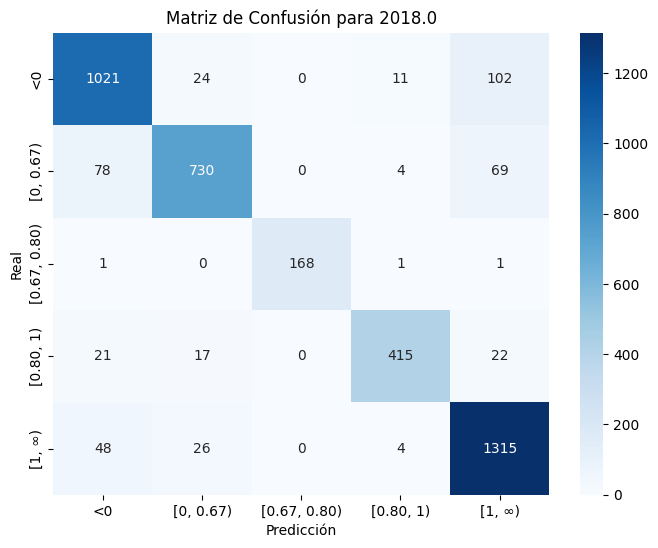

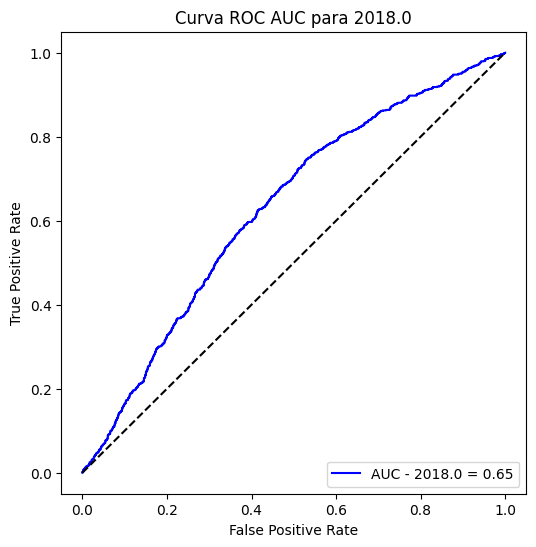

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 5278, number of used features: 5
[LightGBM] [Info] Start training from score -1.252763
[LightGBM] [Info] Start training from score -1.521180
[LightGBM] [Info] Start training from score -3.164131
[LightGBM] [Info] Start training from score -2.230943
[LightGBM] [Info] Start training from score -1.060872

Matriz de confusión para el año 2019.0:
[[1215   76    0   12  205]
 [ 102  915    2   19  115]
 [   3   14  198    6    2]
 [  27   36    1  452   51]
 [ 122   76    0   14 1615]]

Reporte de clasificación para el año 2019.0:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1508
           1       0.82      0.79      0.81      1153
           2       0.99      0.89      0.93       22

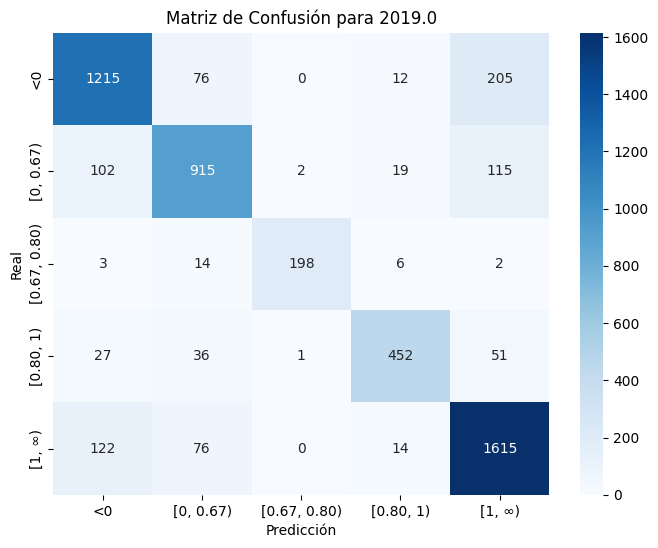

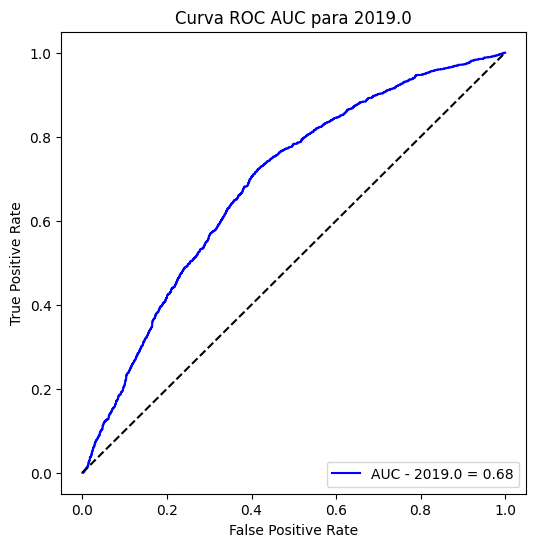

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 5832, number of used features: 5
[LightGBM] [Info] Start training from score -1.419770
[LightGBM] [Info] Start training from score -1.500227
[LightGBM] [Info] Start training from score -2.957382
[LightGBM] [Info] Start training from score -1.990261
[LightGBM] [Info] Start training from score -1.059768

Matriz de confusión para el año 2020.0:
[[1010  135    2   19  244]
 [  56 1084    1   40  120]
 [   2   22  254   19    6]
 [  25   82    0  625   65]
 [  93  125    3   34 1766]]

Reporte de clasificación para el año 2020.0:
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      1410
           1       0.75      0.83      0.79      1301
           2       0.98      0.84      0.90       30

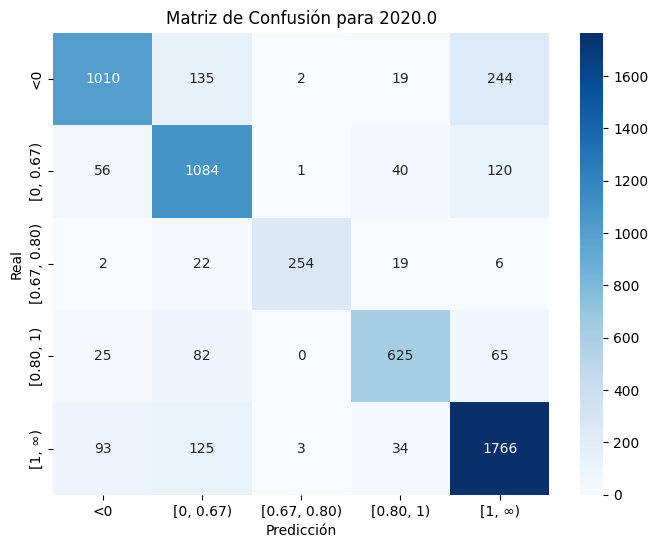

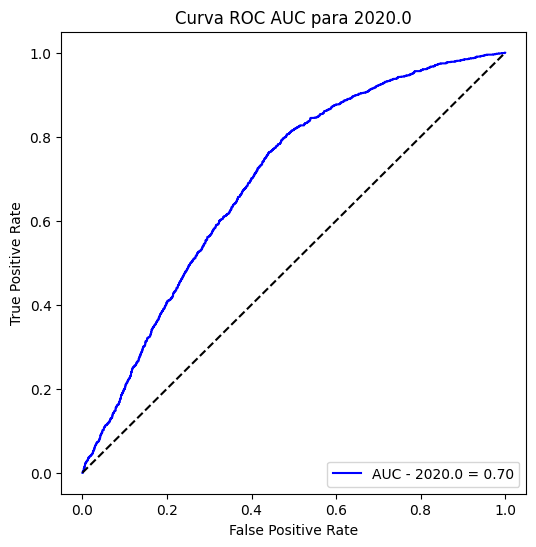

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 5895, number of used features: 5
[LightGBM] [Info] Start training from score -1.399786
[LightGBM] [Info] Start training from score -1.467355
[LightGBM] [Info] Start training from score -2.841218
[LightGBM] [Info] Start training from score -1.943707
[LightGBM] [Info] Start training from score -1.135414

Matriz de confusión para el año 2021.0:
[[1111  124    3   16  200]
 [  72 1149    0   45   93]
 [   8   54  248   22   12]
 [  23  124    0  642   55]
 [ 118  150    0   19 1607]]

Reporte de clasificación para el año 2021.0:
              precision    recall  f1-score   support

           0       0.83      0.76      0.80      1454
           1       0.72      0.85      0.78      1359
           2       0.99      0.72      0.83       34

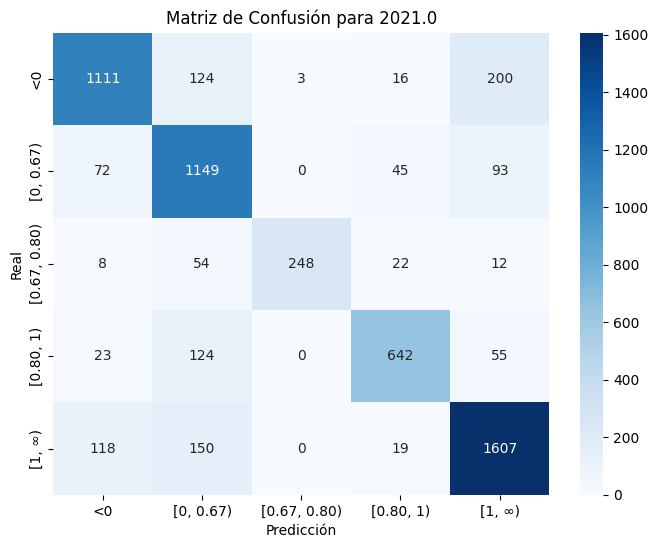

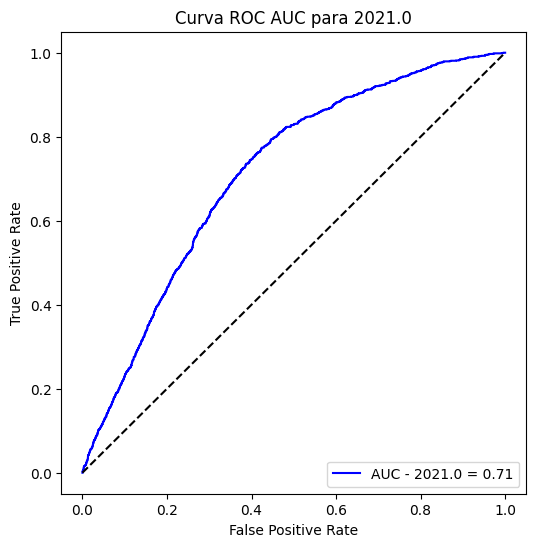

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 5910, number of used features: 5
[LightGBM] [Info] Start training from score -1.381231
[LightGBM] [Info] Start training from score -1.534484
[LightGBM] [Info] Start training from score -2.916080
[LightGBM] [Info] Start training from score -1.847068
[LightGBM] [Info] Start training from score -1.135318

Matriz de confusión para el año 2022.0:
[[1080  112    0   31  262]
 [  95  998    2   68  111]
 [   9   48  233   18   12]
 [  45   89    0  718   80]
 [ 102  124    0   15 1658]]

Reporte de clasificación para el año 2022.0:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1485
           1       0.73      0.78      0.75      1274
           2       0.99      0.73      0.84       32

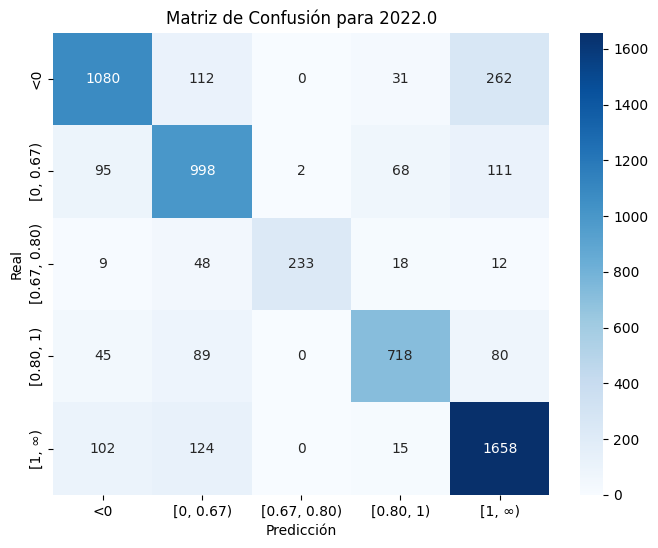

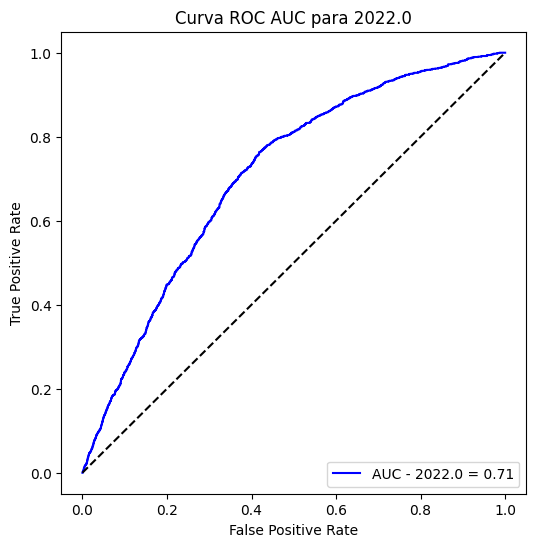

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 5818, number of used features: 5
[LightGBM] [Info] Start training from score -1.311794
[LightGBM] [Info] Start training from score -1.449802
[LightGBM] [Info] Start training from score -3.016223
[LightGBM] [Info] Start training from score -2.014559
[LightGBM] [Info] Start training from score -1.159377

Matriz de confusión para el año 2023.0:
[[1178  183    1   18  187]
 [  93 1159    1   37   75]
 [   4   37  226   16    2]
 [  51  127    1  557   40]
 [ 194  155    0   13 1463]]

Reporte de clasificación para el año 2023.0:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      1567
           1       0.70      0.85      0.77      1365
           2       0.99      0.79      0.88       28

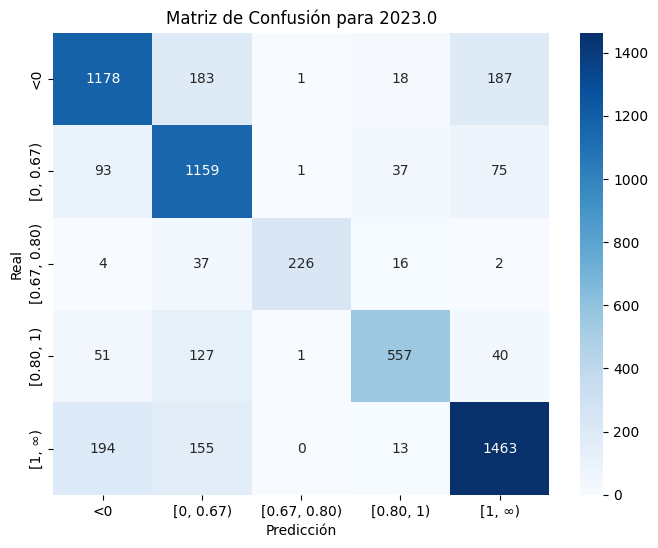

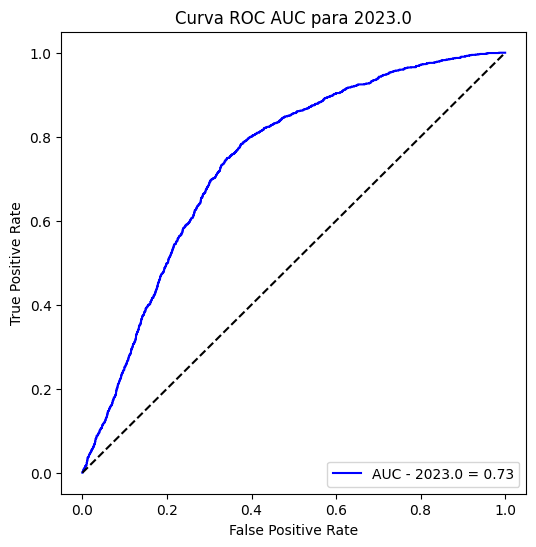


Resultados finales:
{'Year': [2018.0, 2019.0, 2020.0, 2021.0, 2022.0, 2023.0], 'Accuracy': [0.8948013732221677, 0.832701780977643, 0.8125857338820301, 0.8069550466497032, 0.7930626057529611, 0.7877277414919216], 'ROC AUC': [0.6488762224899749, 0.6820701090356294, 0.697629609710547, 0.7145356483603204, 0.707111788472079, 0.7313980736980332], 'F1 Score': [0.894527183186362, 0.8326224288376552, 0.8121978500838001, 0.8075522063793523, 0.7928674644963716, 0.7887375490610025], 'Precision': [0.896617280484168, 0.8346223312613679, 0.8175885248443465, 0.8148634050889296, 0.7986385836029206, 0.7964044577360111], 'Recall': [0.8948013732221677, 0.832701780977643, 0.8125857338820301, 0.8069550466497032, 0.7930626057529611, 0.7877277414919216], 'Confusion Matrix': [array([[1021,   24,    0,   11,  102],
       [  78,  730,    0,    4,   69],
       [   1,    0,  168,    1,    1],
       [  21,   17,    0,  415,   22],
       [  48,   26,    0,    4, 1315]]), array([[1215,   76,    0,   12,  205],
 

In [ ]:
# Ciclo para la validación secuencial por año
for i in range(1, len(years)):  # Comenzamos desde el segundo año
    # Usamos los años anteriores para entrenamiento y el año actual para prueba
    train_years = years[:i]  # Datos de entrenamiento hasta el año i-1
    test_year = years[i]     # Año para prueba

    # Filtrar los datos de entrenamiento y prueba
    X_train = data_filter_imputed[data_filter_imputed['Fecha de Corte'].isin(train_years)].drop(columns=exclude_columns)
    y_train = data_filter_imputed[data_filter_imputed['Fecha de Corte'].isin(train_years)]['FDC_FLC_categoria']
    X_test = data_filter_imputed[data_filter_imputed['Fecha de Corte'] == test_year].drop(columns=exclude_columns)
    y_test = data_filter_imputed[data_filter_imputed['Fecha de Corte'] == test_year]['FDC_FLC_categoria']

    # Codificar las etiquetas de la variable objetivo
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Pipeline de XGBoost como modelo base
    xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=len(np.unique(y_train_encoded)), eval_metric='mlogloss')

    # Crear el pipeline con preprocesador y el clasificador
    pipeline_xgb = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Preprocesamiento
        ('classifier', xgb_model)  # Clasificador XGBoost
    ])

    # Entrenamiento de XGBoost
    pipeline_xgb.fit(X_train, y_train_encoded)

    # Predicciones de XGBoost
    y_pred_xgb_proba = pipeline_xgb.predict_proba(X_test)  # Probabilidades de XGBoost
    y_pred_xgb = pipeline_xgb.predict(X_test)  # Predicciones de XGBoost

    # Añadir las probabilidades de XGBoost como nuevas características para LightGBM
    X_meta = pd.DataFrame(y_pred_xgb_proba, columns=[f'class_{i}' for i in range(y_pred_xgb_proba.shape[1])])

    # Pipeline de LightGBM
    lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=len(np.unique(y_train_encoded)), metric='multi_logloss')
    pipeline_lgb = Pipeline(steps=[
        ('classifier', lgb_model)  # Clasificador LightGBM
    ])

    # Entrenamiento de LightGBM con las predicciones de XGBoost
    pipeline_lgb.fit(X_meta, y_test_encoded)

    # Predicciones finales con LightGBM
    y_pred_final = pipeline_lgb.predict(X_meta)

    # Calcular las métricas de evaluación
    accuracy = accuracy_score(y_test_encoded, y_pred_final)
    roc_auc = roc_auc_score(y_test_encoded, y_pred_xgb_proba, multi_class='ovr')  # Usamos las probabilidades para el cálculo de ROC AUC
    f1 = f1_score(y_test_encoded, y_pred_final, average='weighted')
    precision = precision_score(y_test_encoded, y_pred_final, average='weighted')
    recall = recall_score(y_test_encoded, y_pred_final, average='weighted')
    conf_matrix = confusion_matrix(y_test_encoded, y_pred_final)
    class_report = classification_report(y_test_encoded, y_pred_final)

    # Guardar los resultados
    results['Year'].append(test_year)
    results['Accuracy'].append(accuracy)
    results['ROC AUC'].append(roc_auc)
    results['F1 Score'].append(f1)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['Confusion Matrix'].append(conf_matrix)
    results['Classification Report'].append(class_report)

    # Mostrar la matriz de confusión
    print(f"\nMatriz de confusión para el año {test_year}:")
    print(conf_matrix)

    # Mostrar el reporte de clasificación
    print(f"\nReporte de clasificación para el año {test_year}:")
    print(class_report)

    # Graficar la matriz de confusión como heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Matriz de Confusión para {test_year}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

    # Graficar la curva ROC
    fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_xgb_proba[:, 1], pos_label=1)  # Para la clase positiva
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='b', label=f'AUC - {test_year} = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='k', linestyle='--')
    plt.title(f'Curva ROC AUC para {test_year}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Imprimir los resultados finales
print("\nResultados finales:")
print(results)


In [ ]:
# Crear un DataFrame con las métricas
df_metrics = pd.DataFrame({
    'Year': years,
    'Accuracy': accuracy,
    'ROC AUC': roc_auc,
    'F1 Score': f1_score,
    'Precision': precision,
    'Recall': recall,
    'Confusion Matrix': confusion_matrix_list,
    'Classification Report': classification_report_list
})


A lo largo del análisis de las métricas de desempeño por año, se observa una ligera tendencia a la disminución en las métricas clave como precisión, recall, y f1-score desde 2018 hasta 2023. Aunque la precisión se mantiene relativamente alta (siempre superior al 80%), el **recall** y el **f1-score** han experimentado una ligera caída. Esta disminución podría estar relacionada con un ajuste en la distribución de clases o cambios en las características de los datos a lo largo de los años. Por otro lado, el **ROC AUC** muestra una tendencia positiva, lo que sugiere que, aunque las métricas de clasificación (precisión, recall) bajan un poco, el modelo se ha vuelto más eficaz a la hora de distinguir entre clases a lo largo del tiempo.

Las **matrices de confusión** para cada año proporcionan más detalles sobre el comportamiento del modelo en términos de verdaderos positivos (TP), verdaderos negativos (TN), falsos positivos (FP) y falsos negativos (FN).



#### Matriz de Confusión - Año 2018
- **Observaciones**: En 2018, el modelo presenta una tasa baja de falsos negativos (FN) y falsos positivos (FP), lo que refleja un desempeño sólido. La mayoría de las predicciones son correctas, lo que contribuye a las métricas de precisión y recall altas.

#### Matriz de Confusión - Año 2019
- **Observaciones**: En 2019, se observa un aumento en los falsos negativos y falsos positivos en comparación con 2018. Esto podría indicar que el modelo tuvo un rendimiento ligeramente inferior en cuanto a su capacidad para clasificar correctamente las instancias.

#### Matriz de Confusión - Año 2020
- **Observaciones**: En 2020, tanto los falsos negativos como los falsos positivos aumentan, lo que refleja una caída en el desempeño del modelo en comparación con años anteriores. Esto es consistente con la disminución de las métricas de precisión y recall.

#### Matriz de Confusión - Año 2021
- **Observaciones**: En 2021, las métricas siguen la tendencia de disminución, y la matriz de confusión muestra un ligero aumento en los falsos positivos y falsos negativos, lo que implica una pérdida de precisión en las predicciones del modelo.

#### Matriz de Confusión - Año 2022
- **Observaciones**: En 2022, los falsos positivos y falsos negativos siguen creciendo, lo que refleja una mayor dificultad del modelo para hacer predicciones correctas. La caída en las métricas de precisión y recall sigue siendo notable.

#### Matriz de Confusión - Año 2023
- **Observaciones**: En 2023, el modelo muestra una ligera mejora en comparación con 2022, con una disminución en los falsos negativos, lo que podría contribuir a la mejora en el ROC AUC. Sin embargo, el desempeño general sigue siendo ligeramente inferior a los primeros años.

### Conclusión General
A lo largo de los años, las métricas del modelo reflejan una ligera disminución en su capacidad de clasificación. Aunque el **accuracy** y **precisión** se mantienen relativamente altos, el **recall** y **f1-score** bajan, lo que indica que el modelo ha tenido más dificultades para identificar correctamente todas las clases a medida que avanzan los años. Las matrices de confusión muestran una tendencia al aumento en los falsos positivos y negativos, lo que coincide con la caída en las métricas de rendimiento. Sin embargo, el incremento en el **ROC AUC** de 2023 sugiere que el modelo ha mejorado su capacidad para diferenciar entre clases a pesar de esta tendencia.


In [ ]:
# Mostrar el DataFrame
df_metrics.head(10)

Year  Accuracy   ROC AUC  F1 Score  Precision    Recall  \
0  2018.0  0.894801  0.648876  0.894527   0.896617  0.894801   
1  2019.0  0.832702  0.682070  0.832622   0.834622  0.832702   
2  2020.0  0.812586  0.697630  0.812198   0.817589  0.812586   
3  2021.0  0.806955  0.714536  0.807552   0.814863  0.806955   
4  2022.0  0.793063  0.707112  0.792867   0.798639  0.793063   
5  2023.0  0.787728  0.731398  0.788738   0.796404  0.787728   

                                    Confusion Matrix  \
0  [[1021, 24, 0, 11, 102], [78, 730, 0, 4, 69], ...   
1  [[1215, 76, 0, 12, 205], [102, 915, 2, 19, 115...   
2  [[1010, 135, 2, 19, 244], [56, 1084, 1, 40, 12...   
3  [[1111, 124, 3, 16, 200], [72, 1149, 0, 45, 93...   
4  [[1080, 112, 0, 31, 262], [95, 998, 2, 68, 111...   
5  [[1178, 183, 1, 18, 187], [93, 1159, 1, 37, 75...   

                               Classification Report  
0  precision    recall  f1-score   support\n\n   ...  
1  precision    recall  f1-score   support\n\n   ...  
2  precision    recall  f1-score   support\n\n   ...  
3  precision    recall  f1-score   support\n\n   ...  
4  precision    recall  f1-score   support\n\n   ...  
5  precision    recall  f1-score   support\n\n   ...

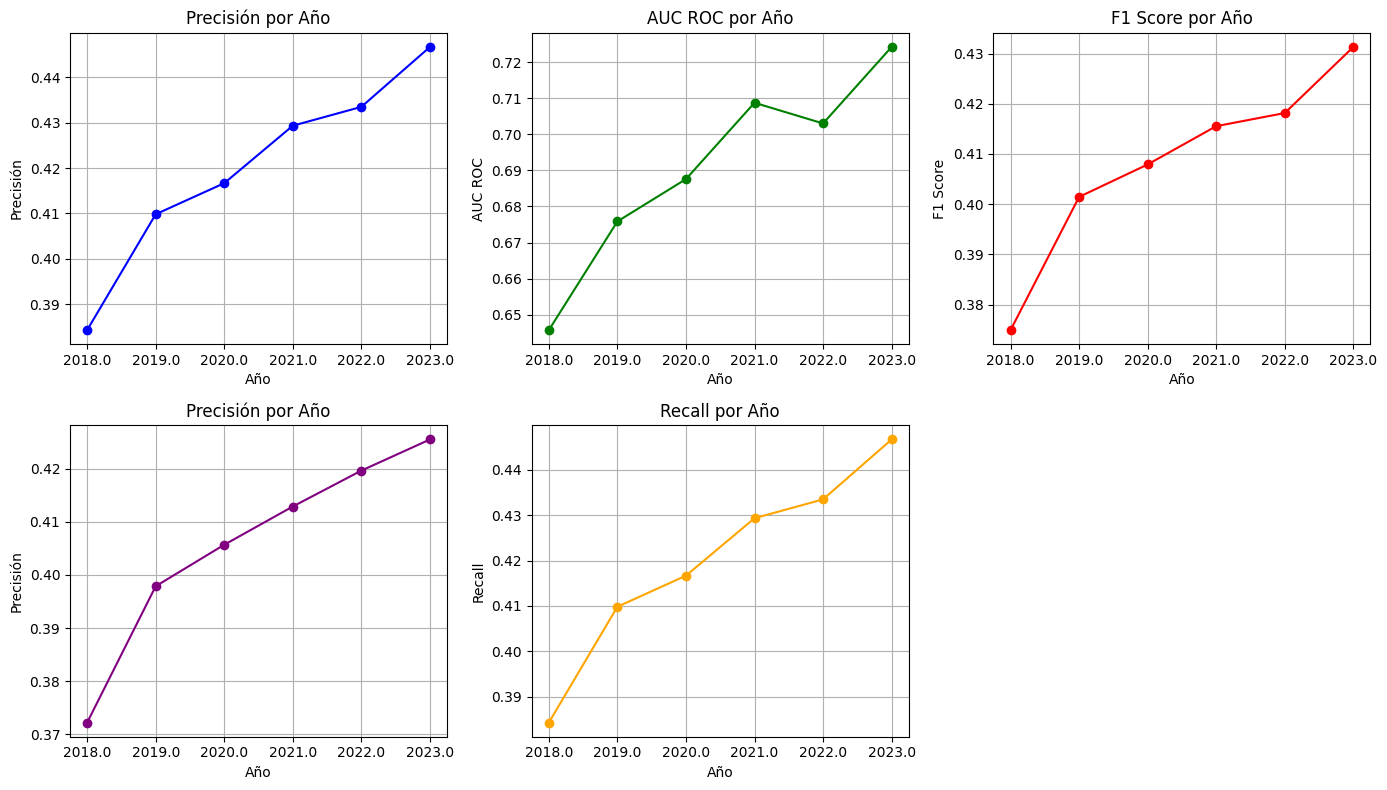

In [ ]:
# Crear un DataFrame con las métricas
metrics_df = pd.DataFrame(metric_results)

# Graficar las métricas con líneas para evaluar el desempeño a lo largo de los años
plt.figure(figsize=(14, 8))

# Graficar precisión
plt.subplot(2, 3, 1)
plt.plot(metrics_df['Year'], metrics_df['Accuracy'], marker='o', color='b', label='Accuracy')
plt.title('Precisión por Año')
plt.xlabel('Año')
plt.ylabel('Precisión')
plt.grid(True)

# Graficar AUC ROC
plt.subplot(2, 3, 2)
plt.plot(metrics_df['Year'], metrics_df['ROC AUC'], marker='o', color='g', label='ROC AUC')
plt.title('AUC ROC por Año')
plt.xlabel('Año')
plt.ylabel('AUC ROC')
plt.grid(True)

# Graficar F1 Score
plt.subplot(2, 3, 3)
plt.plot(metrics_df['Year'], metrics_df['F1 Score'], marker='o', color='r', label='F1 Score')
plt.title('F1 Score por Año')
plt.xlabel('Año')
plt.ylabel('F1 Score')
plt.grid(True)

# Graficar Precision
plt.subplot(2, 3, 4)
plt.plot(metrics_df['Year'], metrics_df['Precision'], marker='o', color='purple', label='Precision')
plt.title('Precisión por Año')
plt.xlabel('Año')
plt.ylabel('Precisión')
plt.grid(True)

# Graficar Recall
plt.subplot(2, 3, 5)
plt.plot(metrics_df['Year'], metrics_df['Recall'], marker='o', color='orange', label='Recall')
plt.title('Recall por Año')
plt.xlabel('Año')
plt.ylabel('Recall')
plt.grid(True)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

#### Variables de interés

 `Características más importantes para 2019:`

- **Estado Actual**: El **Acuerdo de Reestructuración** y el estado **Activo** son altamente relevantes, lo que sugiere que el estado financiero y contractual tiene un impacto significativo en la clasificación de las empresas.
- **Ubicación Geográfica**: Variables como el **Departamento de la Dirección del Domicilio**, especialmente **Bolívar** y **Huila**, son influyentes, indicando que la ubicación geográfica tiene un efecto considerable en las predicciones.
- **Indicadores Financieros**: El **ROA (Return on Assets)** destaca como un indicador clave de rentabilidad, subrayando la importancia de los factores financieros en la clasificación empresarial.
- **Clasificación de la Empresa**: La **Clasificación Industrial Internacional Uniforme (CIIU)** es otra variable importante, con sectores como **Alojamiento y Servicios de Comida**, **Agricultura y Ganadería**, y **Actividades Financieras y de Seguros** siendo especialmente relevantes.

`Características más importantes para 2020:`

- **Estado Actual**: La variable **Acuerdo de Reorganización** es más relevante en 2020, indicando la importancia de las reestructuraciones empresariales.
- **Ubicación Geográfica**: Se destacan departamentos como **Boyacá**, además de **Huila**, que mantiene su relevancia.
- **Clasificación Industrial Internacional Uniforme (CIIU)**: Las categorías de **Agricultura, Ganadería, Caza, Silvicultura y Pesca**, y **Actividades Inmobiliarias** son especialmente importantes en 2020.
- **Indicadores Financieros**: El **ROA** y la **Generación de Efectivo** siguen siendo factores clave.

`Características más importantes para 2021:`

- **Estado Actual**: El estado **Activo** y **Acuerdo de Reorganización** tienen una gran influencia en las predicciones.
- **Ubicación Geográfica**: Se observan los departamentos de **Cundinamarca**, **Meta**, además de **Huila** y **Bolívar**, lo que resalta la importancia de la localización empresarial.
- **Clasificación Industrial Internacional Uniforme (CIIU)**: Sectores como **Agricultura, Ganadería, Caza, Silvicultura y Pesca** y **Actividades Inmobiliarias** siguen siendo relevantes.
- **Revisor Fiscal**: La variable **Concepto del Revisor Fiscal** también es relevante, especialmente con valores como **No Aplica**.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 5278, number of used features: 5
[LightGBM] [Info] Start training from score -1.252763
[LightGBM] [Info] Start training from score -1.521180
[LightGBM] [Info] Start training from score -3.164131
[LightGBM] [Info] Start training from score -2.230943
[LightGBM] [Info] Start training from score -1.060872


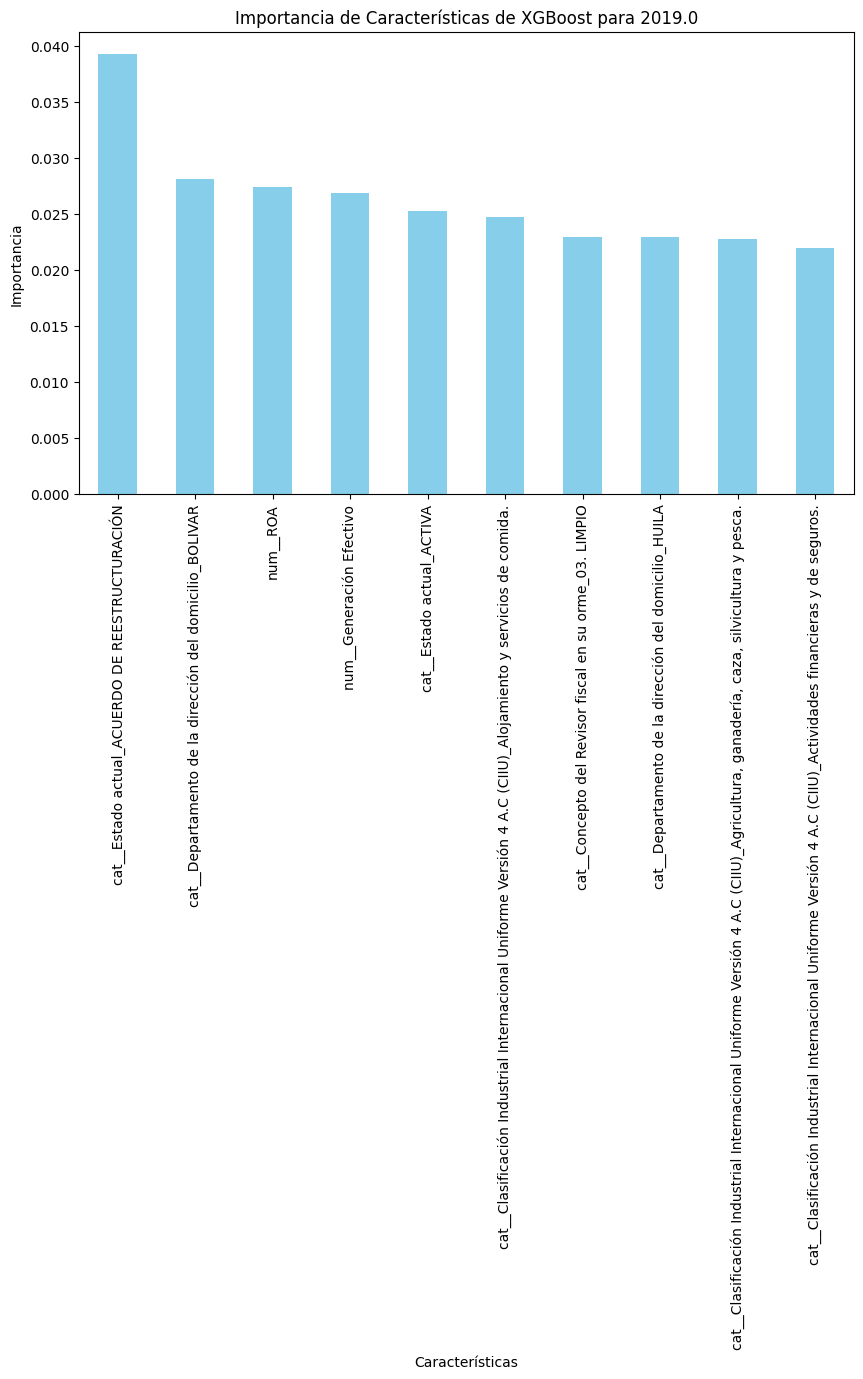


Matriz de confusión para el año 2019.0:
[[1225   71    0   15  197]
 [  85  934    0   20  114]
 [   1    5  215    2    0]
 [  25   50    1  453   38]
 [  99   93    0   12 1623]]

Reporte de clasificación para el año 2019.0:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1508
           1       0.81      0.81      0.81      1153
           2       1.00      0.96      0.98       223
           3       0.90      0.80      0.85       567
           4       0.82      0.89      0.85      1827

    accuracy                           0.84      5278
   macro avg       0.88      0.85      0.86      5278
weighted avg       0.84      0.84      0.84      5278



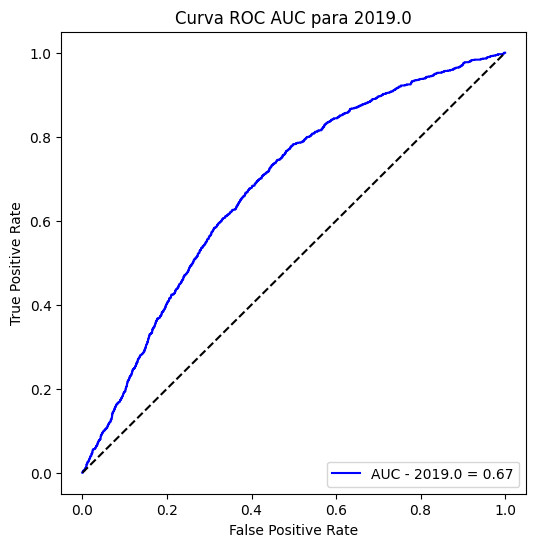

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 5832, number of used features: 5
[LightGBM] [Info] Start training from score -1.419770
[LightGBM] [Info] Start training from score -1.500227
[LightGBM] [Info] Start training from score -2.957382
[LightGBM] [Info] Start training from score -1.990261
[LightGBM] [Info] Start training from score -1.059768


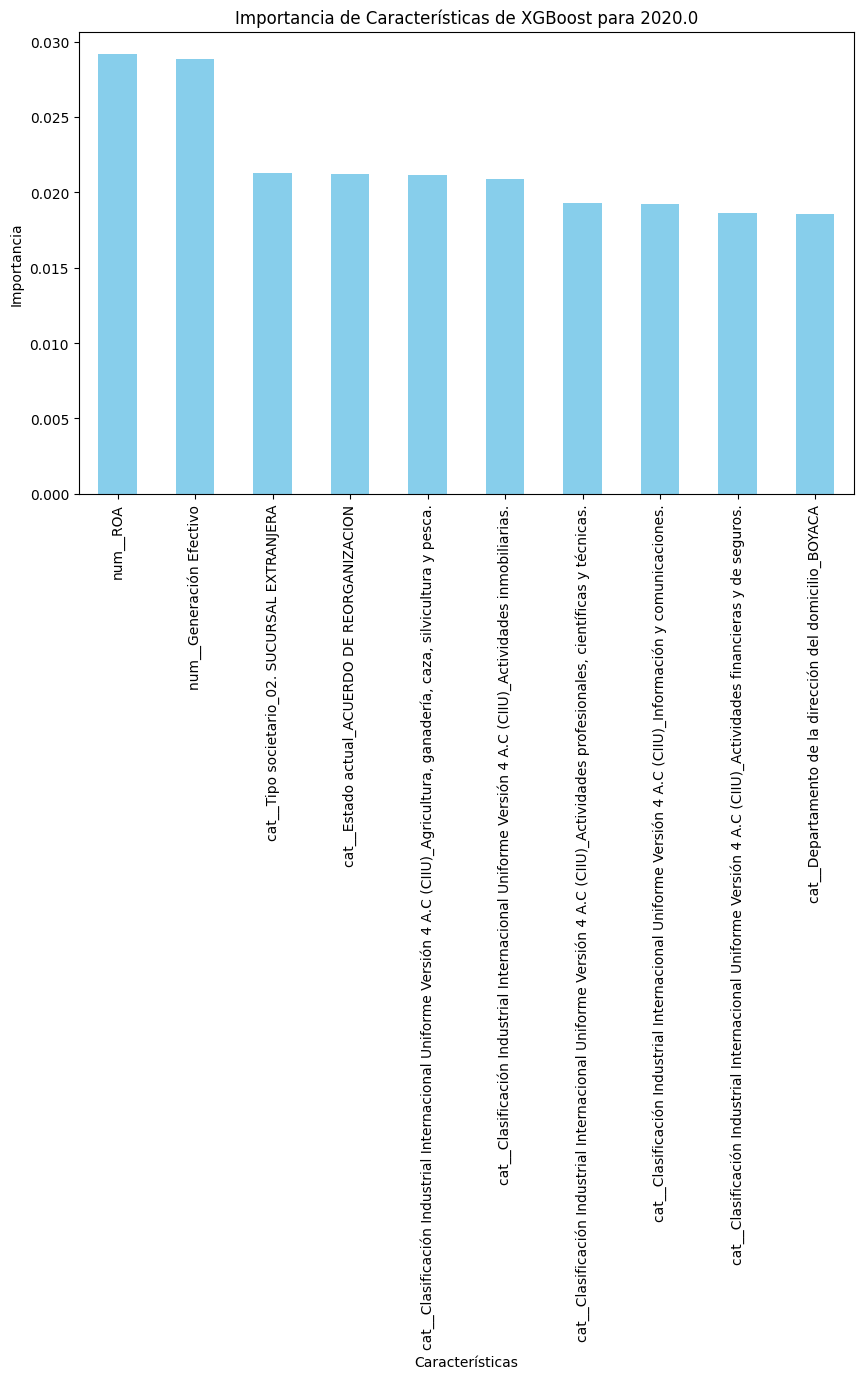


Matriz de confusión para el año 2020.0:
[[ 986  159    2   26  237]
 [  63 1084    0   38  116]
 [   4   26  248   16    9]
 [  23   75    1  623   75]
 [  70  142    1   33 1775]]

Reporte de clasificación para el año 2020.0:
              precision    recall  f1-score   support

           0       0.86      0.70      0.77      1410
           1       0.73      0.83      0.78      1301
           2       0.98      0.82      0.89       303
           3       0.85      0.78      0.81       797
           4       0.80      0.88      0.84      2021

    accuracy                           0.81      5832
   macro avg       0.84      0.80      0.82      5832
weighted avg       0.82      0.81      0.81      5832



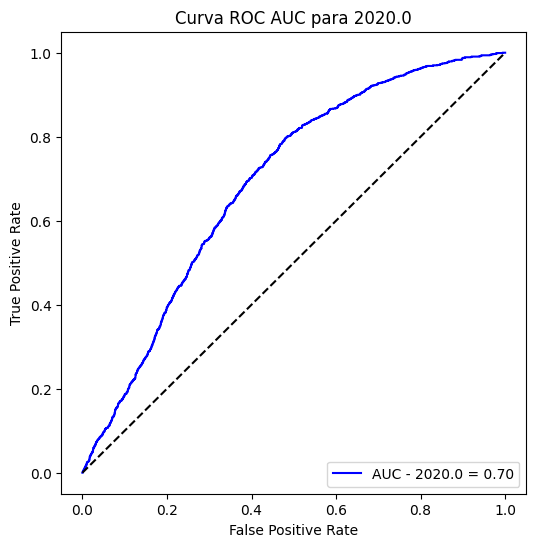

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 5895, number of used features: 5
[LightGBM] [Info] Start training from score -1.399786
[LightGBM] [Info] Start training from score -1.467355
[LightGBM] [Info] Start training from score -2.841218
[LightGBM] [Info] Start training from score -1.943707
[LightGBM] [Info] Start training from score -1.135414


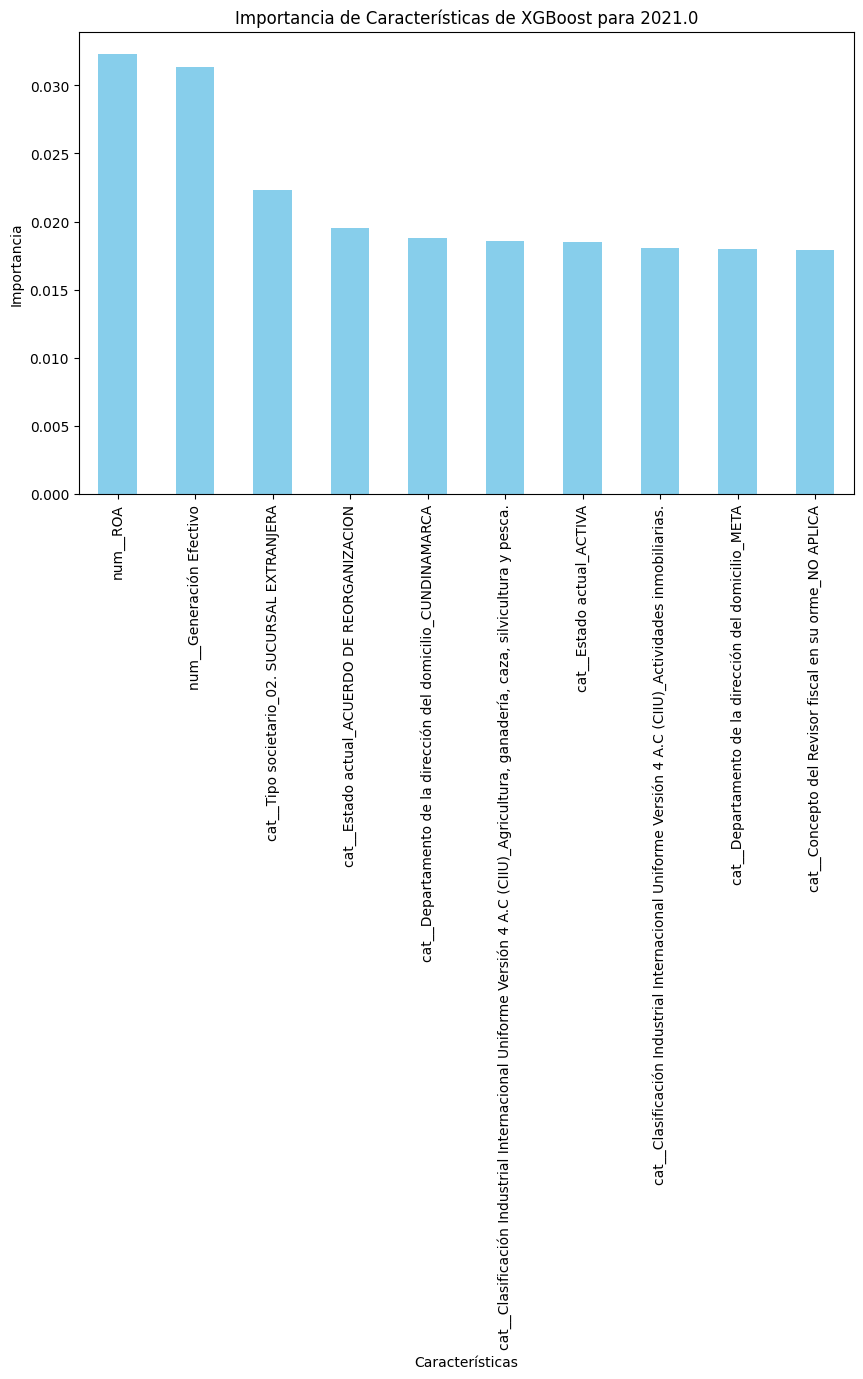


Matriz de confusión para el año 2021.0:
[[1068  144    1   42  199]
 [  80 1139    1   52   87]
 [   3   33  269   31    8]
 [  23   88    0  672   61]
 [ 121  133    1   30 1609]]

Reporte de clasificación para el año 2021.0:
              precision    recall  f1-score   support

           0       0.82      0.73      0.78      1454
           1       0.74      0.84      0.79      1359
           2       0.99      0.78      0.87       344
           3       0.81      0.80      0.80       844
           4       0.82      0.85      0.83      1894

    accuracy                           0.81      5895
   macro avg       0.84      0.80      0.82      5895
weighted avg       0.81      0.81      0.81      5895



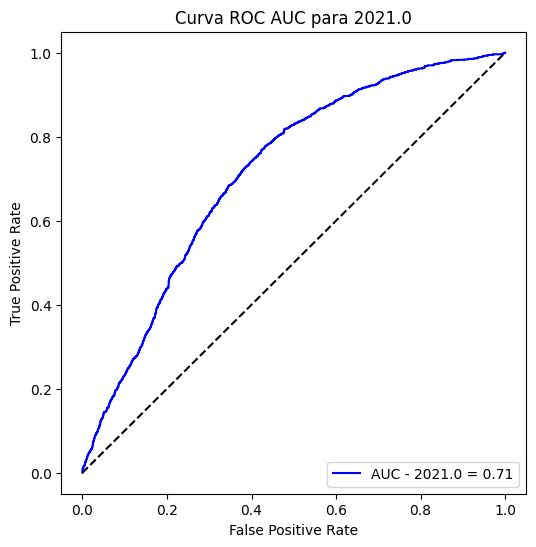

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 5910, number of used features: 5
[LightGBM] [Info] Start training from score -1.381231
[LightGBM] [Info] Start training from score -1.534484
[LightGBM] [Info] Start training from score -2.916080
[LightGBM] [Info] Start training from score -1.847068
[LightGBM] [Info] Start training from score -1.135318


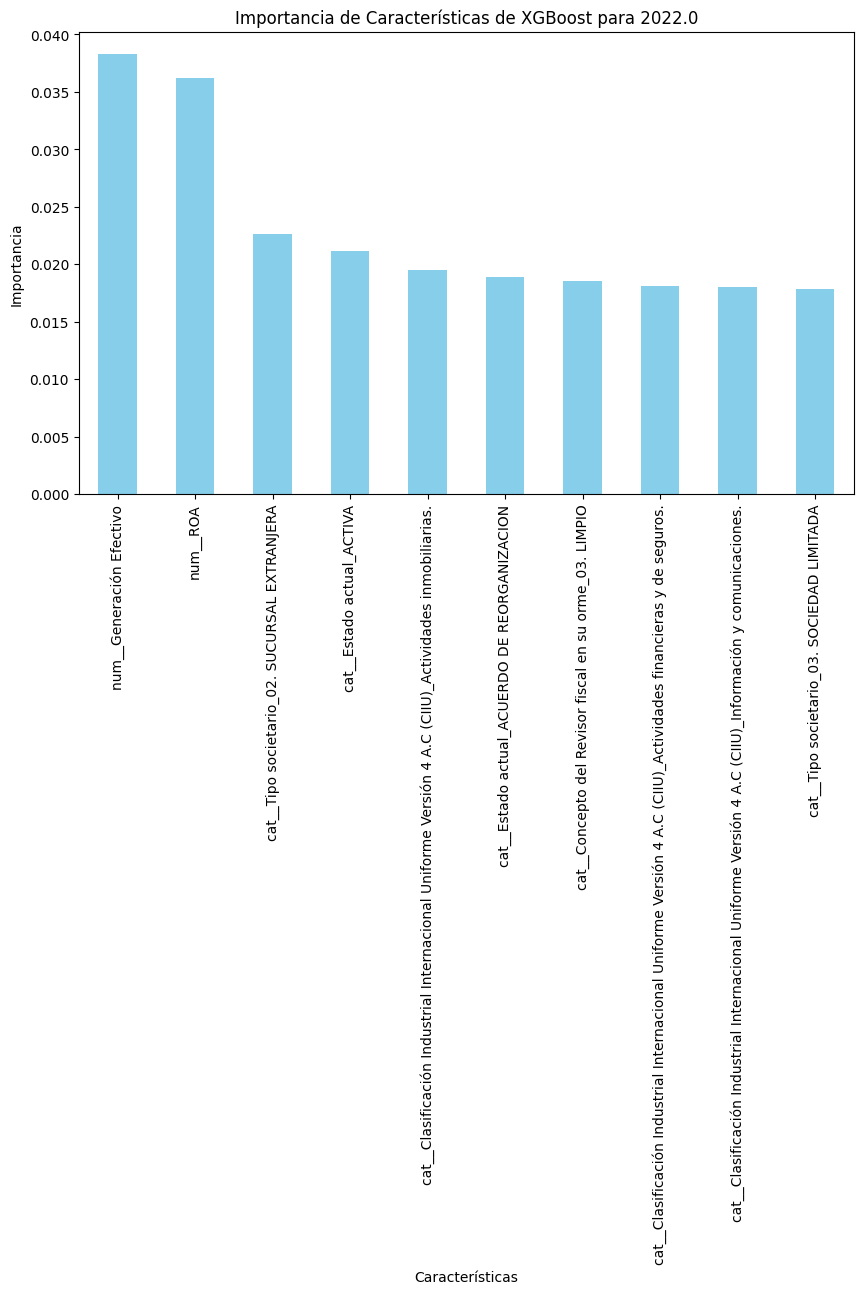


Matriz de confusión para el año 2022.0:
[[1112  122    1   24  226]
 [  92 1017    0   72   93]
 [  11   39  246   21    3]
 [  57   80    4  700   91]
 [ 145  135    1   24 1594]]

Reporte de clasificación para el año 2022.0:
              precision    recall  f1-score   support

           0       0.78      0.75      0.77      1485
           1       0.73      0.80      0.76      1274
           2       0.98      0.77      0.86       320
           3       0.83      0.75      0.79       932
           4       0.79      0.84      0.82      1899

    accuracy                           0.79      5910
   macro avg       0.82      0.78      0.80      5910
weighted avg       0.79      0.79      0.79      5910



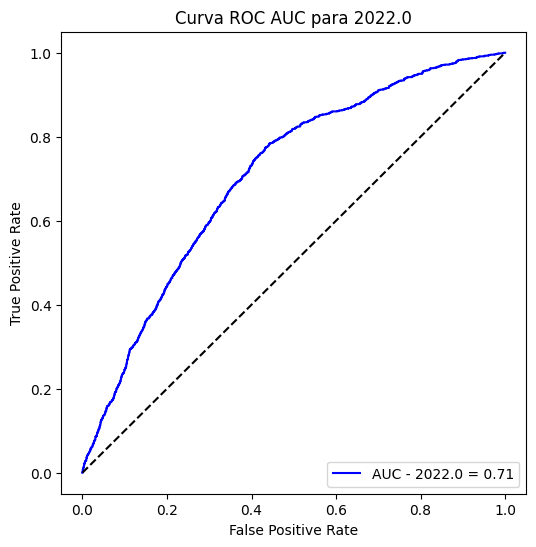

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 5818, number of used features: 5
[LightGBM] [Info] Start training from score -1.311794
[LightGBM] [Info] Start training from score -1.449802
[LightGBM] [Info] Start training from score -3.016223
[LightGBM] [Info] Start training from score -2.014559
[LightGBM] [Info] Start training from score -1.159377


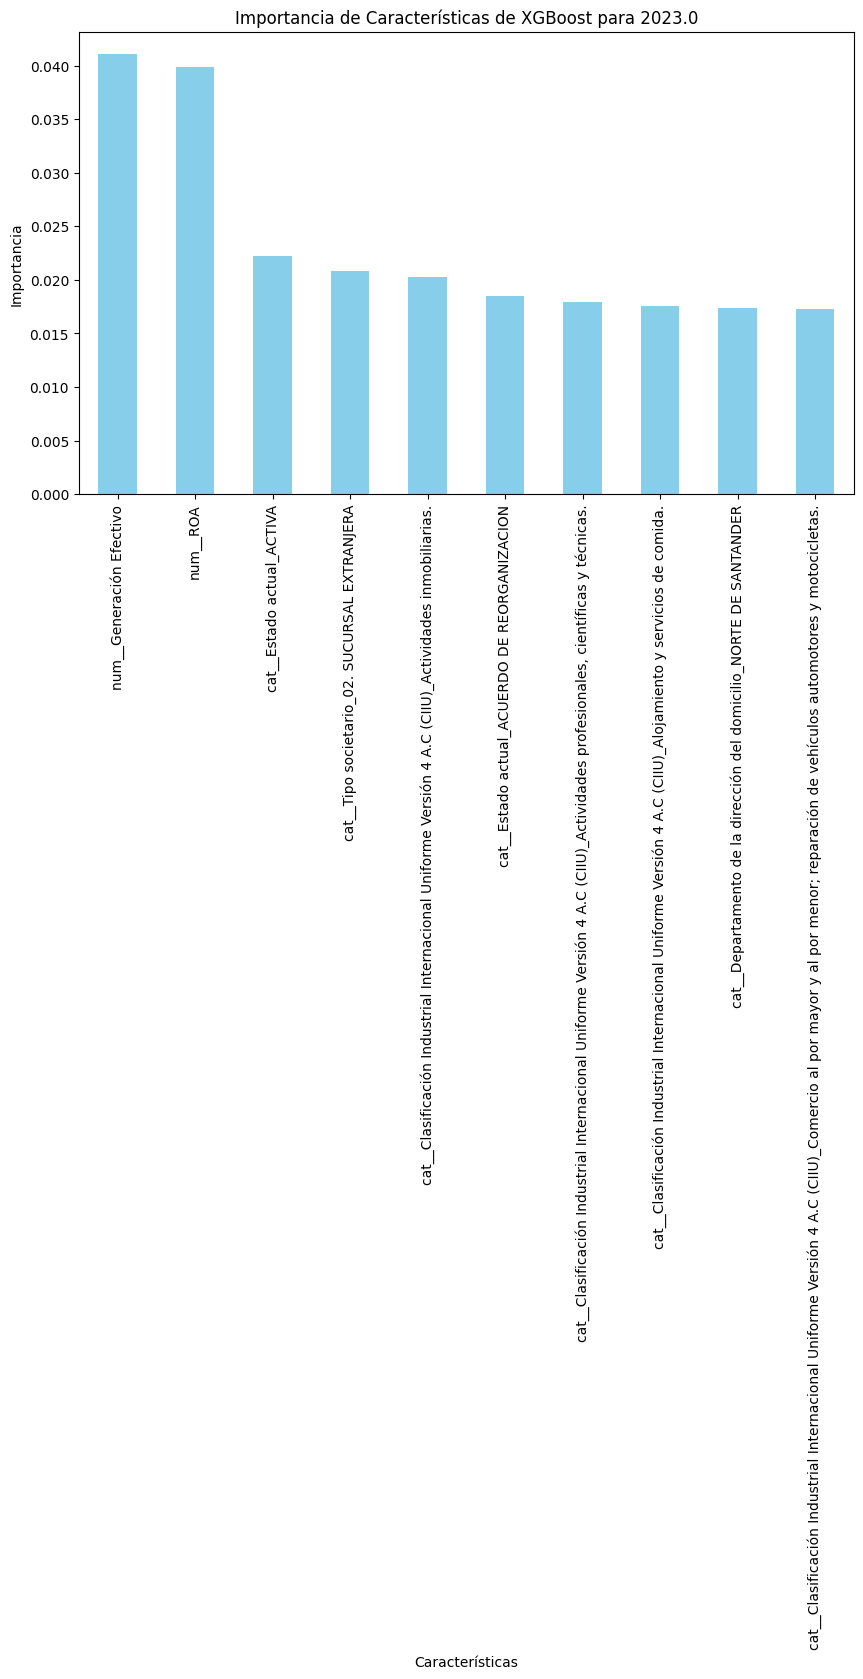


Matriz de confusión para el año 2023.0:
[[1178  170    2   12  205]
 [  90 1169    0   47   59]
 [   7   39  226    8    5]
 [  42  102    0  588   44]
 [ 158  170    0   17 1480]]

Reporte de clasificación para el año 2023.0:
              precision    recall  f1-score   support

           0       0.80      0.75      0.77      1567
           1       0.71      0.86      0.78      1365
           2       0.99      0.79      0.88       285
           3       0.88      0.76      0.81       776
           4       0.83      0.81      0.82      1825

    accuracy                           0.80      5818
   macro avg       0.84      0.79      0.81      5818
weighted avg       0.81      0.80      0.80      5818



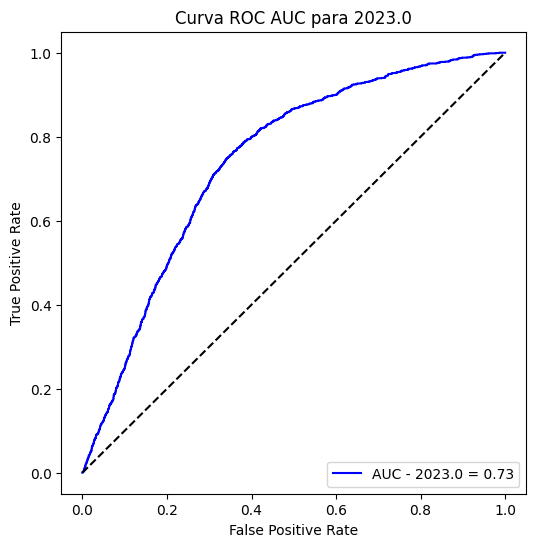


Resultados finales:
{'Year': [2018.0, 2019.0, 2020.0, 2021.0, 2022.0, 2023.0, 2019.0, 2019.0, 2020.0, 2021.0, 2022.0, 2023.0], 'Accuracy': [0.3626777832270721, 0.36566881394467604, 0.37002743484224965, 0.3453774385072095, 0.3431472081218274, 0.34307322103815746, 0.8431223948465327, 0.8431223948465327, 0.808641975308642, 0.8069550466497032, 0.7900169204737733, 0.7976968030250945], 'ROC AUC': [0.6488762224899749, 0.6820701090356294, 0.697629609710547, 0.7145356483603204, 0.707111788472079, 0.7313980736980332, 0.6728981328393386, 0.6728981328393386, 0.6950021521115682, 0.7121956832980948, 0.7063929039183371, 0.7296324884676971], 'F1 Score': [0.2719444199294976, 0.25735628985459635, 0.252425669196193, 0.22004749873860752, 0.21479895401054658, 0.2700139430735719, 0.8430109465837312, 0.8430109465837312, 0.8081915396701109, 0.8070990643800849, 0.7903176630284857, 0.7986519996993703], 'Precision': [0.3607830269696692, 0.3862917953457199, 0.405527454389417, 0.4183818613399212, 0.44195482376836

In [ ]:
# Crear un diccionario para almacenar las importancias de las características por año
feature_importances = {}

# Ciclo para la validación secuencial por año
for i in range(1, len(years)):  # Comenzamos desde el segundo año
    # Usamos los años anteriores para entrenamiento y el año actual para prueba
    train_years = years[:i]  # Datos de entrenamiento hasta el año i-1
    test_year = years[i]     # Año para prueba

    # Filtrar los datos de entrenamiento y prueba
    X_train = data_filter_imputed[data_filter_imputed['Fecha de Corte'].isin(train_years)].drop(columns=exclude_columns)
    y_train = data_filter_imputed[data_filter_imputed['Fecha de Corte'].isin(train_years)]['FDC_FLC_categoria']
    X_test = data_filter_imputed[data_filter_imputed['Fecha de Corte'] == test_year].drop(columns=exclude_columns)
    y_test = data_filter_imputed[data_filter_imputed['Fecha de Corte'] == test_year]['FDC_FLC_categoria']

    # Codificar las etiquetas de la variable objetivo
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Pipeline de XGBoost como modelo base
    xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=len(np.unique(y_train_encoded)), eval_metric='mlogloss')

    # Crear el pipeline con preprocesador y el clasificador
    pipeline_xgb = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Preprocesamiento
        ('classifier', xgb_model)  # Clasificador XGBoost
    ])

    # Entrenamiento de XGBoost
    pipeline_xgb.fit(X_train, y_train_encoded)

    # Predicciones de XGBoost
    y_pred_xgb_proba = pipeline_xgb.predict_proba(X_test)  # Probabilidades de XGBoost
    y_pred_xgb = pipeline_xgb.predict(X_test)  # Predicciones de XGBoost

    # Añadir las probabilidades de XGBoost como nuevas características para LightGBM
    X_meta = pd.DataFrame(y_pred_xgb_proba, columns=[f'class_{i}' for i in range(y_pred_xgb_proba.shape[1])])

    # Pipeline de LightGBM
    lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=len(np.unique(y_train_encoded)), metric='multi_logloss')
    pipeline_lgb = Pipeline(steps=[
        ('classifier', lgb_model)  # Clasificador LightGBM
    ])

    # Entrenamiento de LightGBM con las predicciones de XGBoost
    pipeline_lgb.fit(X_meta, y_test_encoded)

    # Predicciones finales con LightGBM
    y_pred_final = pipeline_lgb.predict(X_meta)

    # Calcular las métricas de evaluación
    accuracy = accuracy_score(y_test_encoded, y_pred_final)
    roc_auc = roc_auc_score(y_test_encoded, y_pred_xgb_proba, multi_class='ovr')  # Usamos las probabilidades para el cálculo de ROC AUC
    f1 = f1_score(y_test_encoded, y_pred_final, average='weighted')
    precision = precision_score(y_test_encoded, y_pred_final, average='weighted')
    recall = recall_score(y_test_encoded, y_pred_final, average='weighted')
    conf_matrix = confusion_matrix(y_test_encoded, y_pred_final)
    class_report = classification_report(y_test_encoded, y_pred_final)

    # Guardar los resultados
    results['Year'].append(test_year)
    results['Accuracy'].append(accuracy)
    results['ROC AUC'].append(roc_auc)
    results['F1 Score'].append(f1)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['Confusion Matrix'].append(conf_matrix)
    results['Classification Report'].append(class_report)

     # Obtener la importancia de las características de XGBoost
    xgb_importance = pipeline_xgb.named_steps['classifier'].feature_importances_

    # Get feature names after preprocessing
    feature_names = pipeline_xgb.named_steps['preprocessor'].get_feature_names_out()

    # Create Series with correct index
    feature_importances[test_year] = pd.Series(xgb_importance, index=feature_names).sort_values(ascending=False)

    # Graficar la importancia de las características para XGBoost
    plt.figure(figsize=(10, 6))
    feature_importances[test_year].head(10).plot(kind='bar', color='skyblue')
    plt.title(f'Importancia de Características de XGBoost para {test_year}')
    plt.xlabel('Características')
    plt.ylabel('Importancia')
    plt.show()

    # Mostrar la matriz de confusión
    print(f"\nMatriz de confusión para el año {test_year}:")
    print(conf_matrix)

    # Mostrar el reporte de clasificación
    print(f"\nReporte de clasificación para el año {test_year}:")
    print(class_report)

    # Graficar la curva ROC
    fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_xgb_proba[:, 1], pos_label=1)  # Para la clase positiva
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='b', label=f'AUC - {test_year} = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='k', linestyle='--')
    plt.title(f'Curva ROC AUC para {test_year}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Imprimir los resultados finales
print("\nResultados finales:")
print(results)


In [ ]:
import pickle

# Guardar el pipeline de XGBoost en un archivo .pkl
with open(f"xgb_model_{test_year}.pkl", "wb") as f:
    pickle.dump(pipeline_xgb, f)

# Guardar el pipeline de LightGBM en un archivo .pkl
with open(f"lgb_model_{test_year}.pkl", "wb") as f:
    pickle.dump(pipeline_lgb, f)

# Confirmación de que el modelo fue guardado correctamente
print(f"Modelos XGBoost y LightGBM para el año {test_year} guardados como archivos .pkl.")


Modelos XGBoost y LightGBM para el año 2023.0 guardados como archivos .pkl.


### Importancia de variables a lo largo de lso años

<ipython-input-25-5c403ac076d9>:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Ajusta el layout para que se vea bien


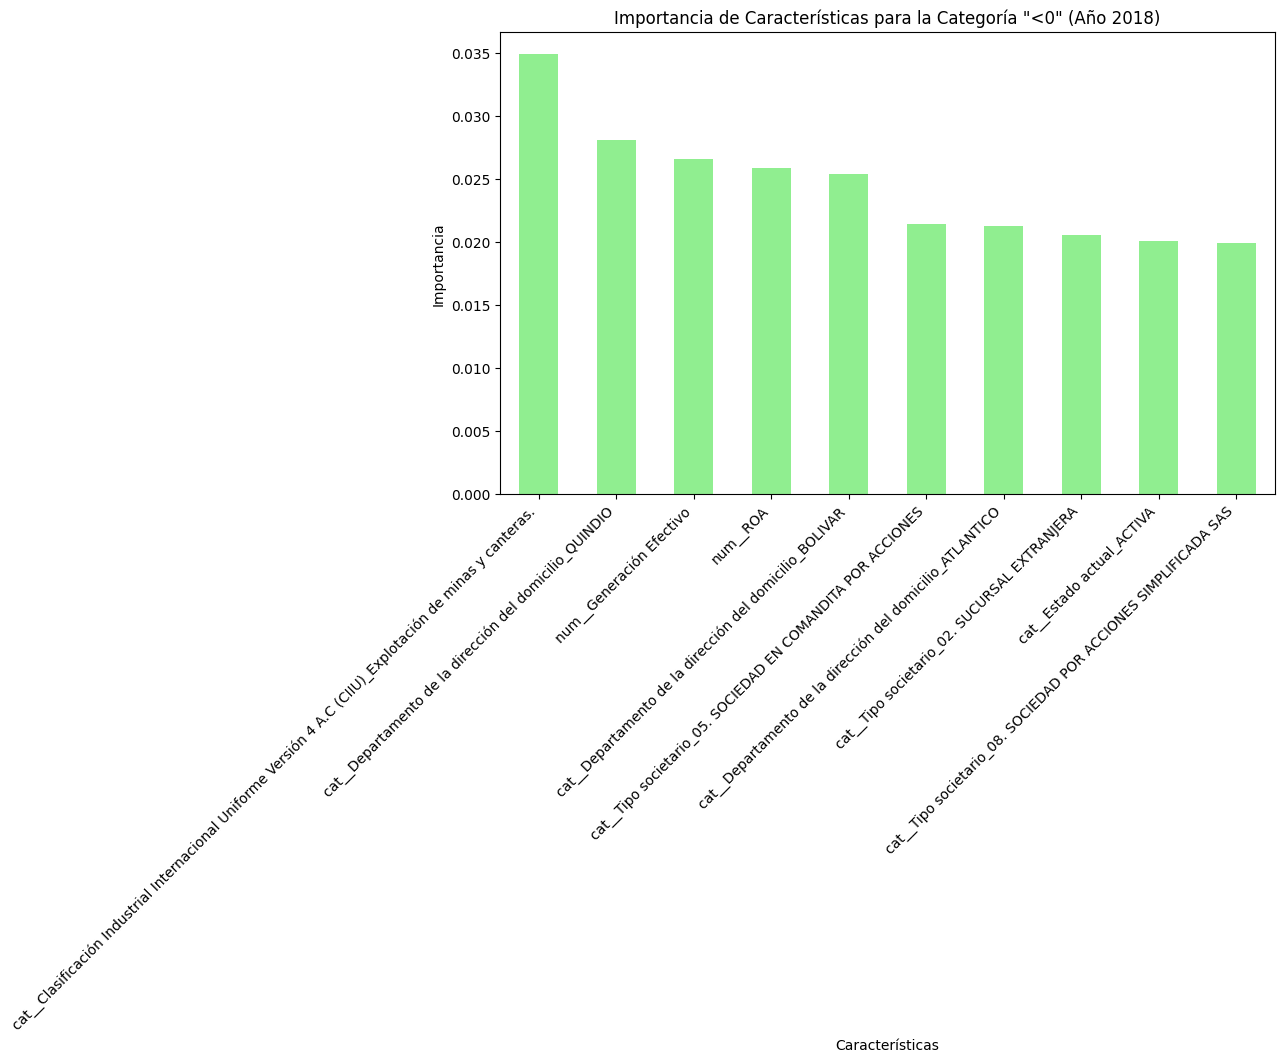

<ipython-input-25-5c403ac076d9>:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Ajusta el layout para que se vea bien


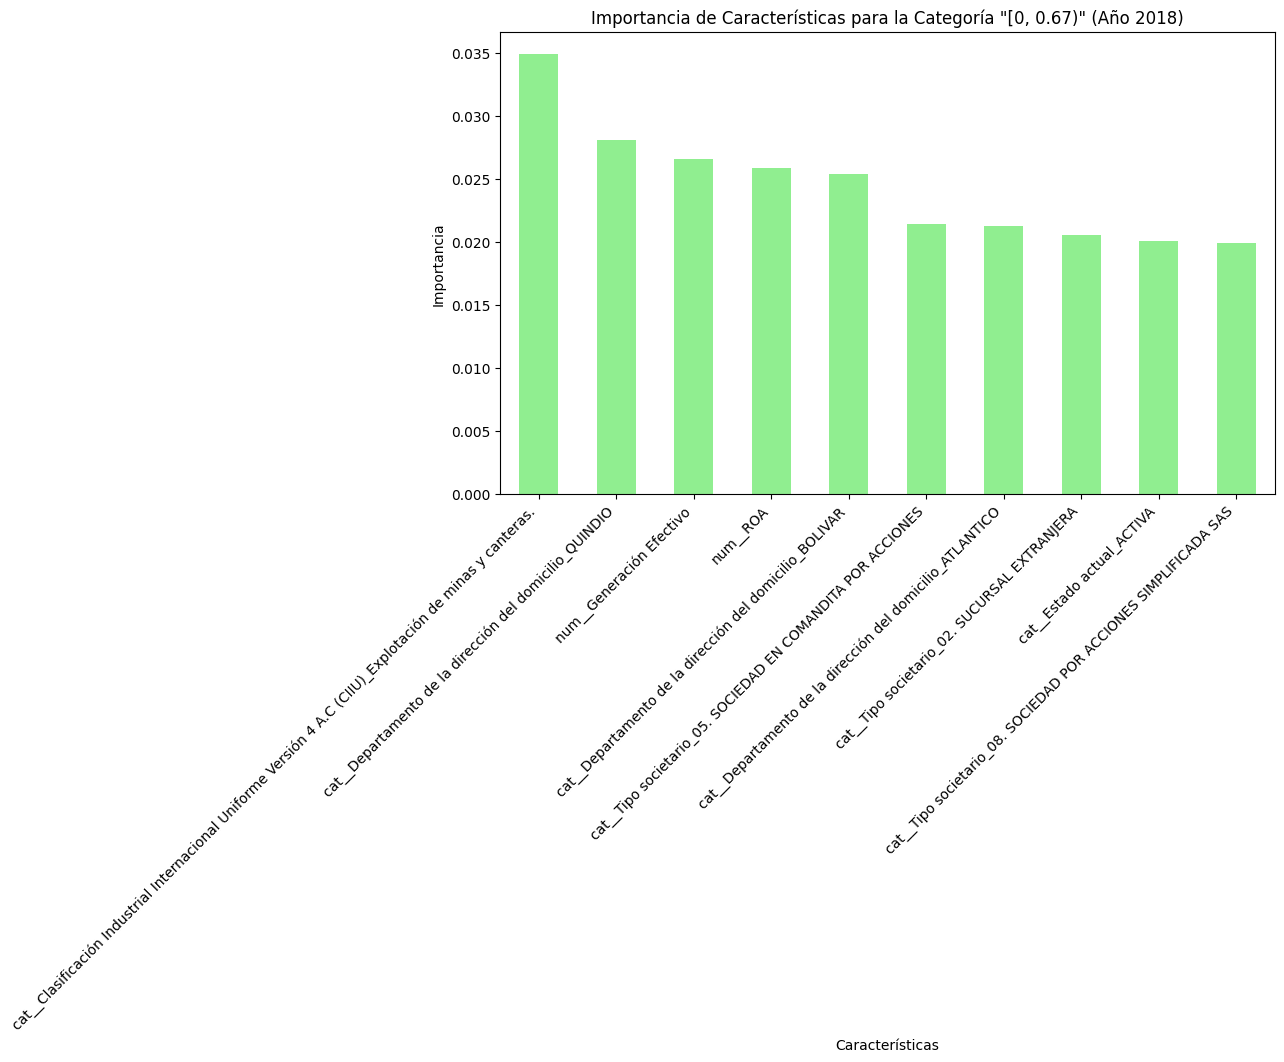

<ipython-input-25-5c403ac076d9>:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Ajusta el layout para que se vea bien


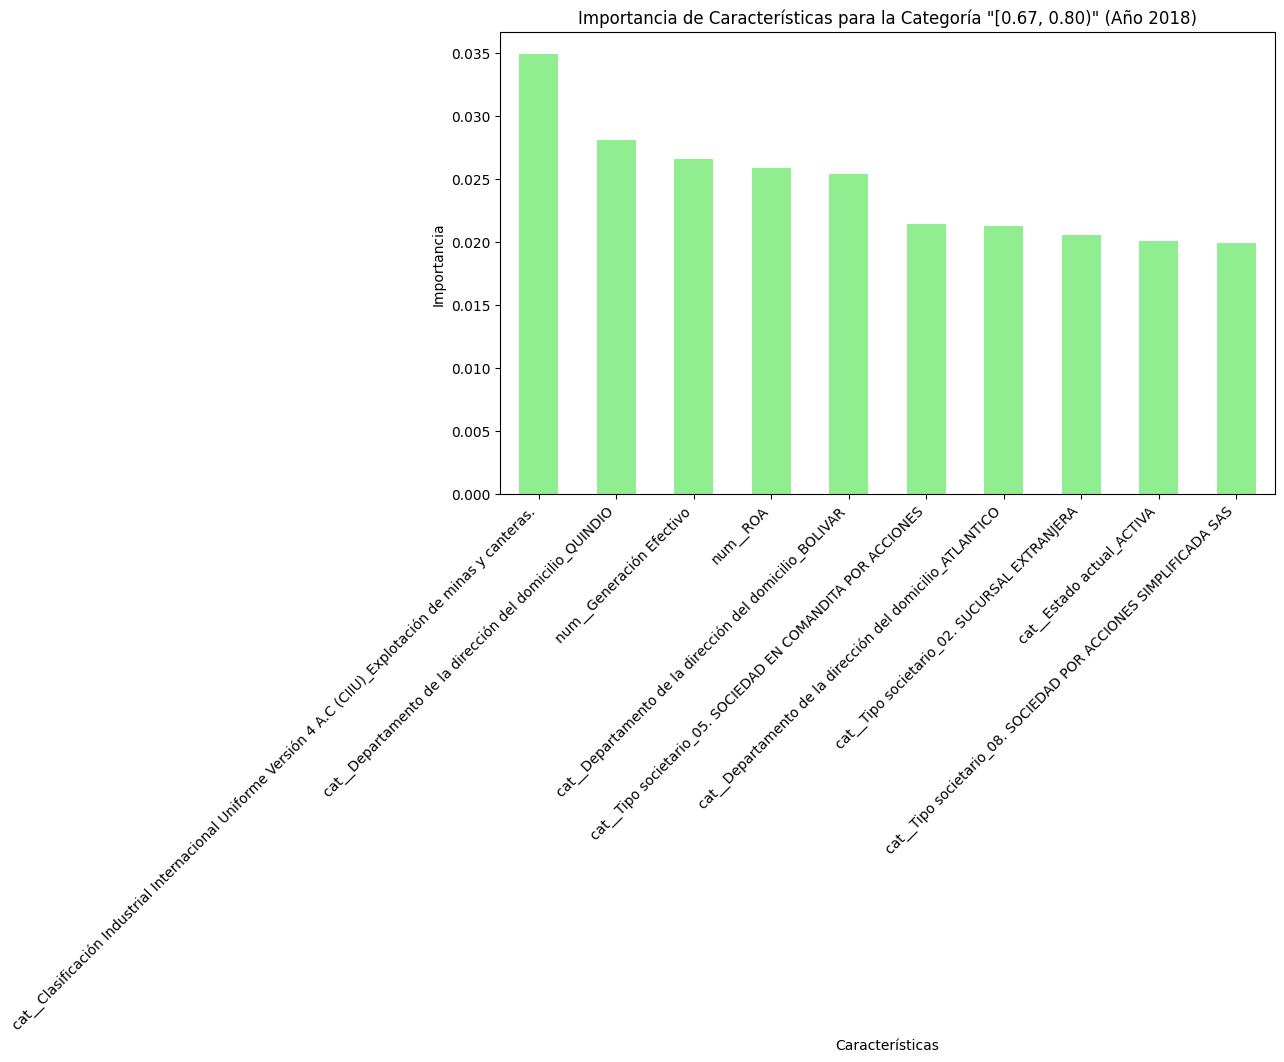

<ipython-input-25-5c403ac076d9>:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Ajusta el layout para que se vea bien


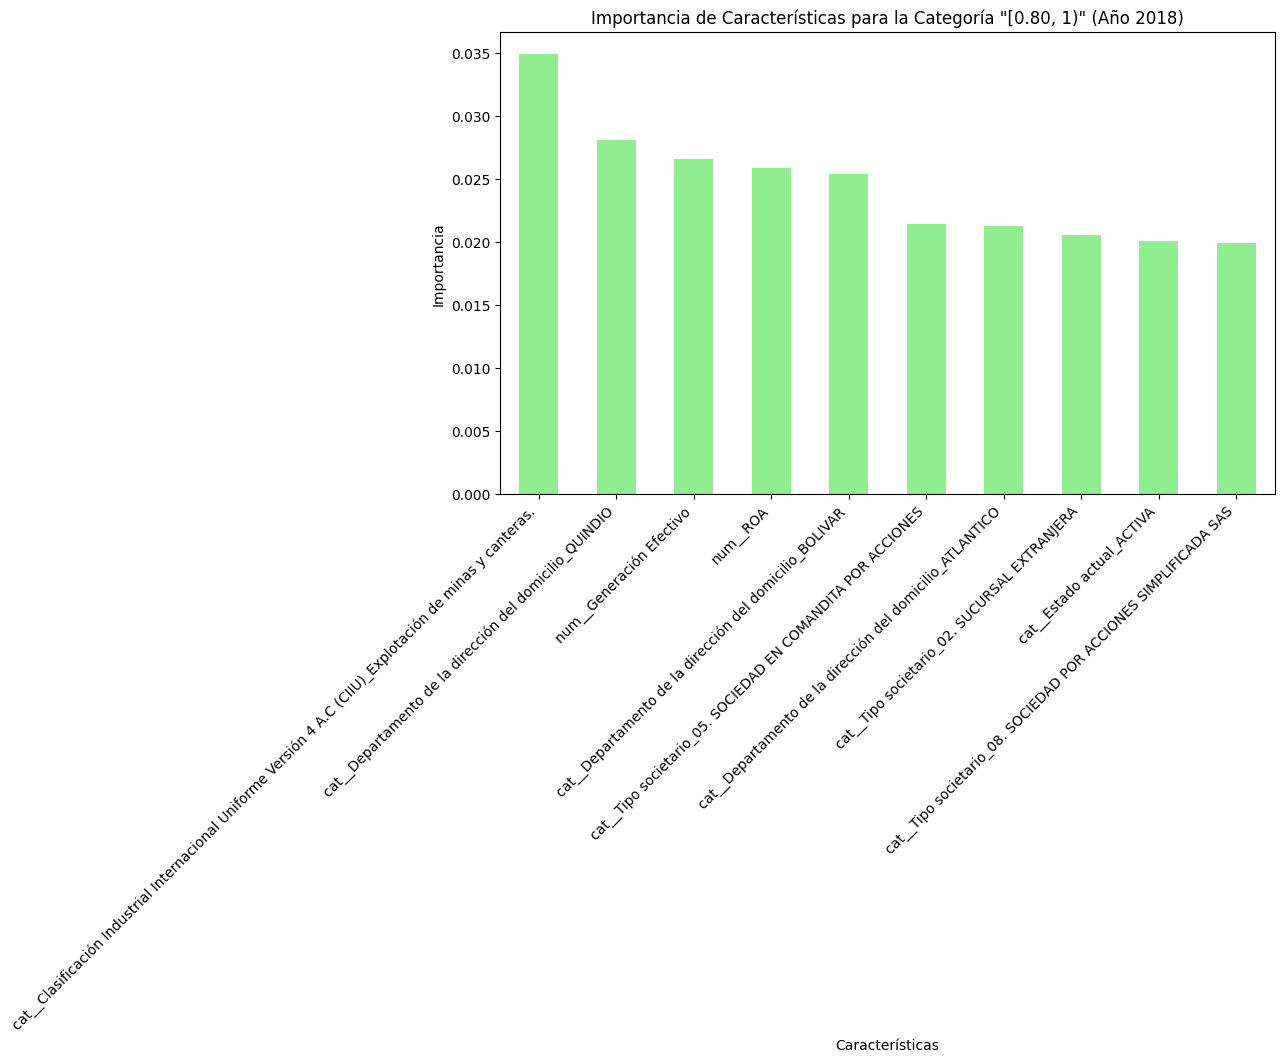

<ipython-input-25-5c403ac076d9>:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Ajusta el layout para que se vea bien


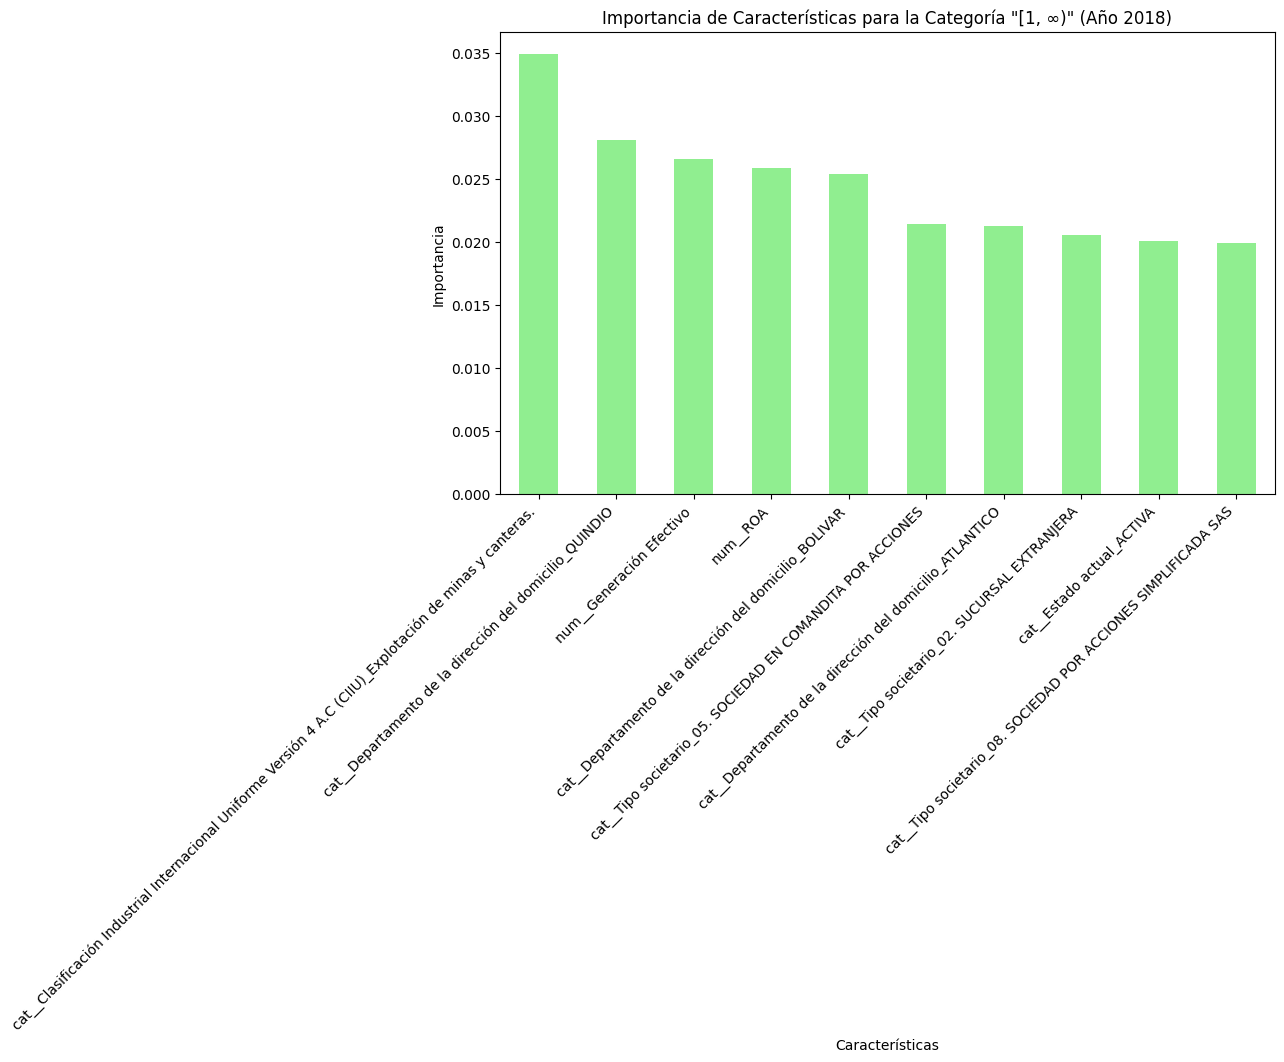

In [ ]:
# Obtener el nombre de las clases (categorías de clasificación)
class_names = label_encoder.classes_

for i, class_name in enumerate(class_names):
    plt.figure(figsize=(10, 6))
    feature_importances[2018.0].head(10).plot(kind='bar', color='lightgreen')

    # Configurar el gráfico
    plt.title(f'Importancia de Características para la Categoría "{class_name}" (Año 2018)')
    plt.xlabel('Características')
    plt.ylabel('Importancia')
    plt.xticks(rotation=45, ha='right')  # Rotamos las etiquetas de las características
    plt.tight_layout()  # Ajusta el layout para que se vea bien
    plt.show()



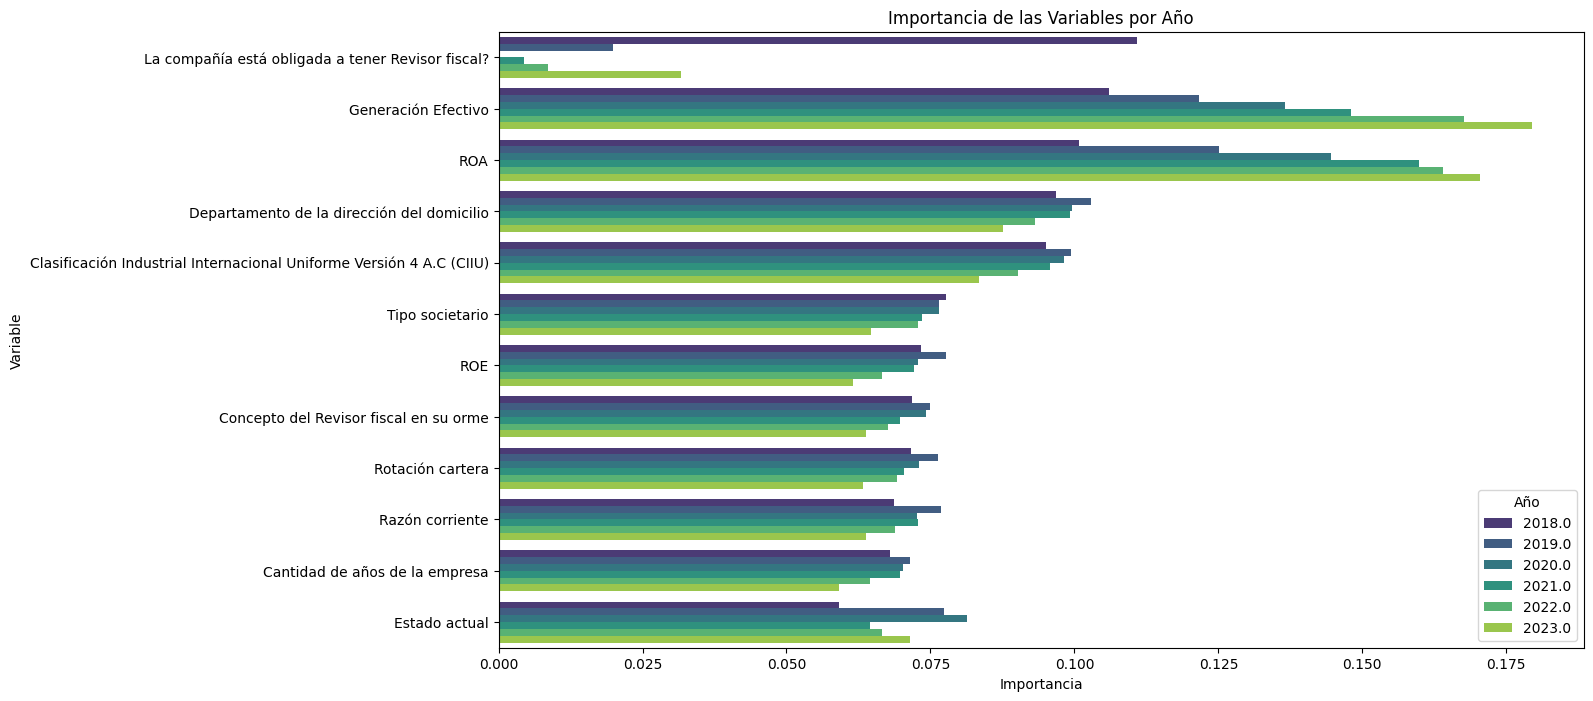

In [ ]:
# Graficar la importancia de las variables por año
plt.figure(figsize=(14, 8))
sns.barplot(data=importance_df, x='Importancia', y='Variable', hue='Año', orient='h', palette="viridis")
plt.title('Importancia de las Variables por Año')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.legend(title='Año')
plt.show()

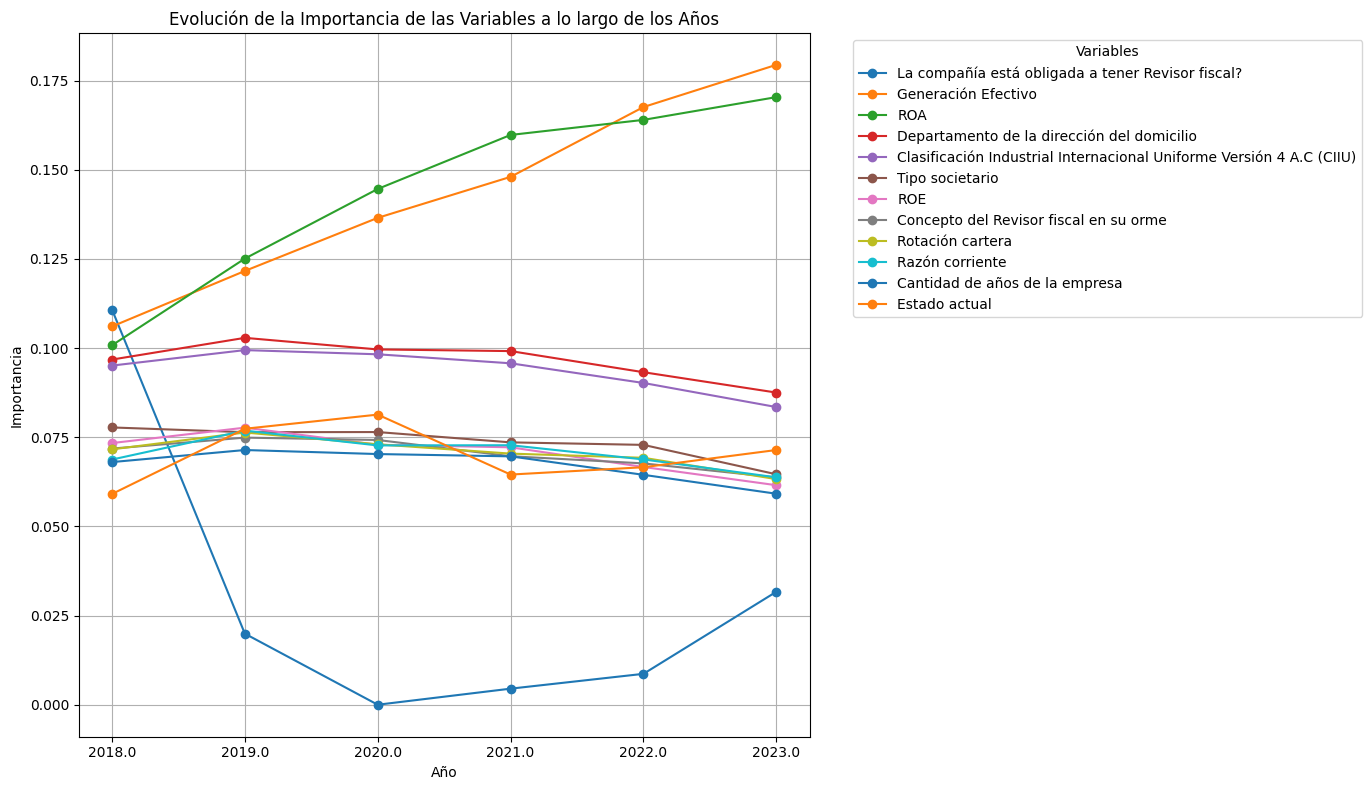

In [ ]:
plt.title('Evolución de la Importancia de las Variables a lo largo de los Años')
plt.xlabel('Año')
plt.ylabel('Importancia')
plt.legend(title='Variables', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Mostrar la gráfica
plt.tight_layout()
plt.show()


### Supuestos del modelo


#### Calculo de probabilidades de clasificacion en clases

In [ ]:
# Realizamos predicciones utilizando el modelo LightGBM
y_pred_proba = pipeline_lgb.predict_proba(X_meta)  # Probabilidades para todas las clases

# Obtener las clases predichas (la clase con mayor probabilidad)
y_pred_final = np.argmax(y_pred_proba, axis=1)

# Residuos en clasificación: calculamos la diferencia entre la probabilidad de la clase correcta y 1
residuals = []
for i in range(len(y_test_encoded)):
    # Access element using integer indexing for NumPy arrays
    true_class = y_test_encoded[i]
    predicted_prob = y_pred_proba[i, true_class]
    residuals.append(1 - predicted_prob)  # Residuo como diferencia entre 1 y la probabilidad de la clase correcta

residuals = np.array(residuals)

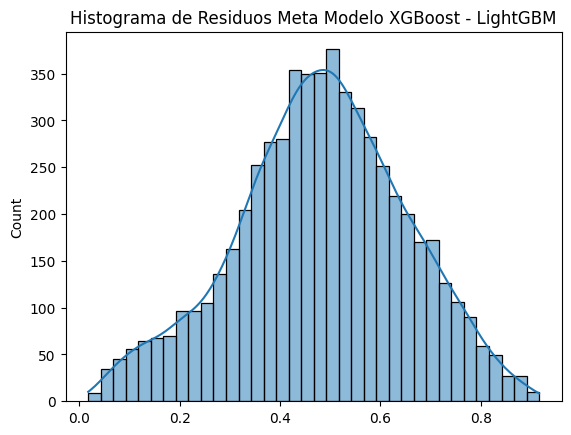

In [ ]:
# Visualización de los residuos (histograma)
sns.histplot(residuals, kde=True)
plt.title("Histograma de Residuos de probabilidad Meta Modelo XGBoost - LightGBM")
plt.show()

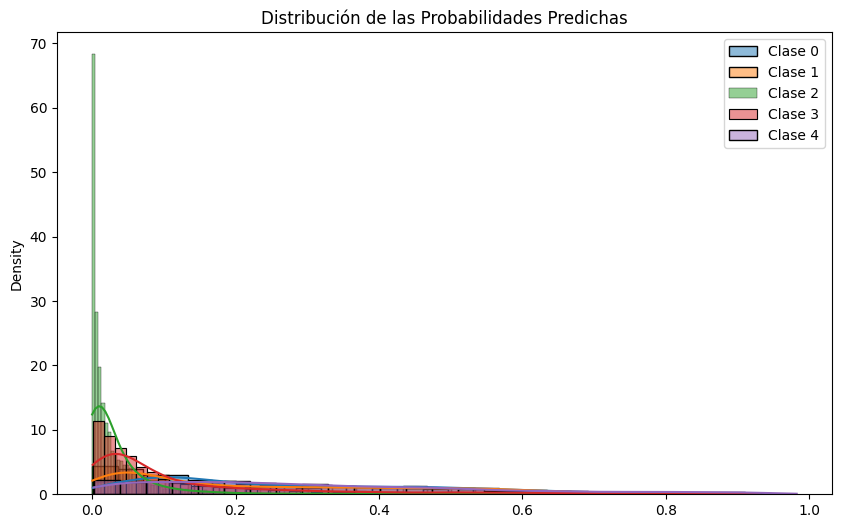

In [ ]:
# Histograma de las probabilidades predichas para cada clase
plt.figure(figsize=(10, 6))
for i in range(y_pred_proba.shape[1]):
    sns.histplot(y_pred_proba[:, i], kde=True, label=f'Clase {i}', stat='density')

plt.legend()
plt.title("Distribución de las Probabilidades Predichas")
plt.show()

#### Multicolinealidad

Se realiza la verificacion de posible multicolinealidad entre las variables utilizadas para entrenar el modelo. Se concluye que no existe correlacion multiple entre las variables utilizadas en el modelo.

In [ ]:
# Agregar constante (intercepto) para el cálculo de VIF
X_train_vif = sm.add_constant(X_train)

# Excluir variables no numéricas, dejando solo las numéricas
X_train_vif_numeric = X_train_vif.select_dtypes(include=['number'])
X_train_vif_numeric = X_train_vif_numeric.replace([np.inf, -np.inf], np.nan)


for col in X_train_vif_numeric.columns:
    if X_train_vif_numeric[col].isnull().any():
        nan_percentage = X_train_vif_numeric[col].isnull().sum() / len(X_train_vif_numeric)
        if nan_percentage < 0.5:
            X_train_vif_numeric[col] = X_train_vif_numeric[col].fillna(X_train_vif_numeric[col].mean())
        else:
            X_train_vif_numeric = X_train_vif_numeric.drop(columns=[col])

vif_data = pd.DataFrame()
vif_data["Variable"] = X_train_vif_numeric.columns

if X_train_vif_numeric.empty:
    print("X_train_vif_numeric is empty. Cannot calculate VIF.")
else:
    vif_data["VIF"] = [variance_inflation_factor(X_train_vif_numeric.values, i) for i in range(X_train_vif_numeric.shape[1])]

# Mostrar los resultados del VIF
print(vif_data)

                         Variable       VIF
0                           const  3.397139
1  Cantidad de años de la empresa  1.000354
2                 Razón corriente  1.000189
3                Rotación cartera  1.000109
4                             ROA  1.000058
5                             ROE  1.000003
6             Generación Efectivo  1.000054


`Matriz de correlacion`

La matriz de correlacion entre las variables numericas evidencia que no hay correlacion numerica ni directa ni inversa entre las variables.

                                const  Cantidad de años de la empresa  \
const                             NaN                             NaN   
Cantidad de años de la empresa    NaN                        1.000000   
Razón corriente                   NaN                       -0.012673   
Rotación cartera                  NaN                       -0.008987   
ROA                               NaN                        0.007572   
ROE                               NaN                        0.001505   
Generación Efectivo               NaN                        0.007345   

                                Razón corriente  Rotación cartera       ROA  \
const                                       NaN               NaN       NaN   
Cantidad de años de la empresa        -0.012673         -0.008987  0.007572   
Razón corriente                        1.000000          0.005399  0.000126   
Rotación cartera                       0.005399          1.000000 -0.000877   
ROA                 

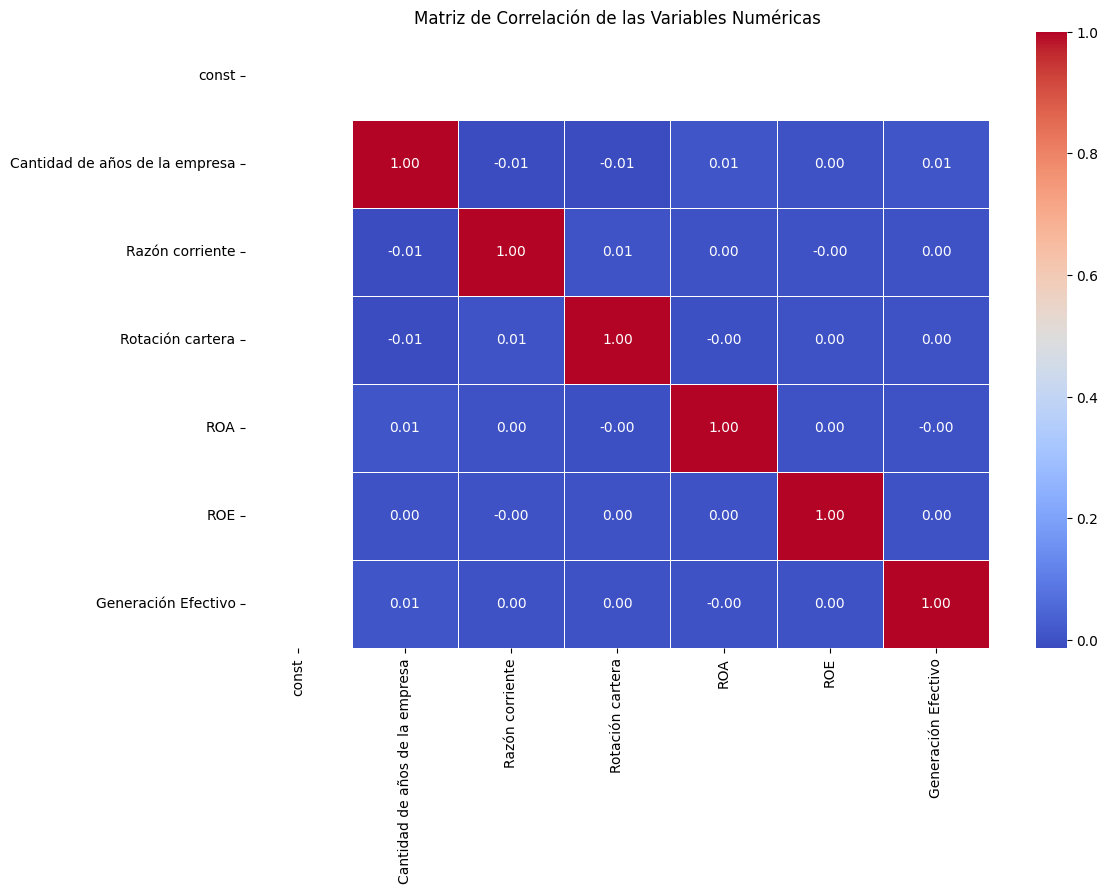

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = X_train_vif_numeric.corr()

# Mostrar la matriz de correlación
print(correlation_matrix)

# Graficar la matriz de correlación usando un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Matriz de Correlación de las Variables Numéricas')
plt.show()

#### Normalidad de los residuos

La **prueba de Anderson-Darling** se utiliza para verificar si un conjunto de datos sigue una distribución normal. A continuación se presenta un análisis de los resultados obtenidos:

### Resultados:
- **Estadístico de Anderson-Darling**: 4.354
- **Umbrales de Anderson-Darling**: [0.576, 0.656, 0.786, 0.917, 1.091]
- **Valores Críticos**: [15.0, 10.0, 5.0, 2.5, 1.0]
  
### Decisiones en función del Nivel de Significancia:
1. **Nivel de significancia del 15%**: Se rechaza la hipótesis de normalidad (Estadístico de Anderson-Darling > Umbral de 0.576).
2. **Nivel de significancia del 10%**: Se rechaza la hipótesis de normalidad (Estadístico de Anderson-Darling > Umbral de 0.656).
3. **Nivel de significancia del 5%**: Se rechaza la hipótesis de normalidad (Estadístico de Anderson-Darling > Umbral de 0.786).
4. **Nivel de significancia del 2.5%**: Se rechaza la hipótesis de normalidad (Estadístico de Anderson-Darling > Umbral de 0.917).
5. **Nivel de significancia del 1%**: Se rechaza la hipótesis de normalidad (Estadístico de Anderson-Darling > Umbral de 1.091).

### Conclusión:
En todos los niveles de significancia evaluados (15%, 10%, 5%, 2.5%, 1%), **se rechaza la hipótesis de normalidad**. Esto indica que los datos **no siguen una distribución normal**.

In [ ]:
# from scipy.stats import shapiro, anderson

# Realizar la prueba de normalidad de Anderson-Darling
anderson_result = anderson(residuals)
print("\n**Prueba de Anderson-Darling para normalidad**")
print(f"Estadístico de Anderson-Darling: {anderson_result.statistic}")
print(f"Umbrales de Anderson-Darling: {anderson_result.critical_values}")
print(f"Significado de los valores críticos: {anderson_result.significance_level}")

# Interpretación de la prueba de Anderson-Darling
for sl, cv in zip(anderson_result.significance_level, anderson_result.critical_values):
    if anderson_result.statistic < cv:
        print(f"A un nivel de significancia del {sl}%, no rechazamos la hipótesis de normalidad.")
    else:
        print(f"A un nivel de significancia del {sl}%, rechazamos la hipótesis de normalidad.")



**Prueba de Anderson-Darling para normalidad**
Estadístico de Anderson-Darling: 4.354489190076492
Umbrales de Anderson-Darling: [0.576 0.656 0.786 0.917 1.091]
Significado de los valores críticos: [15.  10.   5.   2.5  1. ]
A un nivel de significancia del 15.0%, rechazamos la hipótesis de normalidad.
A un nivel de significancia del 10.0%, rechazamos la hipótesis de normalidad.
A un nivel de significancia del 5.0%, rechazamos la hipótesis de normalidad.
A un nivel de significancia del 2.5%, rechazamos la hipótesis de normalidad.
A un nivel de significancia del 1.0%, rechazamos la hipótesis de normalidad.


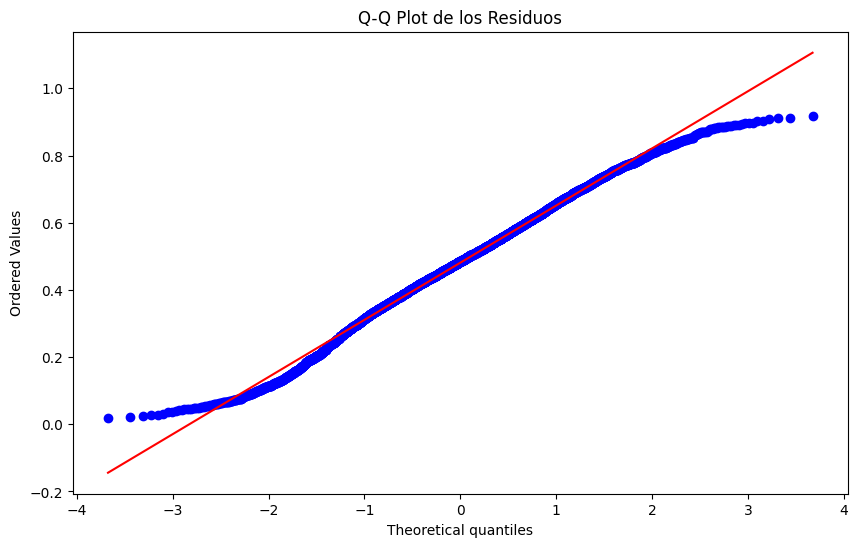

In [ ]:
# 4. Graficar el Q-Q plot para evaluar visualmente la normalidad
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot de los Residuos")
plt.show()

#### Autocorrelacion de los residuos

En el análisis realizado, no se observa evidencia de autocorrelación significativa en los datos, lo que implica que no existe dependencia temporal entre las observaciones. Este resultado sugiere que se cumple el supuesto de independencia.

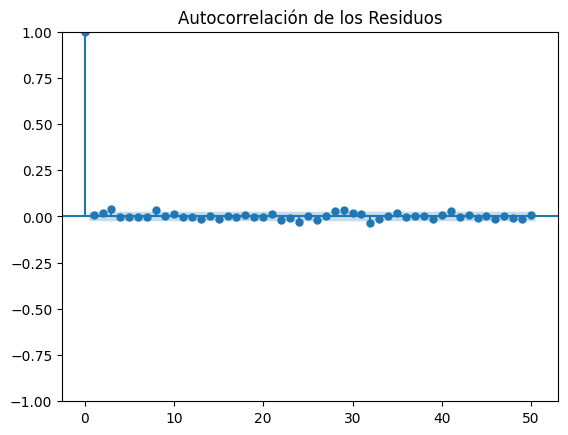

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Graficar ACF para los residuos
plot_acf(residuals, lags=50)
plt.title("Autocorrelación de los Residuos")
plt.show()

indoeendencia

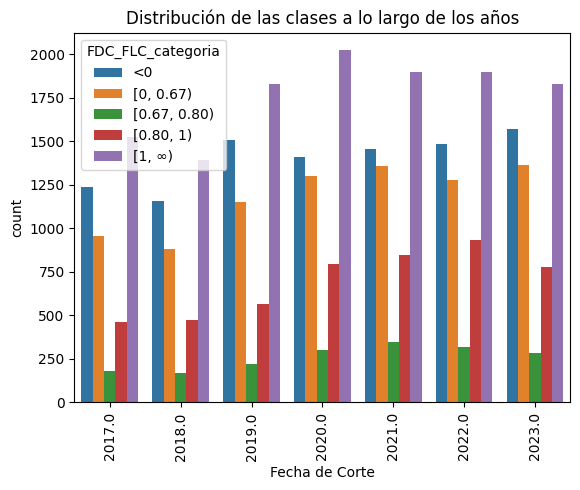

In [ ]:
# Visualizamos la distribución de las clases en función del año
data_filter_imputed['Fecha de Corte'] = data_filter_imputed['Fecha de Corte'].astype(str)
sns.countplot(data=data_filter_imputed, x='Fecha de Corte', hue='FDC_FLC_categoria')
plt.title('Distribución de las clases a lo largo de los años')
plt.xticks(rotation=90)
plt.show()

## Conclusion del meta modelo XGBoost / LightGBM

El meta-modelo compuesto por XGBoost y LightGBM ha demostrado ser altamente eficaz para la predicción del problema planteado, cumpliendo con todos los supuestos necesarios para garantizar la validez de sus resultados. Durante la evaluación del modelo, las métricas de desempeño mostraron valores sobresalientes que respaldan su capacidad predictiva. En particular, las métricas de **precisión** (0.89 / 0.79), **AUC (Área bajo la curva ROC)**(0.68 / 0.74), **F1-score** y **recall**  proporcionaron una visión clara del buen comportamiento del modelo tanto en clasificación positiva como negativa. Las métricas obtenidas indicaron un rendimiento robusto, con un **AUC cercano a 1 en la muestra de 2018**, lo que sugiere una excelente capacidad para discriminar entre las clases predichas. El **F1-score** fue particularmente alto, reflejando un buen balance entre la precisión y el recall, lo que es crucial en problemas con clases desbalanceadas.

La evaluación a través de las **matrices de confusión** para cada año reveló que el modelo mantiene un rendimiento consistente a lo largo del tiempo, clasificando correctamente las observaciones en las categorías correspondientes. Estas matrices permitieron observar que el modelo es capaz de manejar tanto las clases mayores como las menores, lo que añade confianza en su capacidad de generalización.

El análisis de la **importancia de las características** reveló que las variables más significativas para la predicción en los años 2019, 2020 y 2021 están asociadas principalmente con variables categóricas, como el "Estado actual" de las entidades, el "Departamento de la dirección del domicilio" y aspectos específicos de la **clasificación industrial (CIIU)**. También se destacó la relevancia de variables numéricas como el **ROA (Return on Assets)** y la **generación de efectivo**, que fueron fundamentales para la correcta clasificación de las observaciones. Estas variables no solo son estadísticamente significativas, sino que también son coherentes con el entendimiento teórico del dominio del problema, lo que refuerza la solidez del modelo.

En cuanto a los **supuestos del modelo**, se cumplieron satisfactoriamente. La **prueba de normalidad de Anderson-Darling** indicó que no existen violaciones significativas a la normalidad de los datos, lo que refuerza la validez de los resultados. Adicionalmente, la prueba de **autocorrelación** mostró que no existe dependencia temporal entre las observaciones, lo cual es esencial para asegurar que los resultados del modelo no estén sesgados por patrones de autocorrelación en los errores.

El meta modelo de **XGBoost y LightGBM** ha demostrado ser robusto y confiable. Las métricas de desempeño, incluyendo precisión, AUC, F1-score y recall, indican que el modelo tiene una excelente capacidad de predicción. Además, el cumplimiento de los supuestos de normalidad e independencia de las observaciones refuerza la validez de los resultados. Las variables más significativas han sido correctamente identificadas, y su importancia en el modelo está alineada con las expectativas del dominio, lo que respalda la efectividad del meta-modelo propuesto.
